<h1>Biomass Extraction and Modeling for Askvoll Region</h1>

This Python code is developed for biomass extraction and modeling in the Askvoll region, utilizing LiDAR data for tree segmentation and extracting tree heights from Digital Surface Model (DSM) and Digital Terrain Model (DTM). The dataset includes precise tree coordinates, and a map of dominant tree species in the Area of Interest (AOI) is incorporated. The workflow involves preprocessing LiDAR data, segmenting trees, calculating heights, identifying species, and estimating biomass. Key libraries such as lidR, geopandas, and scikit-learn are used for LiDAR processing, spatial analysis, and machine learning. The results provide insights into biomass distribution, species composition, and support environmental monitoring in the Askvoll region.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing import image  # Add this import
import tifffile
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load tree data from CSV
tree_data = pd.read_csv('newAOI_tree_data11.csv')
# Load and preprocess segmented images
optical_folder = 'Optical_patches_16x16'
sar_folder = 'SAR_patches_16x16'
#labels = tree_data['Biomass'].values
labels = tree_data['Biomass'].values
species_labels = tree_data['TreeSpecies'].values
height_labels = tree_data['Z'].values
DBH_labels = tree_data['DBH'].values

In [3]:
# Print the shape
print("Shape of tree_data:", tree_data.shape)


Shape of tree_data: (30686, 7)


In [4]:
asymptote_decidious = 18.47
asymptote_pine = 24.99
asymptote_spruce = 29.10

# Define conditions for filtering
deciduous_condition = (tree_data['TreeSpecies'] == 3) & (tree_data['Z'] > asymptote_decidious)
pine_condition = (tree_data['TreeSpecies'] == 2) & (tree_data['Z'] > asymptote_pine)
spruce_condition = (tree_data['TreeSpecies'] == 1) & (tree_data['Z'] > asymptote_spruce)

# Apply filtering
filtered_tree_data = tree_data[~(deciduous_condition | pine_condition | spruce_condition)]

# Print the filtered DataFrame
print(filtered_tree_data)
tree_data=filtered_tree_data
#labels = tree_data['Biomass'].values
labels = tree_data['Biomass'].values

labels = np.log1p(tree_data['Biomass'])

species_labels = tree_data['TreeSpecies'].values
height_labels = tree_data['Z'].values
DBH_labels = tree_data['DBH'].values

       treeID      Z  TreeSpecies   coords.x1    coords.x2        DBH  \
0           1   2.72            3  293752.125  6808799.875   0.000000   
1           2   6.01            3  293762.625  6808799.875   7.375844   
2           3   6.28            3  293764.875  6808799.875   7.756884   
3           4   6.36            3  293786.875  6808799.875   7.871765   
4           5   6.33            3  293819.875  6808799.875   7.828575   
...       ...    ...          ...         ...          ...        ...   
30681   30682   8.14            2  293966.625  6807600.125  11.715224   
30682   30683   7.28            2  293983.375  6807600.125  10.425126   
30683   30684  13.38            2  294726.125  6807600.125  21.961304   
30684   30685  16.09            2  295074.625  6807600.125  30.222160   
30685   30686  12.59            2  295125.125  6807600.125  20.046341   

          Biomass  
0        0.000000  
1        9.634474  
2       10.993850  
3       11.427600  
4       11.263212  
...

In [5]:
print(tree_data)

       treeID      Z  TreeSpecies   coords.x1    coords.x2        DBH  \
0           1   2.72            3  293752.125  6808799.875   0.000000   
1           2   6.01            3  293762.625  6808799.875   7.375844   
2           3   6.28            3  293764.875  6808799.875   7.756884   
3           4   6.36            3  293786.875  6808799.875   7.871765   
4           5   6.33            3  293819.875  6808799.875   7.828575   
...       ...    ...          ...         ...          ...        ...   
30681   30682   8.14            2  293966.625  6807600.125  11.715224   
30682   30683   7.28            2  293983.375  6807600.125  10.425126   
30683   30684  13.38            2  294726.125  6807600.125  21.961304   
30684   30685  16.09            2  295074.625  6807600.125  30.222160   
30685   30686  12.59            2  295125.125  6807600.125  20.046341   

          Biomass  
0        0.000000  
1        9.634474  
2       10.993850  
3       11.427600  
4       11.263212  
...

In [6]:
# Find the index of the row with the maximum 'Biomass'
max_biomass_index = tree_data['Biomass'].idxmax()

# Retrieve the row with the maximum 'Biomass'
max_biomass_row = tree_data.loc[max_biomass_index]

# Print the row with the maximum 'Biomass'
print(max_biomass_row)


treeID         1.845300e+04
Z              2.499000e+01
TreeSpecies    2.000000e+00
coords.x1      2.936069e+05
coords.x2      6.808080e+06
DBH            1.394155e+02
Biomass        3.681807e+03
Name: 18452, dtype: float64


In [7]:
# Convert the Series to a DataFrame
max_biomass_row_df = max_biomass_row.to_frame().transpose()

# Print the DataFrame containing only the row with the maximum biomass
print(max_biomass_row_df)


        treeID      Z  TreeSpecies   coords.x1    coords.x2         DBH  \
18452  18453.0  24.99          2.0  293606.875  6808080.375  139.415466   

           Biomass  
18452  3681.807368  


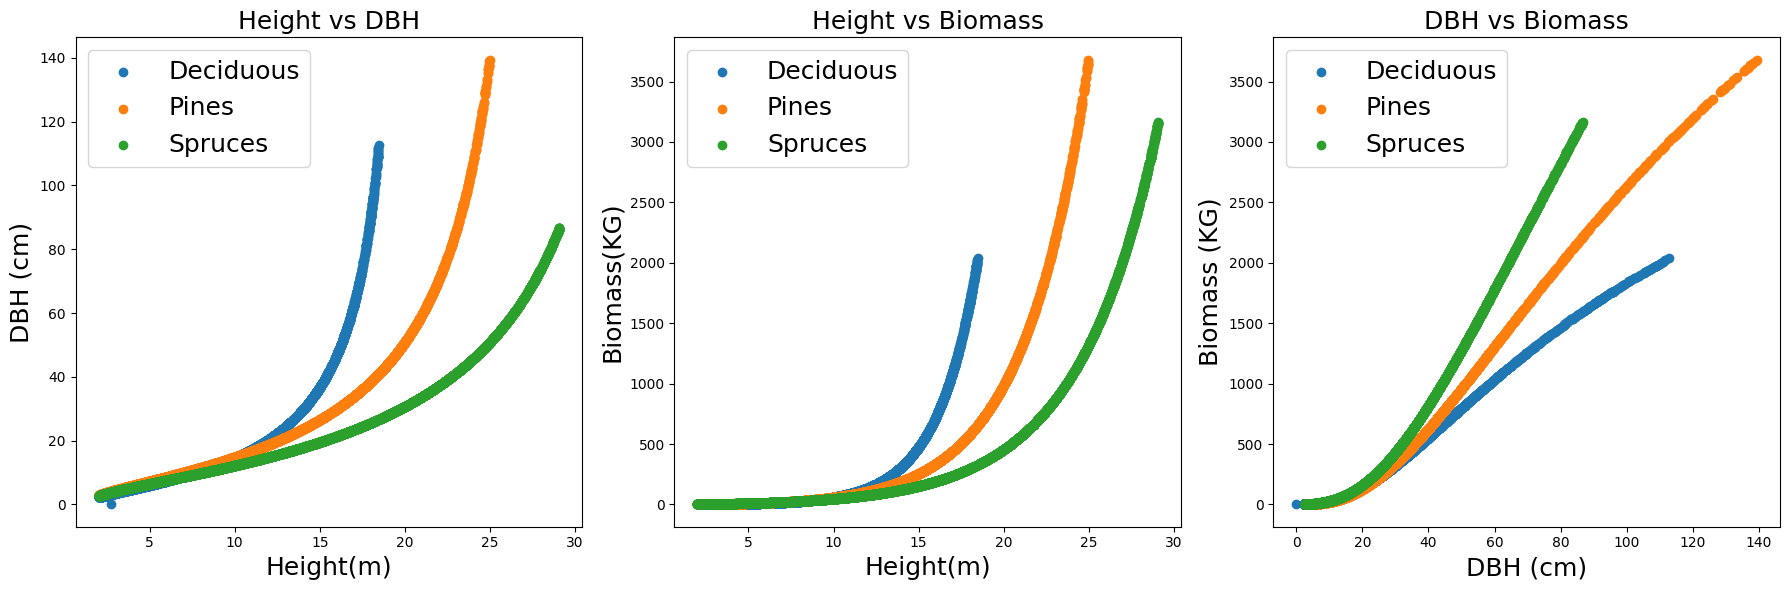

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already read the CSV file into 'tree_data'
#tree_data = pd.read_csv('AOI_tree_data.csv')

plt.figure(figsize=(18, 6))

# Scatter plot for Z and DBH
plt.subplot(1, 3, 1)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['Z'], subset['DBH'], label=f'{species_name}')

plt.title('Height vs DBH', fontsize=18)
plt.xlabel('Height(m)', fontsize=18)
plt.ylabel('DBH (cm)', fontsize=18)
plt.legend( fontsize=18)

# Scatter plot for Z and Biomass
plt.subplot(1, 3, 2)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['Z'], subset['Biomass'], label=f'{species_name}')

plt.title('Height vs Biomass', fontsize=18)
plt.xlabel('Height(m)', fontsize=18)
plt.ylabel('Biomass(KG)', fontsize=18)
plt.legend(fontsize=18)




#plt.figure(figsize=(12, 6))

# Scatter plot for Z and DBH
plt.subplot(1, 3, 3)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['DBH'], subset['Biomass'], label=f'{species_name}')

plt.title('DBH vs Biomass', fontsize=18)
plt.xlabel('DBH (cm)', fontsize=18)
plt.ylabel('Biomass (KG)', fontsize=18)
plt.legend( fontsize=18)

plt.savefig('my_plots.png', format='png')
plt.tight_layout()
plt.show()


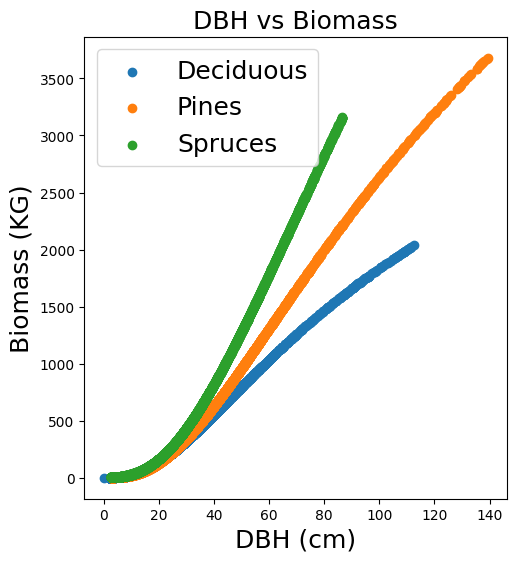

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already read the CSV file into 'tree_data'
#tree_data = pd.read_csv('AOI_tree_data.csv')

plt.figure(figsize=(12, 6))

# Scatter plot for Z and DBH
plt.subplot(1, 2, 1)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['DBH'], subset['Biomass'], label=f'{species_name}')

plt.title('DBH vs Biomass', fontsize=18)
plt.xlabel('DBH (cm)', fontsize=18)
plt.ylabel('Biomass (KG)', fontsize=18)
plt.legend( fontsize=18)

plt.savefig('my_plots.svg', format='svg')


In [10]:
# Print the minimum and maximum values of 'Biomass'
min_biomass = tree_data['Biomass'].min()
max_biomass = tree_data['Biomass'].max()

print(f"Minimum Biomass: {min_biomass}")
print(f"Maximum Biomass: {max_biomass}")

# Print the minimum and maximum values of 'Biomass'
min_DBH = tree_data['DBH'].min()
max_DBH = tree_data['DBH'].max()

print(f"Minimum DBH: {min_DBH}")
print(f"Maximum DBH: {max_DBH}")

# Print the minimum and maximum values of 'Biomass'
min_Z = tree_data['Z'].min()
max_Z = tree_data['Z'].max()

print(f"Minimum Height: {min_Z}")
print(f"Maximum Height: {max_Z}")


num_rows = tree_data.shape[0]
print(f"Total number of rows: {num_rows}")


Minimum Biomass: 0.0
Maximum Biomass: 3681.807368
Minimum DBH: 0.0
Maximum DBH: 139.4154657
Minimum Height: 2.0
Maximum Height: 29.09
Total number of rows: 29067


In [11]:
print(f"Maximum Biomass: {tree_data['Biomass']} ")

Maximum Biomass: 0          0.000000
1          9.634474
2         10.993850
3         11.427600
4         11.263212
            ...    
30681     31.017450
30682     22.769565
30683    160.113326
30684    343.080187
30685    127.225109
Name: Biomass, Length: 29067, dtype: float64 


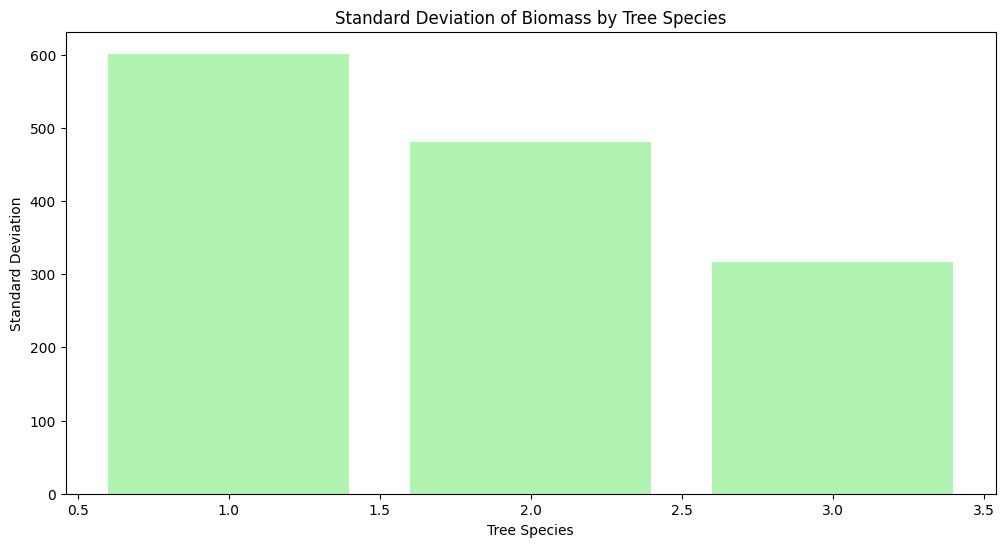

In [12]:
biomass_std = tree_data.groupby('TreeSpecies')['Biomass'].std().reset_index()

# Plotting the standard deviation of 'Biomass'
plt.figure(figsize=(12, 6))
plt.bar(biomass_std['TreeSpecies'], biomass_std['Biomass'], color='lightgreen', alpha=0.7)
plt.title('Standard Deviation of Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Standard Deviation')
plt.show()

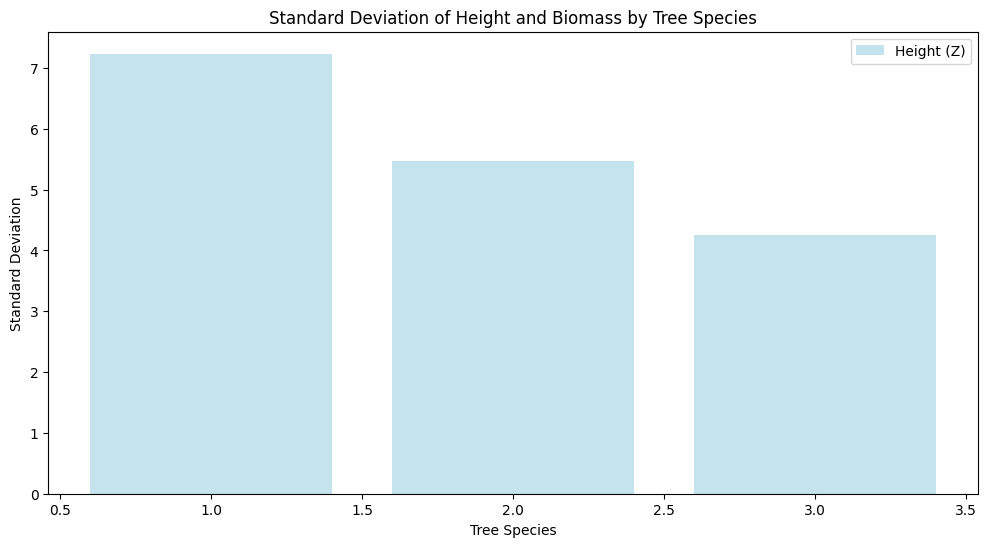

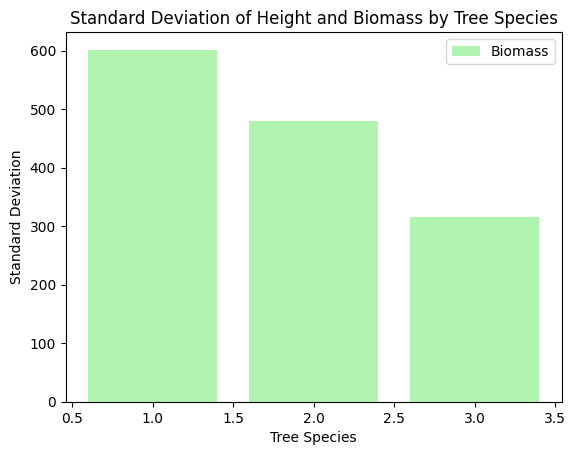

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# Group by 'TreeSpecies' and calculate mean and standard deviation for 'Z' and 'Biomass'
grouped_data = tree_data.groupby('TreeSpecies').agg({'Z': ['mean', 'std'], 'Biomass': 'std'}).reset_index()

# Plotting the standard deviation of 'Z' and 'Biomass'
plt.figure(figsize=(12, 6))

# Standard deviation plot for 'Z'
plt.bar(grouped_data['TreeSpecies'], grouped_data[('Z', 'std')], color='lightblue', alpha=0.7, label='Height (Z)')
plt.title('Standard Deviation of Height and Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

# Standard deviation plot for 'Biomass'
plt.bar(grouped_data['TreeSpecies'], grouped_data[('Biomass', 'std')], color='lightgreen', alpha=0.7, label='Biomass')
plt.title('Standard Deviation of Height and Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()


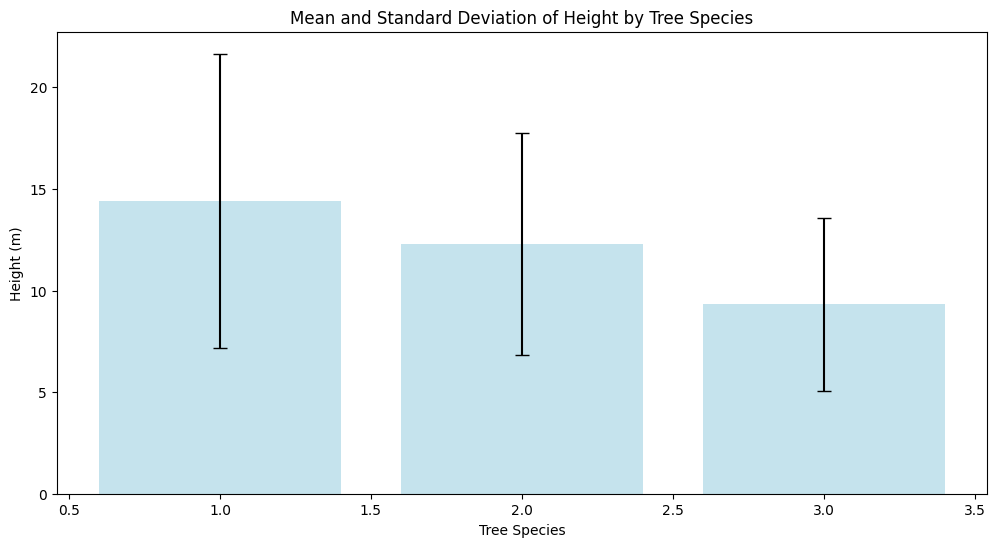

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'tree_data' is already loaded from the CSV

# Group by 'TreeSpecies' and calculate mean and standard deviation for 'Z'
grouped_data = tree_data.groupby('TreeSpecies')['Z'].agg(['mean', 'std']).reset_index()

# Plotting the mean and standard deviation of 'Z'
plt.figure(figsize=(12, 6))
plt.bar(grouped_data['TreeSpecies'], grouped_data['mean'], yerr=grouped_data['std'], capsize=5, color='lightblue', alpha=0.7)
plt.title('Mean and Standard Deviation of Height by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Height (m)')
plt.show()


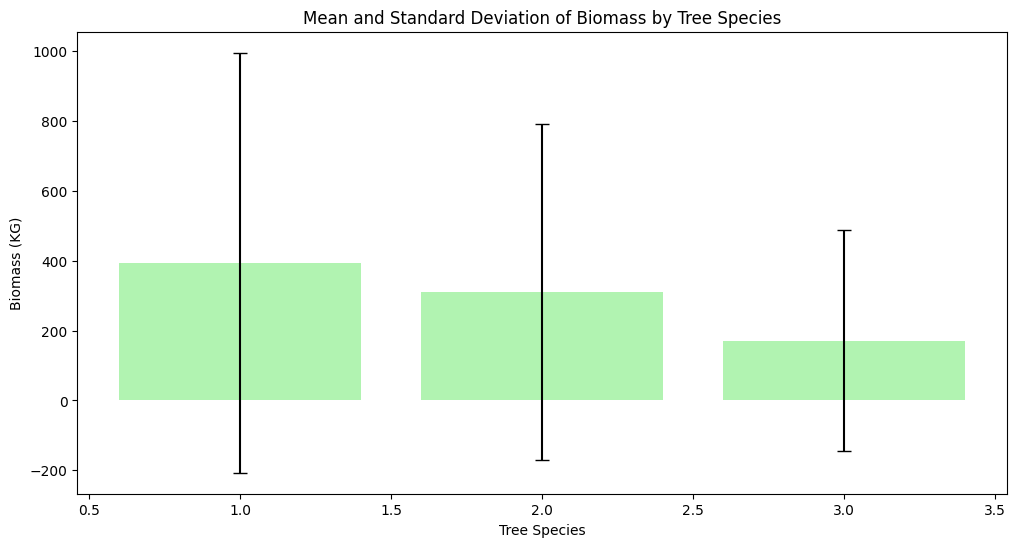

In [15]:
# Group by 'TreeSpecies' and calculate mean and standard deviation for 'Biomass'
grouped_biomass_data = tree_data.groupby('TreeSpecies')['Biomass'].agg(['mean', 'std']).reset_index()

# Plotting the mean and standard deviation of 'Biomass'
plt.figure(figsize=(12, 6))
plt.bar(grouped_biomass_data['TreeSpecies'], grouped_biomass_data['mean'], yerr=grouped_biomass_data['std'], capsize=5, color='lightgreen', alpha=0.7)
plt.title('Mean and Standard Deviation of Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Biomass (KG)')
plt.show()


In [16]:
# Create lists for image paths, labels, and species labels
optical_image_paths = []
sar_image_paths = []


In [17]:
# Iterate through tree IDs
for tree_id in tree_data['treeID']:
    # Construct paths for optical and SAR images
    optical_path = os.path.join(optical_folder, f"tree_{tree_id}.0.tif")
    sar_path = os.path.join(sar_folder, f"tree_{tree_id}.0.tif")

    try:
        # Load optical image and extract specific channels (2, 3, and 5)
        optical_image = tifffile.imread(optical_path)[:, :, [2, 3, 5]]
        sar_image= tifffile.imread(sar_path)
        # Print information about the loaded optical image
        print(f"Tree ID: {tree_id}, Optical Image Shape: {optical_image.shape}")
        print(f"Tree ID: {tree_id}, Sar Image Shape: {sar_image.shape}")
       
        sar_image_paths.append(sar_image)
        optical_image_paths.append(optical_image)
    except Exception as e:
        print(f"Error loading optical image {optical_path}: {e}")



Tree ID: 1, Optical Image Shape: (16, 16, 3)
Tree ID: 1, Sar Image Shape: (16, 16)
Tree ID: 2, Optical Image Shape: (16, 16, 3)
Tree ID: 2, Sar Image Shape: (16, 16)
Tree ID: 3, Optical Image Shape: (16, 16, 3)
Tree ID: 3, Sar Image Shape: (16, 16)
Tree ID: 4, Optical Image Shape: (16, 16, 3)
Tree ID: 4, Sar Image Shape: (16, 16)
Tree ID: 5, Optical Image Shape: (16, 16, 3)
Tree ID: 5, Sar Image Shape: (16, 16)
Tree ID: 6, Optical Image Shape: (16, 16, 3)
Tree ID: 6, Sar Image Shape: (16, 16)
Tree ID: 7, Optical Image Shape: (16, 16, 3)
Tree ID: 7, Sar Image Shape: (16, 16)
Tree ID: 8, Optical Image Shape: (16, 16, 3)
Tree ID: 8, Sar Image Shape: (16, 16)
Tree ID: 9, Optical Image Shape: (16, 16, 3)
Tree ID: 9, Sar Image Shape: (16, 16)
Tree ID: 10, Optical Image Shape: (16, 16, 3)
Tree ID: 10, Sar Image Shape: (16, 16)
Tree ID: 11, Optical Image Shape: (16, 16, 3)
Tree ID: 11, Sar Image Shape: (16, 16)
Tree ID: 12, Optical Image Shape: (16, 16, 3)
Tree ID: 12, Sar Image Shape: (16, 16

Tree ID: 159, Optical Image Shape: (16, 16, 3)
Tree ID: 159, Sar Image Shape: (16, 16)
Tree ID: 160, Optical Image Shape: (16, 16, 3)
Tree ID: 160, Sar Image Shape: (16, 16)
Tree ID: 161, Optical Image Shape: (16, 16, 3)
Tree ID: 161, Sar Image Shape: (16, 16)
Tree ID: 162, Optical Image Shape: (16, 16, 3)
Tree ID: 162, Sar Image Shape: (16, 16)
Tree ID: 163, Optical Image Shape: (16, 16, 3)
Tree ID: 163, Sar Image Shape: (16, 16)
Tree ID: 164, Optical Image Shape: (16, 16, 3)
Tree ID: 164, Sar Image Shape: (16, 16)
Tree ID: 165, Optical Image Shape: (16, 16, 3)
Tree ID: 165, Sar Image Shape: (16, 16)
Tree ID: 166, Optical Image Shape: (16, 16, 3)
Tree ID: 166, Sar Image Shape: (16, 16)
Tree ID: 167, Optical Image Shape: (16, 16, 3)
Tree ID: 167, Sar Image Shape: (16, 16)
Tree ID: 168, Optical Image Shape: (16, 16, 3)
Tree ID: 168, Sar Image Shape: (16, 16)
Tree ID: 169, Optical Image Shape: (16, 16, 3)
Tree ID: 169, Sar Image Shape: (16, 16)
Tree ID: 170, Optical Image Shape: (16, 16,

Tree ID: 316, Optical Image Shape: (16, 16, 3)
Tree ID: 316, Sar Image Shape: (16, 16)
Tree ID: 317, Optical Image Shape: (16, 16, 3)
Tree ID: 317, Sar Image Shape: (16, 16)
Tree ID: 318, Optical Image Shape: (16, 16, 3)
Tree ID: 318, Sar Image Shape: (16, 16)
Tree ID: 319, Optical Image Shape: (16, 16, 3)
Tree ID: 319, Sar Image Shape: (16, 16)
Tree ID: 320, Optical Image Shape: (16, 16, 3)
Tree ID: 320, Sar Image Shape: (16, 16)
Tree ID: 321, Optical Image Shape: (16, 16, 3)
Tree ID: 321, Sar Image Shape: (16, 16)
Tree ID: 322, Optical Image Shape: (16, 16, 3)
Tree ID: 322, Sar Image Shape: (16, 16)
Tree ID: 323, Optical Image Shape: (16, 16, 3)
Tree ID: 323, Sar Image Shape: (16, 16)
Tree ID: 324, Optical Image Shape: (16, 16, 3)
Tree ID: 324, Sar Image Shape: (16, 16)
Tree ID: 325, Optical Image Shape: (16, 16, 3)
Tree ID: 325, Sar Image Shape: (16, 16)
Tree ID: 326, Optical Image Shape: (16, 16, 3)
Tree ID: 326, Sar Image Shape: (16, 16)
Tree ID: 327, Optical Image Shape: (16, 16,

Tree ID: 473, Optical Image Shape: (16, 16, 3)
Tree ID: 473, Sar Image Shape: (16, 16)
Tree ID: 474, Optical Image Shape: (16, 16, 3)
Tree ID: 474, Sar Image Shape: (16, 16)
Tree ID: 475, Optical Image Shape: (16, 16, 3)
Tree ID: 475, Sar Image Shape: (16, 16)
Tree ID: 476, Optical Image Shape: (16, 16, 3)
Tree ID: 476, Sar Image Shape: (16, 16)
Tree ID: 477, Optical Image Shape: (16, 16, 3)
Tree ID: 477, Sar Image Shape: (16, 16)
Tree ID: 478, Optical Image Shape: (16, 16, 3)
Tree ID: 478, Sar Image Shape: (16, 16)
Tree ID: 479, Optical Image Shape: (16, 16, 3)
Tree ID: 479, Sar Image Shape: (16, 16)
Tree ID: 480, Optical Image Shape: (16, 16, 3)
Tree ID: 480, Sar Image Shape: (16, 16)
Tree ID: 481, Optical Image Shape: (16, 16, 3)
Tree ID: 481, Sar Image Shape: (16, 16)
Tree ID: 482, Optical Image Shape: (16, 16, 3)
Tree ID: 482, Sar Image Shape: (16, 16)
Tree ID: 483, Optical Image Shape: (16, 16, 3)
Tree ID: 483, Sar Image Shape: (16, 16)
Tree ID: 484, Optical Image Shape: (16, 16,

Tree ID: 632, Optical Image Shape: (16, 16, 3)
Tree ID: 632, Sar Image Shape: (16, 16)
Tree ID: 634, Optical Image Shape: (16, 16, 3)
Tree ID: 634, Sar Image Shape: (16, 16)
Tree ID: 635, Optical Image Shape: (16, 16, 3)
Tree ID: 635, Sar Image Shape: (16, 16)
Tree ID: 636, Optical Image Shape: (16, 16, 3)
Tree ID: 636, Sar Image Shape: (16, 16)
Tree ID: 637, Optical Image Shape: (16, 16, 3)
Tree ID: 637, Sar Image Shape: (16, 16)
Tree ID: 638, Optical Image Shape: (16, 16, 3)
Tree ID: 638, Sar Image Shape: (16, 16)
Tree ID: 639, Optical Image Shape: (16, 16, 3)
Tree ID: 639, Sar Image Shape: (16, 16)
Tree ID: 640, Optical Image Shape: (16, 16, 3)
Tree ID: 640, Sar Image Shape: (16, 16)
Tree ID: 641, Optical Image Shape: (16, 16, 3)
Tree ID: 641, Sar Image Shape: (16, 16)
Tree ID: 642, Optical Image Shape: (16, 16, 3)
Tree ID: 642, Sar Image Shape: (16, 16)
Tree ID: 643, Optical Image Shape: (16, 16, 3)
Tree ID: 643, Sar Image Shape: (16, 16)
Tree ID: 644, Optical Image Shape: (16, 16,

Tree ID: 790, Optical Image Shape: (16, 16, 3)
Tree ID: 790, Sar Image Shape: (16, 16)
Tree ID: 791, Optical Image Shape: (16, 16, 3)
Tree ID: 791, Sar Image Shape: (16, 16)
Tree ID: 792, Optical Image Shape: (16, 16, 3)
Tree ID: 792, Sar Image Shape: (16, 16)
Tree ID: 793, Optical Image Shape: (16, 16, 3)
Tree ID: 793, Sar Image Shape: (16, 16)
Tree ID: 794, Optical Image Shape: (16, 16, 3)
Tree ID: 794, Sar Image Shape: (16, 16)
Tree ID: 795, Optical Image Shape: (16, 16, 3)
Tree ID: 795, Sar Image Shape: (16, 16)
Tree ID: 796, Optical Image Shape: (16, 16, 3)
Tree ID: 796, Sar Image Shape: (16, 16)
Tree ID: 797, Optical Image Shape: (16, 16, 3)
Tree ID: 797, Sar Image Shape: (16, 16)
Tree ID: 798, Optical Image Shape: (16, 16, 3)
Tree ID: 798, Sar Image Shape: (16, 16)
Tree ID: 799, Optical Image Shape: (16, 16, 3)
Tree ID: 799, Sar Image Shape: (16, 16)
Tree ID: 800, Optical Image Shape: (16, 16, 3)
Tree ID: 800, Sar Image Shape: (16, 16)
Tree ID: 801, Optical Image Shape: (16, 16,

Tree ID: 951, Optical Image Shape: (16, 16, 3)
Tree ID: 951, Sar Image Shape: (16, 16)
Tree ID: 952, Optical Image Shape: (16, 16, 3)
Tree ID: 952, Sar Image Shape: (16, 16)
Tree ID: 953, Optical Image Shape: (16, 16, 3)
Tree ID: 953, Sar Image Shape: (16, 16)
Tree ID: 954, Optical Image Shape: (16, 16, 3)
Tree ID: 954, Sar Image Shape: (16, 16)
Tree ID: 955, Optical Image Shape: (16, 16, 3)
Tree ID: 955, Sar Image Shape: (16, 16)
Tree ID: 956, Optical Image Shape: (16, 16, 3)
Tree ID: 956, Sar Image Shape: (16, 16)
Tree ID: 957, Optical Image Shape: (16, 16, 3)
Tree ID: 957, Sar Image Shape: (16, 16)
Tree ID: 958, Optical Image Shape: (16, 16, 3)
Tree ID: 958, Sar Image Shape: (16, 16)
Tree ID: 960, Optical Image Shape: (16, 16, 3)
Tree ID: 960, Sar Image Shape: (16, 16)
Tree ID: 961, Optical Image Shape: (16, 16, 3)
Tree ID: 961, Sar Image Shape: (16, 16)
Tree ID: 962, Optical Image Shape: (16, 16, 3)
Tree ID: 962, Sar Image Shape: (16, 16)
Tree ID: 963, Optical Image Shape: (16, 16,

Tree ID: 1117, Optical Image Shape: (16, 16, 3)
Tree ID: 1117, Sar Image Shape: (16, 16)
Tree ID: 1118, Optical Image Shape: (16, 16, 3)
Tree ID: 1118, Sar Image Shape: (16, 16)
Tree ID: 1121, Optical Image Shape: (16, 16, 3)
Tree ID: 1121, Sar Image Shape: (16, 16)
Tree ID: 1122, Optical Image Shape: (16, 16, 3)
Tree ID: 1122, Sar Image Shape: (16, 16)
Tree ID: 1123, Optical Image Shape: (16, 16, 3)
Tree ID: 1123, Sar Image Shape: (16, 16)
Tree ID: 1124, Optical Image Shape: (16, 16, 3)
Tree ID: 1124, Sar Image Shape: (16, 16)
Tree ID: 1125, Optical Image Shape: (16, 16, 3)
Tree ID: 1125, Sar Image Shape: (16, 16)
Tree ID: 1126, Optical Image Shape: (16, 16, 3)
Tree ID: 1126, Sar Image Shape: (16, 16)
Tree ID: 1127, Optical Image Shape: (16, 16, 3)
Tree ID: 1127, Sar Image Shape: (16, 16)
Tree ID: 1128, Optical Image Shape: (16, 16, 3)
Tree ID: 1128, Sar Image Shape: (16, 16)
Tree ID: 1129, Optical Image Shape: (16, 16, 3)
Tree ID: 1129, Sar Image Shape: (16, 16)
Tree ID: 1130, Optica

Tree ID: 1291, Optical Image Shape: (16, 16, 3)
Tree ID: 1291, Sar Image Shape: (16, 16)
Tree ID: 1292, Optical Image Shape: (16, 16, 3)
Tree ID: 1292, Sar Image Shape: (16, 16)
Tree ID: 1293, Optical Image Shape: (16, 16, 3)
Tree ID: 1293, Sar Image Shape: (16, 16)
Tree ID: 1294, Optical Image Shape: (16, 16, 3)
Tree ID: 1294, Sar Image Shape: (16, 16)
Tree ID: 1295, Optical Image Shape: (16, 16, 3)
Tree ID: 1295, Sar Image Shape: (16, 16)
Tree ID: 1296, Optical Image Shape: (16, 16, 3)
Tree ID: 1296, Sar Image Shape: (16, 16)
Tree ID: 1297, Optical Image Shape: (16, 16, 3)
Tree ID: 1297, Sar Image Shape: (16, 16)
Tree ID: 1298, Optical Image Shape: (16, 16, 3)
Tree ID: 1298, Sar Image Shape: (16, 16)
Tree ID: 1299, Optical Image Shape: (16, 16, 3)
Tree ID: 1299, Sar Image Shape: (16, 16)
Tree ID: 1300, Optical Image Shape: (16, 16, 3)
Tree ID: 1300, Sar Image Shape: (16, 16)
Tree ID: 1304, Optical Image Shape: (16, 16, 3)
Tree ID: 1304, Sar Image Shape: (16, 16)
Tree ID: 1305, Optica

Tree ID: 1468, Optical Image Shape: (16, 16, 3)
Tree ID: 1468, Sar Image Shape: (16, 16)
Tree ID: 1470, Optical Image Shape: (16, 16, 3)
Tree ID: 1470, Sar Image Shape: (16, 16)
Tree ID: 1471, Optical Image Shape: (16, 16, 3)
Tree ID: 1471, Sar Image Shape: (16, 16)
Tree ID: 1472, Optical Image Shape: (16, 16, 3)
Tree ID: 1472, Sar Image Shape: (16, 16)
Tree ID: 1473, Optical Image Shape: (16, 16, 3)
Tree ID: 1473, Sar Image Shape: (16, 16)
Tree ID: 1474, Optical Image Shape: (16, 16, 3)
Tree ID: 1474, Sar Image Shape: (16, 16)
Tree ID: 1475, Optical Image Shape: (16, 16, 3)
Tree ID: 1475, Sar Image Shape: (16, 16)
Tree ID: 1476, Optical Image Shape: (16, 16, 3)
Tree ID: 1476, Sar Image Shape: (16, 16)
Tree ID: 1477, Optical Image Shape: (16, 16, 3)
Tree ID: 1477, Sar Image Shape: (16, 16)
Tree ID: 1478, Optical Image Shape: (16, 16, 3)
Tree ID: 1478, Sar Image Shape: (16, 16)
Tree ID: 1479, Optical Image Shape: (16, 16, 3)
Tree ID: 1479, Sar Image Shape: (16, 16)
Tree ID: 1480, Optica

Tree ID: 1644, Optical Image Shape: (16, 16, 3)
Tree ID: 1644, Sar Image Shape: (16, 16)
Tree ID: 1646, Optical Image Shape: (16, 16, 3)
Tree ID: 1646, Sar Image Shape: (16, 16)
Tree ID: 1647, Optical Image Shape: (16, 16, 3)
Tree ID: 1647, Sar Image Shape: (16, 16)
Tree ID: 1648, Optical Image Shape: (16, 16, 3)
Tree ID: 1648, Sar Image Shape: (16, 16)
Tree ID: 1649, Optical Image Shape: (16, 16, 3)
Tree ID: 1649, Sar Image Shape: (16, 16)
Tree ID: 1650, Optical Image Shape: (16, 16, 3)
Tree ID: 1650, Sar Image Shape: (16, 16)
Tree ID: 1651, Optical Image Shape: (16, 16, 3)
Tree ID: 1651, Sar Image Shape: (16, 16)
Tree ID: 1652, Optical Image Shape: (16, 16, 3)
Tree ID: 1652, Sar Image Shape: (16, 16)
Tree ID: 1653, Optical Image Shape: (16, 16, 3)
Tree ID: 1653, Sar Image Shape: (16, 16)
Tree ID: 1654, Optical Image Shape: (16, 16, 3)
Tree ID: 1654, Sar Image Shape: (16, 16)
Tree ID: 1655, Optical Image Shape: (16, 16, 3)
Tree ID: 1655, Sar Image Shape: (16, 16)
Tree ID: 1656, Optica

Tree ID: 1816, Optical Image Shape: (16, 16, 3)
Tree ID: 1816, Sar Image Shape: (16, 16)
Tree ID: 1817, Optical Image Shape: (16, 16, 3)
Tree ID: 1817, Sar Image Shape: (16, 16)
Tree ID: 1818, Optical Image Shape: (16, 16, 3)
Tree ID: 1818, Sar Image Shape: (16, 16)
Tree ID: 1819, Optical Image Shape: (16, 16, 3)
Tree ID: 1819, Sar Image Shape: (16, 16)
Tree ID: 1820, Optical Image Shape: (16, 16, 3)
Tree ID: 1820, Sar Image Shape: (16, 16)
Tree ID: 1821, Optical Image Shape: (16, 16, 3)
Tree ID: 1821, Sar Image Shape: (16, 16)
Tree ID: 1822, Optical Image Shape: (16, 16, 3)
Tree ID: 1822, Sar Image Shape: (16, 16)
Tree ID: 1823, Optical Image Shape: (16, 16, 3)
Tree ID: 1823, Sar Image Shape: (16, 16)
Tree ID: 1824, Optical Image Shape: (16, 16, 3)
Tree ID: 1824, Sar Image Shape: (16, 16)
Tree ID: 1825, Optical Image Shape: (16, 16, 3)
Tree ID: 1825, Sar Image Shape: (16, 16)
Tree ID: 1826, Optical Image Shape: (16, 16, 3)
Tree ID: 1826, Sar Image Shape: (16, 16)
Tree ID: 1827, Optica

Tree ID: 1982, Optical Image Shape: (16, 16, 3)
Tree ID: 1982, Sar Image Shape: (16, 16)
Tree ID: 1983, Optical Image Shape: (16, 16, 3)
Tree ID: 1983, Sar Image Shape: (16, 16)
Tree ID: 1984, Optical Image Shape: (16, 16, 3)
Tree ID: 1984, Sar Image Shape: (16, 16)
Tree ID: 1985, Optical Image Shape: (16, 16, 3)
Tree ID: 1985, Sar Image Shape: (16, 16)
Tree ID: 1986, Optical Image Shape: (16, 16, 3)
Tree ID: 1986, Sar Image Shape: (16, 16)
Tree ID: 1987, Optical Image Shape: (16, 16, 3)
Tree ID: 1987, Sar Image Shape: (16, 16)
Tree ID: 1988, Optical Image Shape: (16, 16, 3)
Tree ID: 1988, Sar Image Shape: (16, 16)
Tree ID: 1989, Optical Image Shape: (16, 16, 3)
Tree ID: 1989, Sar Image Shape: (16, 16)
Tree ID: 1990, Optical Image Shape: (16, 16, 3)
Tree ID: 1990, Sar Image Shape: (16, 16)
Tree ID: 1991, Optical Image Shape: (16, 16, 3)
Tree ID: 1991, Sar Image Shape: (16, 16)
Tree ID: 1992, Optical Image Shape: (16, 16, 3)
Tree ID: 1992, Sar Image Shape: (16, 16)
Tree ID: 1993, Optica

Tree ID: 2144, Optical Image Shape: (16, 16, 3)
Tree ID: 2144, Sar Image Shape: (16, 16)
Tree ID: 2145, Optical Image Shape: (16, 16, 3)
Tree ID: 2145, Sar Image Shape: (16, 16)
Tree ID: 2146, Optical Image Shape: (16, 16, 3)
Tree ID: 2146, Sar Image Shape: (16, 16)
Tree ID: 2147, Optical Image Shape: (16, 16, 3)
Tree ID: 2147, Sar Image Shape: (16, 16)
Tree ID: 2148, Optical Image Shape: (16, 16, 3)
Tree ID: 2148, Sar Image Shape: (16, 16)
Tree ID: 2149, Optical Image Shape: (16, 16, 3)
Tree ID: 2149, Sar Image Shape: (16, 16)
Tree ID: 2150, Optical Image Shape: (16, 16, 3)
Tree ID: 2150, Sar Image Shape: (16, 16)
Tree ID: 2153, Optical Image Shape: (16, 16, 3)
Tree ID: 2153, Sar Image Shape: (16, 16)
Tree ID: 2154, Optical Image Shape: (16, 16, 3)
Tree ID: 2154, Sar Image Shape: (16, 16)
Tree ID: 2155, Optical Image Shape: (16, 16, 3)
Tree ID: 2155, Sar Image Shape: (16, 16)
Tree ID: 2156, Optical Image Shape: (16, 16, 3)
Tree ID: 2156, Sar Image Shape: (16, 16)
Tree ID: 2157, Optica

Tree ID: 2318, Optical Image Shape: (16, 16, 3)
Tree ID: 2318, Sar Image Shape: (16, 16)
Tree ID: 2320, Optical Image Shape: (16, 16, 3)
Tree ID: 2320, Sar Image Shape: (16, 16)
Tree ID: 2321, Optical Image Shape: (16, 16, 3)
Tree ID: 2321, Sar Image Shape: (16, 16)
Tree ID: 2322, Optical Image Shape: (16, 16, 3)
Tree ID: 2322, Sar Image Shape: (16, 16)
Tree ID: 2323, Optical Image Shape: (16, 16, 3)
Tree ID: 2323, Sar Image Shape: (16, 16)
Tree ID: 2324, Optical Image Shape: (16, 16, 3)
Tree ID: 2324, Sar Image Shape: (16, 16)
Tree ID: 2325, Optical Image Shape: (16, 16, 3)
Tree ID: 2325, Sar Image Shape: (16, 16)
Tree ID: 2326, Optical Image Shape: (16, 16, 3)
Tree ID: 2326, Sar Image Shape: (16, 16)
Tree ID: 2327, Optical Image Shape: (16, 16, 3)
Tree ID: 2327, Sar Image Shape: (16, 16)
Tree ID: 2328, Optical Image Shape: (16, 16, 3)
Tree ID: 2328, Sar Image Shape: (16, 16)
Tree ID: 2329, Optical Image Shape: (16, 16, 3)
Tree ID: 2329, Sar Image Shape: (16, 16)
Tree ID: 2331, Optica

Tree ID: 2484, Optical Image Shape: (16, 16, 3)
Tree ID: 2484, Sar Image Shape: (16, 16)
Tree ID: 2485, Optical Image Shape: (16, 16, 3)
Tree ID: 2485, Sar Image Shape: (16, 16)
Tree ID: 2486, Optical Image Shape: (16, 16, 3)
Tree ID: 2486, Sar Image Shape: (16, 16)
Tree ID: 2487, Optical Image Shape: (16, 16, 3)
Tree ID: 2487, Sar Image Shape: (16, 16)
Tree ID: 2488, Optical Image Shape: (16, 16, 3)
Tree ID: 2488, Sar Image Shape: (16, 16)
Tree ID: 2489, Optical Image Shape: (16, 16, 3)
Tree ID: 2489, Sar Image Shape: (16, 16)
Tree ID: 2490, Optical Image Shape: (16, 16, 3)
Tree ID: 2490, Sar Image Shape: (16, 16)
Tree ID: 2491, Optical Image Shape: (16, 16, 3)
Tree ID: 2491, Sar Image Shape: (16, 16)
Tree ID: 2492, Optical Image Shape: (16, 16, 3)
Tree ID: 2492, Sar Image Shape: (16, 16)
Tree ID: 2493, Optical Image Shape: (16, 16, 3)
Tree ID: 2493, Sar Image Shape: (16, 16)
Tree ID: 2494, Optical Image Shape: (16, 16, 3)
Tree ID: 2494, Sar Image Shape: (16, 16)
Tree ID: 2495, Optica

Tree ID: 2645, Optical Image Shape: (16, 16, 3)
Tree ID: 2645, Sar Image Shape: (16, 16)
Tree ID: 2646, Optical Image Shape: (16, 16, 3)
Tree ID: 2646, Sar Image Shape: (16, 16)
Tree ID: 2647, Optical Image Shape: (16, 16, 3)
Tree ID: 2647, Sar Image Shape: (16, 16)
Tree ID: 2648, Optical Image Shape: (16, 16, 3)
Tree ID: 2648, Sar Image Shape: (16, 16)
Tree ID: 2649, Optical Image Shape: (16, 16, 3)
Tree ID: 2649, Sar Image Shape: (16, 16)
Tree ID: 2650, Optical Image Shape: (16, 16, 3)
Tree ID: 2650, Sar Image Shape: (16, 16)
Tree ID: 2651, Optical Image Shape: (16, 16, 3)
Tree ID: 2651, Sar Image Shape: (16, 16)
Tree ID: 2652, Optical Image Shape: (16, 16, 3)
Tree ID: 2652, Sar Image Shape: (16, 16)
Tree ID: 2653, Optical Image Shape: (16, 16, 3)
Tree ID: 2653, Sar Image Shape: (16, 16)
Tree ID: 2654, Optical Image Shape: (16, 16, 3)
Tree ID: 2654, Sar Image Shape: (16, 16)
Tree ID: 2655, Optical Image Shape: (16, 16, 3)
Tree ID: 2655, Sar Image Shape: (16, 16)
Tree ID: 2656, Optica

Tree ID: 2805, Optical Image Shape: (16, 16, 3)
Tree ID: 2805, Sar Image Shape: (16, 16)
Tree ID: 2806, Optical Image Shape: (16, 16, 3)
Tree ID: 2806, Sar Image Shape: (16, 16)
Tree ID: 2807, Optical Image Shape: (16, 16, 3)
Tree ID: 2807, Sar Image Shape: (16, 16)
Tree ID: 2808, Optical Image Shape: (16, 16, 3)
Tree ID: 2808, Sar Image Shape: (16, 16)
Tree ID: 2809, Optical Image Shape: (16, 16, 3)
Tree ID: 2809, Sar Image Shape: (16, 16)
Tree ID: 2810, Optical Image Shape: (16, 16, 3)
Tree ID: 2810, Sar Image Shape: (16, 16)
Tree ID: 2811, Optical Image Shape: (16, 16, 3)
Tree ID: 2811, Sar Image Shape: (16, 16)
Tree ID: 2812, Optical Image Shape: (16, 16, 3)
Tree ID: 2812, Sar Image Shape: (16, 16)
Tree ID: 2813, Optical Image Shape: (16, 16, 3)
Tree ID: 2813, Sar Image Shape: (16, 16)
Tree ID: 2814, Optical Image Shape: (16, 16, 3)
Tree ID: 2814, Sar Image Shape: (16, 16)
Tree ID: 2815, Optical Image Shape: (16, 16, 3)
Tree ID: 2815, Sar Image Shape: (16, 16)
Tree ID: 2816, Optica

Tree ID: 2975, Optical Image Shape: (16, 16, 3)
Tree ID: 2975, Sar Image Shape: (16, 16)
Tree ID: 2976, Optical Image Shape: (16, 16, 3)
Tree ID: 2976, Sar Image Shape: (16, 16)
Tree ID: 2977, Optical Image Shape: (16, 16, 3)
Tree ID: 2977, Sar Image Shape: (16, 16)
Tree ID: 2978, Optical Image Shape: (16, 16, 3)
Tree ID: 2978, Sar Image Shape: (16, 16)
Tree ID: 2979, Optical Image Shape: (16, 16, 3)
Tree ID: 2979, Sar Image Shape: (16, 16)
Tree ID: 2980, Optical Image Shape: (16, 16, 3)
Tree ID: 2980, Sar Image Shape: (16, 16)
Tree ID: 2981, Optical Image Shape: (16, 16, 3)
Tree ID: 2981, Sar Image Shape: (16, 16)
Tree ID: 2982, Optical Image Shape: (16, 16, 3)
Tree ID: 2982, Sar Image Shape: (16, 16)
Tree ID: 2983, Optical Image Shape: (16, 16, 3)
Tree ID: 2983, Sar Image Shape: (16, 16)
Tree ID: 2984, Optical Image Shape: (16, 16, 3)
Tree ID: 2984, Sar Image Shape: (16, 16)
Tree ID: 2985, Optical Image Shape: (16, 16, 3)
Tree ID: 2985, Sar Image Shape: (16, 16)
Tree ID: 2986, Optica

Tree ID: 3134, Optical Image Shape: (16, 16, 3)
Tree ID: 3134, Sar Image Shape: (16, 16)
Tree ID: 3135, Optical Image Shape: (16, 16, 3)
Tree ID: 3135, Sar Image Shape: (16, 16)
Tree ID: 3136, Optical Image Shape: (16, 16, 3)
Tree ID: 3136, Sar Image Shape: (16, 16)
Tree ID: 3137, Optical Image Shape: (16, 16, 3)
Tree ID: 3137, Sar Image Shape: (16, 16)
Tree ID: 3138, Optical Image Shape: (16, 16, 3)
Tree ID: 3138, Sar Image Shape: (16, 16)
Tree ID: 3139, Optical Image Shape: (16, 16, 3)
Tree ID: 3139, Sar Image Shape: (16, 16)
Tree ID: 3140, Optical Image Shape: (16, 16, 3)
Tree ID: 3140, Sar Image Shape: (16, 16)
Tree ID: 3141, Optical Image Shape: (16, 16, 3)
Tree ID: 3141, Sar Image Shape: (16, 16)
Tree ID: 3142, Optical Image Shape: (16, 16, 3)
Tree ID: 3142, Sar Image Shape: (16, 16)
Tree ID: 3143, Optical Image Shape: (16, 16, 3)
Tree ID: 3143, Sar Image Shape: (16, 16)
Tree ID: 3144, Optical Image Shape: (16, 16, 3)
Tree ID: 3144, Sar Image Shape: (16, 16)
Tree ID: 3145, Optica

Tree ID: 3298, Optical Image Shape: (16, 16, 3)
Tree ID: 3298, Sar Image Shape: (16, 16)
Tree ID: 3299, Optical Image Shape: (16, 16, 3)
Tree ID: 3299, Sar Image Shape: (16, 16)
Tree ID: 3300, Optical Image Shape: (16, 16, 3)
Tree ID: 3300, Sar Image Shape: (16, 16)
Tree ID: 3301, Optical Image Shape: (16, 16, 3)
Tree ID: 3301, Sar Image Shape: (16, 16)
Tree ID: 3302, Optical Image Shape: (16, 16, 3)
Tree ID: 3302, Sar Image Shape: (16, 16)
Tree ID: 3303, Optical Image Shape: (16, 16, 3)
Tree ID: 3303, Sar Image Shape: (16, 16)
Tree ID: 3304, Optical Image Shape: (16, 16, 3)
Tree ID: 3304, Sar Image Shape: (16, 16)
Tree ID: 3305, Optical Image Shape: (16, 16, 3)
Tree ID: 3305, Sar Image Shape: (16, 16)
Tree ID: 3306, Optical Image Shape: (16, 16, 3)
Tree ID: 3306, Sar Image Shape: (16, 16)
Tree ID: 3307, Optical Image Shape: (16, 16, 3)
Tree ID: 3307, Sar Image Shape: (16, 16)
Tree ID: 3308, Optical Image Shape: (16, 16, 3)
Tree ID: 3308, Sar Image Shape: (16, 16)
Tree ID: 3309, Optica

Tree ID: 3458, Optical Image Shape: (16, 16, 3)
Tree ID: 3458, Sar Image Shape: (16, 16)
Tree ID: 3459, Optical Image Shape: (16, 16, 3)
Tree ID: 3459, Sar Image Shape: (16, 16)
Tree ID: 3460, Optical Image Shape: (16, 16, 3)
Tree ID: 3460, Sar Image Shape: (16, 16)
Tree ID: 3461, Optical Image Shape: (16, 16, 3)
Tree ID: 3461, Sar Image Shape: (16, 16)
Tree ID: 3462, Optical Image Shape: (16, 16, 3)
Tree ID: 3462, Sar Image Shape: (16, 16)
Tree ID: 3463, Optical Image Shape: (16, 16, 3)
Tree ID: 3463, Sar Image Shape: (16, 16)
Tree ID: 3464, Optical Image Shape: (16, 16, 3)
Tree ID: 3464, Sar Image Shape: (16, 16)
Tree ID: 3465, Optical Image Shape: (16, 16, 3)
Tree ID: 3465, Sar Image Shape: (16, 16)
Tree ID: 3466, Optical Image Shape: (16, 16, 3)
Tree ID: 3466, Sar Image Shape: (16, 16)
Tree ID: 3467, Optical Image Shape: (16, 16, 3)
Tree ID: 3467, Sar Image Shape: (16, 16)
Tree ID: 3468, Optical Image Shape: (16, 16, 3)
Tree ID: 3468, Sar Image Shape: (16, 16)
Tree ID: 3469, Optica

Tree ID: 3624, Optical Image Shape: (16, 16, 3)
Tree ID: 3624, Sar Image Shape: (16, 16)
Tree ID: 3625, Optical Image Shape: (16, 16, 3)
Tree ID: 3625, Sar Image Shape: (16, 16)
Tree ID: 3626, Optical Image Shape: (16, 16, 3)
Tree ID: 3626, Sar Image Shape: (16, 16)
Tree ID: 3627, Optical Image Shape: (16, 16, 3)
Tree ID: 3627, Sar Image Shape: (16, 16)
Tree ID: 3628, Optical Image Shape: (16, 16, 3)
Tree ID: 3628, Sar Image Shape: (16, 16)
Tree ID: 3629, Optical Image Shape: (16, 16, 3)
Tree ID: 3629, Sar Image Shape: (16, 16)
Tree ID: 3630, Optical Image Shape: (16, 16, 3)
Tree ID: 3630, Sar Image Shape: (16, 16)
Tree ID: 3631, Optical Image Shape: (16, 16, 3)
Tree ID: 3631, Sar Image Shape: (16, 16)
Tree ID: 3632, Optical Image Shape: (16, 16, 3)
Tree ID: 3632, Sar Image Shape: (16, 16)
Tree ID: 3633, Optical Image Shape: (16, 16, 3)
Tree ID: 3633, Sar Image Shape: (16, 16)
Tree ID: 3634, Optical Image Shape: (16, 16, 3)
Tree ID: 3634, Sar Image Shape: (16, 16)
Tree ID: 3635, Optica

Tree ID: 3798, Optical Image Shape: (16, 16, 3)
Tree ID: 3798, Sar Image Shape: (16, 16)
Tree ID: 3799, Optical Image Shape: (16, 16, 3)
Tree ID: 3799, Sar Image Shape: (16, 16)
Tree ID: 3800, Optical Image Shape: (16, 16, 3)
Tree ID: 3800, Sar Image Shape: (16, 16)
Tree ID: 3801, Optical Image Shape: (16, 16, 3)
Tree ID: 3801, Sar Image Shape: (16, 16)
Tree ID: 3802, Optical Image Shape: (16, 16, 3)
Tree ID: 3802, Sar Image Shape: (16, 16)
Tree ID: 3803, Optical Image Shape: (16, 16, 3)
Tree ID: 3803, Sar Image Shape: (16, 16)
Tree ID: 3804, Optical Image Shape: (16, 16, 3)
Tree ID: 3804, Sar Image Shape: (16, 16)
Tree ID: 3805, Optical Image Shape: (16, 16, 3)
Tree ID: 3805, Sar Image Shape: (16, 16)
Tree ID: 3808, Optical Image Shape: (16, 16, 3)
Tree ID: 3808, Sar Image Shape: (16, 16)
Tree ID: 3809, Optical Image Shape: (16, 16, 3)
Tree ID: 3809, Sar Image Shape: (16, 16)
Tree ID: 3810, Optical Image Shape: (16, 16, 3)
Tree ID: 3810, Sar Image Shape: (16, 16)
Tree ID: 3811, Optica

Tree ID: 3966, Optical Image Shape: (16, 16, 3)
Tree ID: 3966, Sar Image Shape: (16, 16)
Tree ID: 3967, Optical Image Shape: (16, 16, 3)
Tree ID: 3967, Sar Image Shape: (16, 16)
Tree ID: 3968, Optical Image Shape: (16, 16, 3)
Tree ID: 3968, Sar Image Shape: (16, 16)
Tree ID: 3969, Optical Image Shape: (16, 16, 3)
Tree ID: 3969, Sar Image Shape: (16, 16)
Tree ID: 3970, Optical Image Shape: (16, 16, 3)
Tree ID: 3970, Sar Image Shape: (16, 16)
Tree ID: 3971, Optical Image Shape: (16, 16, 3)
Tree ID: 3971, Sar Image Shape: (16, 16)
Tree ID: 3972, Optical Image Shape: (16, 16, 3)
Tree ID: 3972, Sar Image Shape: (16, 16)
Tree ID: 3973, Optical Image Shape: (16, 16, 3)
Tree ID: 3973, Sar Image Shape: (16, 16)
Tree ID: 3974, Optical Image Shape: (16, 16, 3)
Tree ID: 3974, Sar Image Shape: (16, 16)
Tree ID: 3975, Optical Image Shape: (16, 16, 3)
Tree ID: 3975, Sar Image Shape: (16, 16)
Tree ID: 3976, Optical Image Shape: (16, 16, 3)
Tree ID: 3976, Sar Image Shape: (16, 16)
Tree ID: 3977, Optica

Tree ID: 4131, Optical Image Shape: (16, 16, 3)
Tree ID: 4131, Sar Image Shape: (16, 16)
Tree ID: 4132, Optical Image Shape: (16, 16, 3)
Tree ID: 4132, Sar Image Shape: (16, 16)
Tree ID: 4133, Optical Image Shape: (16, 16, 3)
Tree ID: 4133, Sar Image Shape: (16, 16)
Tree ID: 4134, Optical Image Shape: (16, 16, 3)
Tree ID: 4134, Sar Image Shape: (16, 16)
Tree ID: 4135, Optical Image Shape: (16, 16, 3)
Tree ID: 4135, Sar Image Shape: (16, 16)
Tree ID: 4137, Optical Image Shape: (16, 16, 3)
Tree ID: 4137, Sar Image Shape: (16, 16)
Tree ID: 4138, Optical Image Shape: (16, 16, 3)
Tree ID: 4138, Sar Image Shape: (16, 16)
Tree ID: 4139, Optical Image Shape: (16, 16, 3)
Tree ID: 4139, Sar Image Shape: (16, 16)
Tree ID: 4140, Optical Image Shape: (16, 16, 3)
Tree ID: 4140, Sar Image Shape: (16, 16)
Tree ID: 4141, Optical Image Shape: (16, 16, 3)
Tree ID: 4141, Sar Image Shape: (16, 16)
Tree ID: 4142, Optical Image Shape: (16, 16, 3)
Tree ID: 4142, Sar Image Shape: (16, 16)
Tree ID: 4143, Optica

Tree ID: 4295, Optical Image Shape: (16, 16, 3)
Tree ID: 4295, Sar Image Shape: (16, 16)
Tree ID: 4296, Optical Image Shape: (16, 16, 3)
Tree ID: 4296, Sar Image Shape: (16, 16)
Tree ID: 4297, Optical Image Shape: (16, 16, 3)
Tree ID: 4297, Sar Image Shape: (16, 16)
Tree ID: 4298, Optical Image Shape: (16, 16, 3)
Tree ID: 4298, Sar Image Shape: (16, 16)
Tree ID: 4299, Optical Image Shape: (16, 16, 3)
Tree ID: 4299, Sar Image Shape: (16, 16)
Tree ID: 4300, Optical Image Shape: (16, 16, 3)
Tree ID: 4300, Sar Image Shape: (16, 16)
Tree ID: 4301, Optical Image Shape: (16, 16, 3)
Tree ID: 4301, Sar Image Shape: (16, 16)
Tree ID: 4302, Optical Image Shape: (16, 16, 3)
Tree ID: 4302, Sar Image Shape: (16, 16)
Tree ID: 4303, Optical Image Shape: (16, 16, 3)
Tree ID: 4303, Sar Image Shape: (16, 16)
Tree ID: 4304, Optical Image Shape: (16, 16, 3)
Tree ID: 4304, Sar Image Shape: (16, 16)
Tree ID: 4305, Optical Image Shape: (16, 16, 3)
Tree ID: 4305, Sar Image Shape: (16, 16)
Tree ID: 4306, Optica

Tree ID: 4456, Optical Image Shape: (16, 16, 3)
Tree ID: 4456, Sar Image Shape: (16, 16)
Tree ID: 4457, Optical Image Shape: (16, 16, 3)
Tree ID: 4457, Sar Image Shape: (16, 16)
Tree ID: 4458, Optical Image Shape: (16, 16, 3)
Tree ID: 4458, Sar Image Shape: (16, 16)
Tree ID: 4459, Optical Image Shape: (16, 16, 3)
Tree ID: 4459, Sar Image Shape: (16, 16)
Tree ID: 4460, Optical Image Shape: (16, 16, 3)
Tree ID: 4460, Sar Image Shape: (16, 16)
Tree ID: 4461, Optical Image Shape: (16, 16, 3)
Tree ID: 4461, Sar Image Shape: (16, 16)
Tree ID: 4462, Optical Image Shape: (16, 16, 3)
Tree ID: 4462, Sar Image Shape: (16, 16)
Tree ID: 4463, Optical Image Shape: (16, 16, 3)
Tree ID: 4463, Sar Image Shape: (16, 16)
Tree ID: 4464, Optical Image Shape: (16, 16, 3)
Tree ID: 4464, Sar Image Shape: (16, 16)
Tree ID: 4465, Optical Image Shape: (16, 16, 3)
Tree ID: 4465, Sar Image Shape: (16, 16)
Tree ID: 4466, Optical Image Shape: (16, 16, 3)
Tree ID: 4466, Sar Image Shape: (16, 16)
Tree ID: 4467, Optica

Tree ID: 4623, Optical Image Shape: (16, 16, 3)
Tree ID: 4623, Sar Image Shape: (16, 16)
Tree ID: 4624, Optical Image Shape: (16, 16, 3)
Tree ID: 4624, Sar Image Shape: (16, 16)
Tree ID: 4625, Optical Image Shape: (16, 16, 3)
Tree ID: 4625, Sar Image Shape: (16, 16)
Tree ID: 4626, Optical Image Shape: (16, 16, 3)
Tree ID: 4626, Sar Image Shape: (16, 16)
Tree ID: 4627, Optical Image Shape: (16, 16, 3)
Tree ID: 4627, Sar Image Shape: (16, 16)
Tree ID: 4628, Optical Image Shape: (16, 16, 3)
Tree ID: 4628, Sar Image Shape: (16, 16)
Tree ID: 4629, Optical Image Shape: (16, 16, 3)
Tree ID: 4629, Sar Image Shape: (16, 16)
Tree ID: 4630, Optical Image Shape: (16, 16, 3)
Tree ID: 4630, Sar Image Shape: (16, 16)
Tree ID: 4631, Optical Image Shape: (16, 16, 3)
Tree ID: 4631, Sar Image Shape: (16, 16)
Tree ID: 4632, Optical Image Shape: (16, 16, 3)
Tree ID: 4632, Sar Image Shape: (16, 16)
Tree ID: 4633, Optical Image Shape: (16, 16, 3)
Tree ID: 4633, Sar Image Shape: (16, 16)
Tree ID: 4634, Optica

Tree ID: 4781, Optical Image Shape: (16, 16, 3)
Tree ID: 4781, Sar Image Shape: (16, 16)
Tree ID: 4782, Optical Image Shape: (16, 16, 3)
Tree ID: 4782, Sar Image Shape: (16, 16)
Tree ID: 4783, Optical Image Shape: (16, 16, 3)
Tree ID: 4783, Sar Image Shape: (16, 16)
Tree ID: 4784, Optical Image Shape: (16, 16, 3)
Tree ID: 4784, Sar Image Shape: (16, 16)
Tree ID: 4785, Optical Image Shape: (16, 16, 3)
Tree ID: 4785, Sar Image Shape: (16, 16)
Tree ID: 4786, Optical Image Shape: (16, 16, 3)
Tree ID: 4786, Sar Image Shape: (16, 16)
Tree ID: 4787, Optical Image Shape: (16, 16, 3)
Tree ID: 4787, Sar Image Shape: (16, 16)
Tree ID: 4788, Optical Image Shape: (16, 16, 3)
Tree ID: 4788, Sar Image Shape: (16, 16)
Tree ID: 4789, Optical Image Shape: (16, 16, 3)
Tree ID: 4789, Sar Image Shape: (16, 16)
Tree ID: 4790, Optical Image Shape: (16, 16, 3)
Tree ID: 4790, Sar Image Shape: (16, 16)
Tree ID: 4791, Optical Image Shape: (16, 16, 3)
Tree ID: 4791, Sar Image Shape: (16, 16)
Tree ID: 4792, Optica

Tree ID: 4940, Optical Image Shape: (16, 16, 3)
Tree ID: 4940, Sar Image Shape: (16, 16)
Tree ID: 4941, Optical Image Shape: (16, 16, 3)
Tree ID: 4941, Sar Image Shape: (16, 16)
Tree ID: 4942, Optical Image Shape: (16, 16, 3)
Tree ID: 4942, Sar Image Shape: (16, 16)
Tree ID: 4943, Optical Image Shape: (16, 16, 3)
Tree ID: 4943, Sar Image Shape: (16, 16)
Tree ID: 4944, Optical Image Shape: (16, 16, 3)
Tree ID: 4944, Sar Image Shape: (16, 16)
Tree ID: 4946, Optical Image Shape: (16, 16, 3)
Tree ID: 4946, Sar Image Shape: (16, 16)
Tree ID: 4947, Optical Image Shape: (16, 16, 3)
Tree ID: 4947, Sar Image Shape: (16, 16)
Tree ID: 4948, Optical Image Shape: (16, 16, 3)
Tree ID: 4948, Sar Image Shape: (16, 16)
Tree ID: 4949, Optical Image Shape: (16, 16, 3)
Tree ID: 4949, Sar Image Shape: (16, 16)
Tree ID: 4950, Optical Image Shape: (16, 16, 3)
Tree ID: 4950, Sar Image Shape: (16, 16)
Tree ID: 4951, Optical Image Shape: (16, 16, 3)
Tree ID: 4951, Sar Image Shape: (16, 16)
Tree ID: 4952, Optica

Tree ID: 5102, Optical Image Shape: (16, 16, 3)
Tree ID: 5102, Sar Image Shape: (16, 16)
Tree ID: 5103, Optical Image Shape: (16, 16, 3)
Tree ID: 5103, Sar Image Shape: (16, 16)
Tree ID: 5104, Optical Image Shape: (16, 16, 3)
Tree ID: 5104, Sar Image Shape: (16, 16)
Tree ID: 5105, Optical Image Shape: (16, 16, 3)
Tree ID: 5105, Sar Image Shape: (16, 16)
Tree ID: 5106, Optical Image Shape: (16, 16, 3)
Tree ID: 5106, Sar Image Shape: (16, 16)
Tree ID: 5107, Optical Image Shape: (16, 16, 3)
Tree ID: 5107, Sar Image Shape: (16, 16)
Tree ID: 5108, Optical Image Shape: (16, 16, 3)
Tree ID: 5108, Sar Image Shape: (16, 16)
Tree ID: 5109, Optical Image Shape: (16, 16, 3)
Tree ID: 5109, Sar Image Shape: (16, 16)
Tree ID: 5110, Optical Image Shape: (16, 16, 3)
Tree ID: 5110, Sar Image Shape: (16, 16)
Tree ID: 5111, Optical Image Shape: (16, 16, 3)
Tree ID: 5111, Sar Image Shape: (16, 16)
Tree ID: 5112, Optical Image Shape: (16, 16, 3)
Tree ID: 5112, Sar Image Shape: (16, 16)
Tree ID: 5113, Optica

Tree ID: 5262, Optical Image Shape: (16, 16, 3)
Tree ID: 5262, Sar Image Shape: (16, 16)
Tree ID: 5263, Optical Image Shape: (16, 16, 3)
Tree ID: 5263, Sar Image Shape: (16, 16)
Tree ID: 5264, Optical Image Shape: (16, 16, 3)
Tree ID: 5264, Sar Image Shape: (16, 16)
Tree ID: 5265, Optical Image Shape: (16, 16, 3)
Tree ID: 5265, Sar Image Shape: (16, 16)
Tree ID: 5266, Optical Image Shape: (16, 16, 3)
Tree ID: 5266, Sar Image Shape: (16, 16)
Tree ID: 5267, Optical Image Shape: (16, 16, 3)
Tree ID: 5267, Sar Image Shape: (16, 16)
Tree ID: 5268, Optical Image Shape: (16, 16, 3)
Tree ID: 5268, Sar Image Shape: (16, 16)
Tree ID: 5269, Optical Image Shape: (16, 16, 3)
Tree ID: 5269, Sar Image Shape: (16, 16)
Tree ID: 5270, Optical Image Shape: (16, 16, 3)
Tree ID: 5270, Sar Image Shape: (16, 16)
Tree ID: 5271, Optical Image Shape: (16, 16, 3)
Tree ID: 5271, Sar Image Shape: (16, 16)
Tree ID: 5272, Optical Image Shape: (16, 16, 3)
Tree ID: 5272, Sar Image Shape: (16, 16)
Tree ID: 5273, Optica

Tree ID: 5423, Optical Image Shape: (16, 16, 3)
Tree ID: 5423, Sar Image Shape: (16, 16)
Tree ID: 5424, Optical Image Shape: (16, 16, 3)
Tree ID: 5424, Sar Image Shape: (16, 16)
Tree ID: 5425, Optical Image Shape: (16, 16, 3)
Tree ID: 5425, Sar Image Shape: (16, 16)
Tree ID: 5426, Optical Image Shape: (16, 16, 3)
Tree ID: 5426, Sar Image Shape: (16, 16)
Tree ID: 5427, Optical Image Shape: (16, 16, 3)
Tree ID: 5427, Sar Image Shape: (16, 16)
Tree ID: 5428, Optical Image Shape: (16, 16, 3)
Tree ID: 5428, Sar Image Shape: (16, 16)
Tree ID: 5429, Optical Image Shape: (16, 16, 3)
Tree ID: 5429, Sar Image Shape: (16, 16)
Tree ID: 5430, Optical Image Shape: (16, 16, 3)
Tree ID: 5430, Sar Image Shape: (16, 16)
Tree ID: 5431, Optical Image Shape: (16, 16, 3)
Tree ID: 5431, Sar Image Shape: (16, 16)
Tree ID: 5432, Optical Image Shape: (16, 16, 3)
Tree ID: 5432, Sar Image Shape: (16, 16)
Tree ID: 5433, Optical Image Shape: (16, 16, 3)
Tree ID: 5433, Sar Image Shape: (16, 16)
Tree ID: 5434, Optica

Tree ID: 5569, Optical Image Shape: (16, 16, 3)
Tree ID: 5569, Sar Image Shape: (16, 16)
Tree ID: 5570, Optical Image Shape: (16, 16, 3)
Tree ID: 5570, Sar Image Shape: (16, 16)
Tree ID: 5571, Optical Image Shape: (16, 16, 3)
Tree ID: 5571, Sar Image Shape: (16, 16)
Tree ID: 5572, Optical Image Shape: (16, 16, 3)
Tree ID: 5572, Sar Image Shape: (16, 16)
Tree ID: 5573, Optical Image Shape: (16, 16, 3)
Tree ID: 5573, Sar Image Shape: (16, 16)
Tree ID: 5574, Optical Image Shape: (16, 16, 3)
Tree ID: 5574, Sar Image Shape: (16, 16)
Tree ID: 5575, Optical Image Shape: (16, 16, 3)
Tree ID: 5575, Sar Image Shape: (16, 16)
Tree ID: 5576, Optical Image Shape: (16, 16, 3)
Tree ID: 5576, Sar Image Shape: (16, 16)
Tree ID: 5577, Optical Image Shape: (16, 16, 3)
Tree ID: 5577, Sar Image Shape: (16, 16)
Tree ID: 5578, Optical Image Shape: (16, 16, 3)
Tree ID: 5578, Sar Image Shape: (16, 16)
Tree ID: 5580, Optical Image Shape: (16, 16, 3)
Tree ID: 5580, Sar Image Shape: (16, 16)
Tree ID: 5581, Optica

Tree ID: 5689, Optical Image Shape: (16, 16, 3)
Tree ID: 5689, Sar Image Shape: (16, 16)
Tree ID: 5690, Optical Image Shape: (16, 16, 3)
Tree ID: 5690, Sar Image Shape: (16, 16)
Tree ID: 5691, Optical Image Shape: (16, 16, 3)
Tree ID: 5691, Sar Image Shape: (16, 16)
Tree ID: 5692, Optical Image Shape: (16, 16, 3)
Tree ID: 5692, Sar Image Shape: (16, 16)
Tree ID: 5693, Optical Image Shape: (16, 16, 3)
Tree ID: 5693, Sar Image Shape: (16, 16)
Tree ID: 5695, Optical Image Shape: (16, 16, 3)
Tree ID: 5695, Sar Image Shape: (16, 16)
Tree ID: 5696, Optical Image Shape: (16, 16, 3)
Tree ID: 5696, Sar Image Shape: (16, 16)
Tree ID: 5697, Optical Image Shape: (16, 16, 3)
Tree ID: 5697, Sar Image Shape: (16, 16)
Tree ID: 5698, Optical Image Shape: (16, 16, 3)
Tree ID: 5698, Sar Image Shape: (16, 16)
Tree ID: 5699, Optical Image Shape: (16, 16, 3)
Tree ID: 5699, Sar Image Shape: (16, 16)
Tree ID: 5700, Optical Image Shape: (16, 16, 3)
Tree ID: 5700, Sar Image Shape: (16, 16)
Tree ID: 5701, Optica

Tree ID: 5859, Optical Image Shape: (16, 16, 3)
Tree ID: 5859, Sar Image Shape: (16, 16)
Tree ID: 5860, Optical Image Shape: (16, 16, 3)
Tree ID: 5860, Sar Image Shape: (16, 16)
Tree ID: 5861, Optical Image Shape: (16, 16, 3)
Tree ID: 5861, Sar Image Shape: (16, 16)
Tree ID: 5862, Optical Image Shape: (16, 16, 3)
Tree ID: 5862, Sar Image Shape: (16, 16)
Tree ID: 5863, Optical Image Shape: (16, 16, 3)
Tree ID: 5863, Sar Image Shape: (16, 16)
Tree ID: 5864, Optical Image Shape: (16, 16, 3)
Tree ID: 5864, Sar Image Shape: (16, 16)
Tree ID: 5865, Optical Image Shape: (16, 16, 3)
Tree ID: 5865, Sar Image Shape: (16, 16)
Tree ID: 5866, Optical Image Shape: (16, 16, 3)
Tree ID: 5866, Sar Image Shape: (16, 16)
Tree ID: 5867, Optical Image Shape: (16, 16, 3)
Tree ID: 5867, Sar Image Shape: (16, 16)
Tree ID: 5868, Optical Image Shape: (16, 16, 3)
Tree ID: 5868, Sar Image Shape: (16, 16)
Tree ID: 5869, Optical Image Shape: (16, 16, 3)
Tree ID: 5869, Sar Image Shape: (16, 16)
Tree ID: 5870, Optica

Tree ID: 6037, Optical Image Shape: (16, 16, 3)
Tree ID: 6037, Sar Image Shape: (16, 16)
Tree ID: 6038, Optical Image Shape: (16, 16, 3)
Tree ID: 6038, Sar Image Shape: (16, 16)
Tree ID: 6039, Optical Image Shape: (16, 16, 3)
Tree ID: 6039, Sar Image Shape: (16, 16)
Tree ID: 6040, Optical Image Shape: (16, 16, 3)
Tree ID: 6040, Sar Image Shape: (16, 16)
Tree ID: 6041, Optical Image Shape: (16, 16, 3)
Tree ID: 6041, Sar Image Shape: (16, 16)
Tree ID: 6042, Optical Image Shape: (16, 16, 3)
Tree ID: 6042, Sar Image Shape: (16, 16)
Tree ID: 6043, Optical Image Shape: (16, 16, 3)
Tree ID: 6043, Sar Image Shape: (16, 16)
Tree ID: 6044, Optical Image Shape: (16, 16, 3)
Tree ID: 6044, Sar Image Shape: (16, 16)
Tree ID: 6045, Optical Image Shape: (16, 16, 3)
Tree ID: 6045, Sar Image Shape: (16, 16)
Tree ID: 6046, Optical Image Shape: (16, 16, 3)
Tree ID: 6046, Sar Image Shape: (16, 16)
Tree ID: 6048, Optical Image Shape: (16, 16, 3)
Tree ID: 6048, Sar Image Shape: (16, 16)
Tree ID: 6049, Optica

Tree ID: 6208, Optical Image Shape: (16, 16, 3)
Tree ID: 6208, Sar Image Shape: (16, 16)
Tree ID: 6209, Optical Image Shape: (16, 16, 3)
Tree ID: 6209, Sar Image Shape: (16, 16)
Tree ID: 6211, Optical Image Shape: (16, 16, 3)
Tree ID: 6211, Sar Image Shape: (16, 16)
Tree ID: 6212, Optical Image Shape: (16, 16, 3)
Tree ID: 6212, Sar Image Shape: (16, 16)
Tree ID: 6213, Optical Image Shape: (16, 16, 3)
Tree ID: 6213, Sar Image Shape: (16, 16)
Tree ID: 6214, Optical Image Shape: (16, 16, 3)
Tree ID: 6214, Sar Image Shape: (16, 16)
Tree ID: 6215, Optical Image Shape: (16, 16, 3)
Tree ID: 6215, Sar Image Shape: (16, 16)
Tree ID: 6216, Optical Image Shape: (16, 16, 3)
Tree ID: 6216, Sar Image Shape: (16, 16)
Tree ID: 6218, Optical Image Shape: (16, 16, 3)
Tree ID: 6218, Sar Image Shape: (16, 16)
Tree ID: 6219, Optical Image Shape: (16, 16, 3)
Tree ID: 6219, Sar Image Shape: (16, 16)
Tree ID: 6220, Optical Image Shape: (16, 16, 3)
Tree ID: 6220, Sar Image Shape: (16, 16)
Tree ID: 6221, Optica

Tree ID: 6378, Optical Image Shape: (16, 16, 3)
Tree ID: 6378, Sar Image Shape: (16, 16)
Tree ID: 6379, Optical Image Shape: (16, 16, 3)
Tree ID: 6379, Sar Image Shape: (16, 16)
Tree ID: 6380, Optical Image Shape: (16, 16, 3)
Tree ID: 6380, Sar Image Shape: (16, 16)
Tree ID: 6381, Optical Image Shape: (16, 16, 3)
Tree ID: 6381, Sar Image Shape: (16, 16)
Tree ID: 6382, Optical Image Shape: (16, 16, 3)
Tree ID: 6382, Sar Image Shape: (16, 16)
Tree ID: 6383, Optical Image Shape: (16, 16, 3)
Tree ID: 6383, Sar Image Shape: (16, 16)
Tree ID: 6384, Optical Image Shape: (16, 16, 3)
Tree ID: 6384, Sar Image Shape: (16, 16)
Tree ID: 6385, Optical Image Shape: (16, 16, 3)
Tree ID: 6385, Sar Image Shape: (16, 16)
Tree ID: 6386, Optical Image Shape: (16, 16, 3)
Tree ID: 6386, Sar Image Shape: (16, 16)
Tree ID: 6387, Optical Image Shape: (16, 16, 3)
Tree ID: 6387, Sar Image Shape: (16, 16)
Tree ID: 6388, Optical Image Shape: (16, 16, 3)
Tree ID: 6388, Sar Image Shape: (16, 16)
Tree ID: 6389, Optica

Tree ID: 6536, Optical Image Shape: (16, 16, 3)
Tree ID: 6536, Sar Image Shape: (16, 16)
Tree ID: 6537, Optical Image Shape: (16, 16, 3)
Tree ID: 6537, Sar Image Shape: (16, 16)
Tree ID: 6538, Optical Image Shape: (16, 16, 3)
Tree ID: 6538, Sar Image Shape: (16, 16)
Tree ID: 6539, Optical Image Shape: (16, 16, 3)
Tree ID: 6539, Sar Image Shape: (16, 16)
Tree ID: 6540, Optical Image Shape: (16, 16, 3)
Tree ID: 6540, Sar Image Shape: (16, 16)
Tree ID: 6541, Optical Image Shape: (16, 16, 3)
Tree ID: 6541, Sar Image Shape: (16, 16)
Tree ID: 6542, Optical Image Shape: (16, 16, 3)
Tree ID: 6542, Sar Image Shape: (16, 16)
Tree ID: 6543, Optical Image Shape: (16, 16, 3)
Tree ID: 6543, Sar Image Shape: (16, 16)
Tree ID: 6544, Optical Image Shape: (16, 16, 3)
Tree ID: 6544, Sar Image Shape: (16, 16)
Tree ID: 6545, Optical Image Shape: (16, 16, 3)
Tree ID: 6545, Sar Image Shape: (16, 16)
Tree ID: 6546, Optical Image Shape: (16, 16, 3)
Tree ID: 6546, Sar Image Shape: (16, 16)
Tree ID: 6547, Optica

Tree ID: 6695, Optical Image Shape: (16, 16, 3)
Tree ID: 6695, Sar Image Shape: (16, 16)
Tree ID: 6696, Optical Image Shape: (16, 16, 3)
Tree ID: 6696, Sar Image Shape: (16, 16)
Tree ID: 6697, Optical Image Shape: (16, 16, 3)
Tree ID: 6697, Sar Image Shape: (16, 16)
Tree ID: 6698, Optical Image Shape: (16, 16, 3)
Tree ID: 6698, Sar Image Shape: (16, 16)
Tree ID: 6699, Optical Image Shape: (16, 16, 3)
Tree ID: 6699, Sar Image Shape: (16, 16)
Tree ID: 6700, Optical Image Shape: (16, 16, 3)
Tree ID: 6700, Sar Image Shape: (16, 16)
Tree ID: 6701, Optical Image Shape: (16, 16, 3)
Tree ID: 6701, Sar Image Shape: (16, 16)
Tree ID: 6702, Optical Image Shape: (16, 16, 3)
Tree ID: 6702, Sar Image Shape: (16, 16)
Tree ID: 6703, Optical Image Shape: (16, 16, 3)
Tree ID: 6703, Sar Image Shape: (16, 16)
Tree ID: 6704, Optical Image Shape: (16, 16, 3)
Tree ID: 6704, Sar Image Shape: (16, 16)
Tree ID: 6705, Optical Image Shape: (16, 16, 3)
Tree ID: 6705, Sar Image Shape: (16, 16)
Tree ID: 6706, Optica

Tree ID: 6845, Optical Image Shape: (16, 16, 3)
Tree ID: 6845, Sar Image Shape: (16, 16)
Tree ID: 6846, Optical Image Shape: (16, 16, 3)
Tree ID: 6846, Sar Image Shape: (16, 16)
Tree ID: 6847, Optical Image Shape: (16, 16, 3)
Tree ID: 6847, Sar Image Shape: (16, 16)
Tree ID: 6848, Optical Image Shape: (16, 16, 3)
Tree ID: 6848, Sar Image Shape: (16, 16)
Tree ID: 6849, Optical Image Shape: (16, 16, 3)
Tree ID: 6849, Sar Image Shape: (16, 16)
Tree ID: 6850, Optical Image Shape: (16, 16, 3)
Tree ID: 6850, Sar Image Shape: (16, 16)
Tree ID: 6851, Optical Image Shape: (16, 16, 3)
Tree ID: 6851, Sar Image Shape: (16, 16)
Tree ID: 6852, Optical Image Shape: (16, 16, 3)
Tree ID: 6852, Sar Image Shape: (16, 16)
Tree ID: 6853, Optical Image Shape: (16, 16, 3)
Tree ID: 6853, Sar Image Shape: (16, 16)
Tree ID: 6854, Optical Image Shape: (16, 16, 3)
Tree ID: 6854, Sar Image Shape: (16, 16)
Tree ID: 6855, Optical Image Shape: (16, 16, 3)
Tree ID: 6855, Sar Image Shape: (16, 16)
Tree ID: 6856, Optica

Tree ID: 7004, Optical Image Shape: (16, 16, 3)
Tree ID: 7004, Sar Image Shape: (16, 16)
Tree ID: 7005, Optical Image Shape: (16, 16, 3)
Tree ID: 7005, Sar Image Shape: (16, 16)
Tree ID: 7006, Optical Image Shape: (16, 16, 3)
Tree ID: 7006, Sar Image Shape: (16, 16)
Tree ID: 7007, Optical Image Shape: (16, 16, 3)
Tree ID: 7007, Sar Image Shape: (16, 16)
Tree ID: 7008, Optical Image Shape: (16, 16, 3)
Tree ID: 7008, Sar Image Shape: (16, 16)
Tree ID: 7009, Optical Image Shape: (16, 16, 3)
Tree ID: 7009, Sar Image Shape: (16, 16)
Tree ID: 7010, Optical Image Shape: (16, 16, 3)
Tree ID: 7010, Sar Image Shape: (16, 16)
Tree ID: 7011, Optical Image Shape: (16, 16, 3)
Tree ID: 7011, Sar Image Shape: (16, 16)
Tree ID: 7012, Optical Image Shape: (16, 16, 3)
Tree ID: 7012, Sar Image Shape: (16, 16)
Tree ID: 7013, Optical Image Shape: (16, 16, 3)
Tree ID: 7013, Sar Image Shape: (16, 16)
Tree ID: 7014, Optical Image Shape: (16, 16, 3)
Tree ID: 7014, Sar Image Shape: (16, 16)
Tree ID: 7015, Optica

Tree ID: 7164, Optical Image Shape: (16, 16, 3)
Tree ID: 7164, Sar Image Shape: (16, 16)
Tree ID: 7165, Optical Image Shape: (16, 16, 3)
Tree ID: 7165, Sar Image Shape: (16, 16)
Tree ID: 7166, Optical Image Shape: (16, 16, 3)
Tree ID: 7166, Sar Image Shape: (16, 16)
Tree ID: 7167, Optical Image Shape: (16, 16, 3)
Tree ID: 7167, Sar Image Shape: (16, 16)
Tree ID: 7168, Optical Image Shape: (16, 16, 3)
Tree ID: 7168, Sar Image Shape: (16, 16)
Tree ID: 7169, Optical Image Shape: (16, 16, 3)
Tree ID: 7169, Sar Image Shape: (16, 16)
Tree ID: 7170, Optical Image Shape: (16, 16, 3)
Tree ID: 7170, Sar Image Shape: (16, 16)
Tree ID: 7171, Optical Image Shape: (16, 16, 3)
Tree ID: 7171, Sar Image Shape: (16, 16)
Tree ID: 7172, Optical Image Shape: (16, 16, 3)
Tree ID: 7172, Sar Image Shape: (16, 16)
Tree ID: 7173, Optical Image Shape: (16, 16, 3)
Tree ID: 7173, Sar Image Shape: (16, 16)
Tree ID: 7174, Optical Image Shape: (16, 16, 3)
Tree ID: 7174, Sar Image Shape: (16, 16)
Tree ID: 7175, Optica

Tree ID: 7328, Optical Image Shape: (16, 16, 3)
Tree ID: 7328, Sar Image Shape: (16, 16)
Tree ID: 7329, Optical Image Shape: (16, 16, 3)
Tree ID: 7329, Sar Image Shape: (16, 16)
Tree ID: 7330, Optical Image Shape: (16, 16, 3)
Tree ID: 7330, Sar Image Shape: (16, 16)
Tree ID: 7331, Optical Image Shape: (16, 16, 3)
Tree ID: 7331, Sar Image Shape: (16, 16)
Tree ID: 7332, Optical Image Shape: (16, 16, 3)
Tree ID: 7332, Sar Image Shape: (16, 16)
Tree ID: 7333, Optical Image Shape: (16, 16, 3)
Tree ID: 7333, Sar Image Shape: (16, 16)
Tree ID: 7334, Optical Image Shape: (16, 16, 3)
Tree ID: 7334, Sar Image Shape: (16, 16)
Tree ID: 7335, Optical Image Shape: (16, 16, 3)
Tree ID: 7335, Sar Image Shape: (16, 16)
Tree ID: 7336, Optical Image Shape: (16, 16, 3)
Tree ID: 7336, Sar Image Shape: (16, 16)
Tree ID: 7337, Optical Image Shape: (16, 16, 3)
Tree ID: 7337, Sar Image Shape: (16, 16)
Tree ID: 7338, Optical Image Shape: (16, 16, 3)
Tree ID: 7338, Sar Image Shape: (16, 16)
Tree ID: 7339, Optica

Tree ID: 7487, Optical Image Shape: (16, 16, 3)
Tree ID: 7487, Sar Image Shape: (16, 16)
Tree ID: 7488, Optical Image Shape: (16, 16, 3)
Tree ID: 7488, Sar Image Shape: (16, 16)
Tree ID: 7489, Optical Image Shape: (16, 16, 3)
Tree ID: 7489, Sar Image Shape: (16, 16)
Tree ID: 7490, Optical Image Shape: (16, 16, 3)
Tree ID: 7490, Sar Image Shape: (16, 16)
Tree ID: 7491, Optical Image Shape: (16, 16, 3)
Tree ID: 7491, Sar Image Shape: (16, 16)
Tree ID: 7492, Optical Image Shape: (16, 16, 3)
Tree ID: 7492, Sar Image Shape: (16, 16)
Tree ID: 7493, Optical Image Shape: (16, 16, 3)
Tree ID: 7493, Sar Image Shape: (16, 16)
Tree ID: 7494, Optical Image Shape: (16, 16, 3)
Tree ID: 7494, Sar Image Shape: (16, 16)
Tree ID: 7495, Optical Image Shape: (16, 16, 3)
Tree ID: 7495, Sar Image Shape: (16, 16)
Tree ID: 7496, Optical Image Shape: (16, 16, 3)
Tree ID: 7496, Sar Image Shape: (16, 16)
Tree ID: 7497, Optical Image Shape: (16, 16, 3)
Tree ID: 7497, Sar Image Shape: (16, 16)
Tree ID: 7498, Optica

Tree ID: 7652, Optical Image Shape: (16, 16, 3)
Tree ID: 7652, Sar Image Shape: (16, 16)
Tree ID: 7653, Optical Image Shape: (16, 16, 3)
Tree ID: 7653, Sar Image Shape: (16, 16)
Tree ID: 7654, Optical Image Shape: (16, 16, 3)
Tree ID: 7654, Sar Image Shape: (16, 16)
Tree ID: 7655, Optical Image Shape: (16, 16, 3)
Tree ID: 7655, Sar Image Shape: (16, 16)
Tree ID: 7656, Optical Image Shape: (16, 16, 3)
Tree ID: 7656, Sar Image Shape: (16, 16)
Tree ID: 7657, Optical Image Shape: (16, 16, 3)
Tree ID: 7657, Sar Image Shape: (16, 16)
Tree ID: 7659, Optical Image Shape: (16, 16, 3)
Tree ID: 7659, Sar Image Shape: (16, 16)
Tree ID: 7660, Optical Image Shape: (16, 16, 3)
Tree ID: 7660, Sar Image Shape: (16, 16)
Tree ID: 7661, Optical Image Shape: (16, 16, 3)
Tree ID: 7661, Sar Image Shape: (16, 16)
Tree ID: 7662, Optical Image Shape: (16, 16, 3)
Tree ID: 7662, Sar Image Shape: (16, 16)
Tree ID: 7663, Optical Image Shape: (16, 16, 3)
Tree ID: 7663, Sar Image Shape: (16, 16)
Tree ID: 7664, Optica

Tree ID: 7825, Optical Image Shape: (16, 16, 3)
Tree ID: 7825, Sar Image Shape: (16, 16)
Tree ID: 7826, Optical Image Shape: (16, 16, 3)
Tree ID: 7826, Sar Image Shape: (16, 16)
Tree ID: 7827, Optical Image Shape: (16, 16, 3)
Tree ID: 7827, Sar Image Shape: (16, 16)
Tree ID: 7828, Optical Image Shape: (16, 16, 3)
Tree ID: 7828, Sar Image Shape: (16, 16)
Tree ID: 7829, Optical Image Shape: (16, 16, 3)
Tree ID: 7829, Sar Image Shape: (16, 16)
Tree ID: 7830, Optical Image Shape: (16, 16, 3)
Tree ID: 7830, Sar Image Shape: (16, 16)
Tree ID: 7831, Optical Image Shape: (16, 16, 3)
Tree ID: 7831, Sar Image Shape: (16, 16)
Tree ID: 7832, Optical Image Shape: (16, 16, 3)
Tree ID: 7832, Sar Image Shape: (16, 16)
Tree ID: 7833, Optical Image Shape: (16, 16, 3)
Tree ID: 7833, Sar Image Shape: (16, 16)
Tree ID: 7834, Optical Image Shape: (16, 16, 3)
Tree ID: 7834, Sar Image Shape: (16, 16)
Tree ID: 7835, Optical Image Shape: (16, 16, 3)
Tree ID: 7835, Sar Image Shape: (16, 16)
Tree ID: 7836, Optica

Tree ID: 7997, Optical Image Shape: (16, 16, 3)
Tree ID: 7997, Sar Image Shape: (16, 16)
Tree ID: 7998, Optical Image Shape: (16, 16, 3)
Tree ID: 7998, Sar Image Shape: (16, 16)
Tree ID: 7999, Optical Image Shape: (16, 16, 3)
Tree ID: 7999, Sar Image Shape: (16, 16)
Tree ID: 8000, Optical Image Shape: (16, 16, 3)
Tree ID: 8000, Sar Image Shape: (16, 16)
Tree ID: 8001, Optical Image Shape: (16, 16, 3)
Tree ID: 8001, Sar Image Shape: (16, 16)
Tree ID: 8002, Optical Image Shape: (16, 16, 3)
Tree ID: 8002, Sar Image Shape: (16, 16)
Tree ID: 8003, Optical Image Shape: (16, 16, 3)
Tree ID: 8003, Sar Image Shape: (16, 16)
Tree ID: 8004, Optical Image Shape: (16, 16, 3)
Tree ID: 8004, Sar Image Shape: (16, 16)
Tree ID: 8005, Optical Image Shape: (16, 16, 3)
Tree ID: 8005, Sar Image Shape: (16, 16)
Tree ID: 8006, Optical Image Shape: (16, 16, 3)
Tree ID: 8006, Sar Image Shape: (16, 16)
Tree ID: 8007, Optical Image Shape: (16, 16, 3)
Tree ID: 8007, Sar Image Shape: (16, 16)
Tree ID: 8008, Optica

Tree ID: 8170, Optical Image Shape: (16, 16, 3)
Tree ID: 8170, Sar Image Shape: (16, 16)
Tree ID: 8171, Optical Image Shape: (16, 16, 3)
Tree ID: 8171, Sar Image Shape: (16, 16)
Tree ID: 8172, Optical Image Shape: (16, 16, 3)
Tree ID: 8172, Sar Image Shape: (16, 16)
Tree ID: 8173, Optical Image Shape: (16, 16, 3)
Tree ID: 8173, Sar Image Shape: (16, 16)
Tree ID: 8174, Optical Image Shape: (16, 16, 3)
Tree ID: 8174, Sar Image Shape: (16, 16)
Tree ID: 8175, Optical Image Shape: (16, 16, 3)
Tree ID: 8175, Sar Image Shape: (16, 16)
Tree ID: 8176, Optical Image Shape: (16, 16, 3)
Tree ID: 8176, Sar Image Shape: (16, 16)
Tree ID: 8177, Optical Image Shape: (16, 16, 3)
Tree ID: 8177, Sar Image Shape: (16, 16)
Tree ID: 8178, Optical Image Shape: (16, 16, 3)
Tree ID: 8178, Sar Image Shape: (16, 16)
Tree ID: 8179, Optical Image Shape: (16, 16, 3)
Tree ID: 8179, Sar Image Shape: (16, 16)
Tree ID: 8180, Optical Image Shape: (16, 16, 3)
Tree ID: 8180, Sar Image Shape: (16, 16)
Tree ID: 8181, Optica

Tree ID: 8341, Optical Image Shape: (16, 16, 3)
Tree ID: 8341, Sar Image Shape: (16, 16)
Tree ID: 8342, Optical Image Shape: (16, 16, 3)
Tree ID: 8342, Sar Image Shape: (16, 16)
Tree ID: 8343, Optical Image Shape: (16, 16, 3)
Tree ID: 8343, Sar Image Shape: (16, 16)
Tree ID: 8344, Optical Image Shape: (16, 16, 3)
Tree ID: 8344, Sar Image Shape: (16, 16)
Tree ID: 8345, Optical Image Shape: (16, 16, 3)
Tree ID: 8345, Sar Image Shape: (16, 16)
Tree ID: 8346, Optical Image Shape: (16, 16, 3)
Tree ID: 8346, Sar Image Shape: (16, 16)
Tree ID: 8347, Optical Image Shape: (16, 16, 3)
Tree ID: 8347, Sar Image Shape: (16, 16)
Tree ID: 8348, Optical Image Shape: (16, 16, 3)
Tree ID: 8348, Sar Image Shape: (16, 16)
Tree ID: 8350, Optical Image Shape: (16, 16, 3)
Tree ID: 8350, Sar Image Shape: (16, 16)
Tree ID: 8351, Optical Image Shape: (16, 16, 3)
Tree ID: 8351, Sar Image Shape: (16, 16)
Tree ID: 8352, Optical Image Shape: (16, 16, 3)
Tree ID: 8352, Sar Image Shape: (16, 16)
Tree ID: 8353, Optica

Tree ID: 8510, Optical Image Shape: (16, 16, 3)
Tree ID: 8510, Sar Image Shape: (16, 16)
Tree ID: 8511, Optical Image Shape: (16, 16, 3)
Tree ID: 8511, Sar Image Shape: (16, 16)
Tree ID: 8512, Optical Image Shape: (16, 16, 3)
Tree ID: 8512, Sar Image Shape: (16, 16)
Tree ID: 8513, Optical Image Shape: (16, 16, 3)
Tree ID: 8513, Sar Image Shape: (16, 16)
Tree ID: 8514, Optical Image Shape: (16, 16, 3)
Tree ID: 8514, Sar Image Shape: (16, 16)
Tree ID: 8515, Optical Image Shape: (16, 16, 3)
Tree ID: 8515, Sar Image Shape: (16, 16)
Tree ID: 8516, Optical Image Shape: (16, 16, 3)
Tree ID: 8516, Sar Image Shape: (16, 16)
Tree ID: 8517, Optical Image Shape: (16, 16, 3)
Tree ID: 8517, Sar Image Shape: (16, 16)
Tree ID: 8518, Optical Image Shape: (16, 16, 3)
Tree ID: 8518, Sar Image Shape: (16, 16)
Tree ID: 8519, Optical Image Shape: (16, 16, 3)
Tree ID: 8519, Sar Image Shape: (16, 16)
Tree ID: 8520, Optical Image Shape: (16, 16, 3)
Tree ID: 8520, Sar Image Shape: (16, 16)
Tree ID: 8521, Optica

Tree ID: 8676, Optical Image Shape: (16, 16, 3)
Tree ID: 8676, Sar Image Shape: (16, 16)
Tree ID: 8677, Optical Image Shape: (16, 16, 3)
Tree ID: 8677, Sar Image Shape: (16, 16)
Tree ID: 8678, Optical Image Shape: (16, 16, 3)
Tree ID: 8678, Sar Image Shape: (16, 16)
Tree ID: 8679, Optical Image Shape: (16, 16, 3)
Tree ID: 8679, Sar Image Shape: (16, 16)
Tree ID: 8680, Optical Image Shape: (16, 16, 3)
Tree ID: 8680, Sar Image Shape: (16, 16)
Tree ID: 8681, Optical Image Shape: (16, 16, 3)
Tree ID: 8681, Sar Image Shape: (16, 16)
Tree ID: 8682, Optical Image Shape: (16, 16, 3)
Tree ID: 8682, Sar Image Shape: (16, 16)
Tree ID: 8683, Optical Image Shape: (16, 16, 3)
Tree ID: 8683, Sar Image Shape: (16, 16)
Tree ID: 8684, Optical Image Shape: (16, 16, 3)
Tree ID: 8684, Sar Image Shape: (16, 16)
Tree ID: 8685, Optical Image Shape: (16, 16, 3)
Tree ID: 8685, Sar Image Shape: (16, 16)
Tree ID: 8686, Optical Image Shape: (16, 16, 3)
Tree ID: 8686, Sar Image Shape: (16, 16)
Tree ID: 8687, Optica

Tree ID: 8843, Optical Image Shape: (16, 16, 3)
Tree ID: 8843, Sar Image Shape: (16, 16)
Tree ID: 8844, Optical Image Shape: (16, 16, 3)
Tree ID: 8844, Sar Image Shape: (16, 16)
Tree ID: 8845, Optical Image Shape: (16, 16, 3)
Tree ID: 8845, Sar Image Shape: (16, 16)
Tree ID: 8846, Optical Image Shape: (16, 16, 3)
Tree ID: 8846, Sar Image Shape: (16, 16)
Tree ID: 8847, Optical Image Shape: (16, 16, 3)
Tree ID: 8847, Sar Image Shape: (16, 16)
Tree ID: 8848, Optical Image Shape: (16, 16, 3)
Tree ID: 8848, Sar Image Shape: (16, 16)
Tree ID: 8850, Optical Image Shape: (16, 16, 3)
Tree ID: 8850, Sar Image Shape: (16, 16)
Tree ID: 8851, Optical Image Shape: (16, 16, 3)
Tree ID: 8851, Sar Image Shape: (16, 16)
Tree ID: 8852, Optical Image Shape: (16, 16, 3)
Tree ID: 8852, Sar Image Shape: (16, 16)
Tree ID: 8853, Optical Image Shape: (16, 16, 3)
Tree ID: 8853, Sar Image Shape: (16, 16)
Tree ID: 8855, Optical Image Shape: (16, 16, 3)
Tree ID: 8855, Sar Image Shape: (16, 16)
Tree ID: 8856, Optica

Tree ID: 9009, Optical Image Shape: (16, 16, 3)
Tree ID: 9009, Sar Image Shape: (16, 16)
Tree ID: 9010, Optical Image Shape: (16, 16, 3)
Tree ID: 9010, Sar Image Shape: (16, 16)
Tree ID: 9011, Optical Image Shape: (16, 16, 3)
Tree ID: 9011, Sar Image Shape: (16, 16)
Tree ID: 9012, Optical Image Shape: (16, 16, 3)
Tree ID: 9012, Sar Image Shape: (16, 16)
Tree ID: 9013, Optical Image Shape: (16, 16, 3)
Tree ID: 9013, Sar Image Shape: (16, 16)
Tree ID: 9015, Optical Image Shape: (16, 16, 3)
Tree ID: 9015, Sar Image Shape: (16, 16)
Tree ID: 9016, Optical Image Shape: (16, 16, 3)
Tree ID: 9016, Sar Image Shape: (16, 16)
Tree ID: 9017, Optical Image Shape: (16, 16, 3)
Tree ID: 9017, Sar Image Shape: (16, 16)
Tree ID: 9018, Optical Image Shape: (16, 16, 3)
Tree ID: 9018, Sar Image Shape: (16, 16)
Tree ID: 9019, Optical Image Shape: (16, 16, 3)
Tree ID: 9019, Sar Image Shape: (16, 16)
Tree ID: 9020, Optical Image Shape: (16, 16, 3)
Tree ID: 9020, Sar Image Shape: (16, 16)
Tree ID: 9021, Optica

Tree ID: 9176, Optical Image Shape: (16, 16, 3)
Tree ID: 9176, Sar Image Shape: (16, 16)
Tree ID: 9177, Optical Image Shape: (16, 16, 3)
Tree ID: 9177, Sar Image Shape: (16, 16)
Tree ID: 9178, Optical Image Shape: (16, 16, 3)
Tree ID: 9178, Sar Image Shape: (16, 16)
Tree ID: 9179, Optical Image Shape: (16, 16, 3)
Tree ID: 9179, Sar Image Shape: (16, 16)
Tree ID: 9180, Optical Image Shape: (16, 16, 3)
Tree ID: 9180, Sar Image Shape: (16, 16)
Tree ID: 9181, Optical Image Shape: (16, 16, 3)
Tree ID: 9181, Sar Image Shape: (16, 16)
Tree ID: 9182, Optical Image Shape: (16, 16, 3)
Tree ID: 9182, Sar Image Shape: (16, 16)
Tree ID: 9183, Optical Image Shape: (16, 16, 3)
Tree ID: 9183, Sar Image Shape: (16, 16)
Tree ID: 9184, Optical Image Shape: (16, 16, 3)
Tree ID: 9184, Sar Image Shape: (16, 16)
Tree ID: 9185, Optical Image Shape: (16, 16, 3)
Tree ID: 9185, Sar Image Shape: (16, 16)
Tree ID: 9186, Optical Image Shape: (16, 16, 3)
Tree ID: 9186, Sar Image Shape: (16, 16)
Tree ID: 9187, Optica

Tree ID: 9339, Optical Image Shape: (16, 16, 3)
Tree ID: 9339, Sar Image Shape: (16, 16)
Tree ID: 9340, Optical Image Shape: (16, 16, 3)
Tree ID: 9340, Sar Image Shape: (16, 16)
Tree ID: 9341, Optical Image Shape: (16, 16, 3)
Tree ID: 9341, Sar Image Shape: (16, 16)
Tree ID: 9342, Optical Image Shape: (16, 16, 3)
Tree ID: 9342, Sar Image Shape: (16, 16)
Tree ID: 9343, Optical Image Shape: (16, 16, 3)
Tree ID: 9343, Sar Image Shape: (16, 16)
Tree ID: 9344, Optical Image Shape: (16, 16, 3)
Tree ID: 9344, Sar Image Shape: (16, 16)
Tree ID: 9345, Optical Image Shape: (16, 16, 3)
Tree ID: 9345, Sar Image Shape: (16, 16)
Tree ID: 9346, Optical Image Shape: (16, 16, 3)
Tree ID: 9346, Sar Image Shape: (16, 16)
Tree ID: 9347, Optical Image Shape: (16, 16, 3)
Tree ID: 9347, Sar Image Shape: (16, 16)
Tree ID: 9348, Optical Image Shape: (16, 16, 3)
Tree ID: 9348, Sar Image Shape: (16, 16)
Tree ID: 9349, Optical Image Shape: (16, 16, 3)
Tree ID: 9349, Sar Image Shape: (16, 16)
Tree ID: 9350, Optica

Tree ID: 9501, Optical Image Shape: (16, 16, 3)
Tree ID: 9501, Sar Image Shape: (16, 16)
Tree ID: 9502, Optical Image Shape: (16, 16, 3)
Tree ID: 9502, Sar Image Shape: (16, 16)
Tree ID: 9503, Optical Image Shape: (16, 16, 3)
Tree ID: 9503, Sar Image Shape: (16, 16)
Tree ID: 9504, Optical Image Shape: (16, 16, 3)
Tree ID: 9504, Sar Image Shape: (16, 16)
Tree ID: 9505, Optical Image Shape: (16, 16, 3)
Tree ID: 9505, Sar Image Shape: (16, 16)
Tree ID: 9506, Optical Image Shape: (16, 16, 3)
Tree ID: 9506, Sar Image Shape: (16, 16)
Tree ID: 9507, Optical Image Shape: (16, 16, 3)
Tree ID: 9507, Sar Image Shape: (16, 16)
Tree ID: 9508, Optical Image Shape: (16, 16, 3)
Tree ID: 9508, Sar Image Shape: (16, 16)
Tree ID: 9509, Optical Image Shape: (16, 16, 3)
Tree ID: 9509, Sar Image Shape: (16, 16)
Tree ID: 9510, Optical Image Shape: (16, 16, 3)
Tree ID: 9510, Sar Image Shape: (16, 16)
Tree ID: 9511, Optical Image Shape: (16, 16, 3)
Tree ID: 9511, Sar Image Shape: (16, 16)
Tree ID: 9512, Optica

Tree ID: 9664, Optical Image Shape: (16, 16, 3)
Tree ID: 9664, Sar Image Shape: (16, 16)
Tree ID: 9665, Optical Image Shape: (16, 16, 3)
Tree ID: 9665, Sar Image Shape: (16, 16)
Tree ID: 9666, Optical Image Shape: (16, 16, 3)
Tree ID: 9666, Sar Image Shape: (16, 16)
Tree ID: 9667, Optical Image Shape: (16, 16, 3)
Tree ID: 9667, Sar Image Shape: (16, 16)
Tree ID: 9668, Optical Image Shape: (16, 16, 3)
Tree ID: 9668, Sar Image Shape: (16, 16)
Tree ID: 9669, Optical Image Shape: (16, 16, 3)
Tree ID: 9669, Sar Image Shape: (16, 16)
Tree ID: 9670, Optical Image Shape: (16, 16, 3)
Tree ID: 9670, Sar Image Shape: (16, 16)
Tree ID: 9671, Optical Image Shape: (16, 16, 3)
Tree ID: 9671, Sar Image Shape: (16, 16)
Tree ID: 9672, Optical Image Shape: (16, 16, 3)
Tree ID: 9672, Sar Image Shape: (16, 16)
Tree ID: 9673, Optical Image Shape: (16, 16, 3)
Tree ID: 9673, Sar Image Shape: (16, 16)
Tree ID: 9674, Optical Image Shape: (16, 16, 3)
Tree ID: 9674, Sar Image Shape: (16, 16)
Tree ID: 9675, Optica

Tree ID: 9825, Optical Image Shape: (16, 16, 3)
Tree ID: 9825, Sar Image Shape: (16, 16)
Tree ID: 9826, Optical Image Shape: (16, 16, 3)
Tree ID: 9826, Sar Image Shape: (16, 16)
Tree ID: 9827, Optical Image Shape: (16, 16, 3)
Tree ID: 9827, Sar Image Shape: (16, 16)
Tree ID: 9828, Optical Image Shape: (16, 16, 3)
Tree ID: 9828, Sar Image Shape: (16, 16)
Tree ID: 9829, Optical Image Shape: (16, 16, 3)
Tree ID: 9829, Sar Image Shape: (16, 16)
Tree ID: 9830, Optical Image Shape: (16, 16, 3)
Tree ID: 9830, Sar Image Shape: (16, 16)
Tree ID: 9831, Optical Image Shape: (16, 16, 3)
Tree ID: 9831, Sar Image Shape: (16, 16)
Tree ID: 9832, Optical Image Shape: (16, 16, 3)
Tree ID: 9832, Sar Image Shape: (16, 16)
Tree ID: 9833, Optical Image Shape: (16, 16, 3)
Tree ID: 9833, Sar Image Shape: (16, 16)
Tree ID: 9834, Optical Image Shape: (16, 16, 3)
Tree ID: 9834, Sar Image Shape: (16, 16)
Tree ID: 9836, Optical Image Shape: (16, 16, 3)
Tree ID: 9836, Sar Image Shape: (16, 16)
Tree ID: 9838, Optica

Tree ID: 9999, Optical Image Shape: (16, 16, 3)
Tree ID: 9999, Sar Image Shape: (16, 16)
Tree ID: 10000, Optical Image Shape: (16, 16, 3)
Tree ID: 10000, Sar Image Shape: (16, 16)
Tree ID: 10001, Optical Image Shape: (16, 16, 3)
Tree ID: 10001, Sar Image Shape: (16, 16)
Tree ID: 10002, Optical Image Shape: (16, 16, 3)
Tree ID: 10002, Sar Image Shape: (16, 16)
Tree ID: 10003, Optical Image Shape: (16, 16, 3)
Tree ID: 10003, Sar Image Shape: (16, 16)
Tree ID: 10004, Optical Image Shape: (16, 16, 3)
Tree ID: 10004, Sar Image Shape: (16, 16)
Tree ID: 10005, Optical Image Shape: (16, 16, 3)
Tree ID: 10005, Sar Image Shape: (16, 16)
Tree ID: 10006, Optical Image Shape: (16, 16, 3)
Tree ID: 10006, Sar Image Shape: (16, 16)
Tree ID: 10007, Optical Image Shape: (16, 16, 3)
Tree ID: 10007, Sar Image Shape: (16, 16)
Tree ID: 10008, Optical Image Shape: (16, 16, 3)
Tree ID: 10008, Sar Image Shape: (16, 16)
Tree ID: 10009, Optical Image Shape: (16, 16, 3)
Tree ID: 10009, Sar Image Shape: (16, 16)
T

Tree ID: 10166, Optical Image Shape: (16, 16, 3)
Tree ID: 10166, Sar Image Shape: (16, 16)
Tree ID: 10168, Optical Image Shape: (16, 16, 3)
Tree ID: 10168, Sar Image Shape: (16, 16)
Tree ID: 10169, Optical Image Shape: (16, 16, 3)
Tree ID: 10169, Sar Image Shape: (16, 16)
Tree ID: 10170, Optical Image Shape: (16, 16, 3)
Tree ID: 10170, Sar Image Shape: (16, 16)
Tree ID: 10171, Optical Image Shape: (16, 16, 3)
Tree ID: 10171, Sar Image Shape: (16, 16)
Tree ID: 10172, Optical Image Shape: (16, 16, 3)
Tree ID: 10172, Sar Image Shape: (16, 16)
Tree ID: 10173, Optical Image Shape: (16, 16, 3)
Tree ID: 10173, Sar Image Shape: (16, 16)
Tree ID: 10174, Optical Image Shape: (16, 16, 3)
Tree ID: 10174, Sar Image Shape: (16, 16)
Tree ID: 10175, Optical Image Shape: (16, 16, 3)
Tree ID: 10175, Sar Image Shape: (16, 16)
Tree ID: 10176, Optical Image Shape: (16, 16, 3)
Tree ID: 10176, Sar Image Shape: (16, 16)
Tree ID: 10177, Optical Image Shape: (16, 16, 3)
Tree ID: 10177, Sar Image Shape: (16, 16)

Tree ID: 10328, Optical Image Shape: (16, 16, 3)
Tree ID: 10328, Sar Image Shape: (16, 16)
Tree ID: 10329, Optical Image Shape: (16, 16, 3)
Tree ID: 10329, Sar Image Shape: (16, 16)
Tree ID: 10330, Optical Image Shape: (16, 16, 3)
Tree ID: 10330, Sar Image Shape: (16, 16)
Tree ID: 10331, Optical Image Shape: (16, 16, 3)
Tree ID: 10331, Sar Image Shape: (16, 16)
Tree ID: 10332, Optical Image Shape: (16, 16, 3)
Tree ID: 10332, Sar Image Shape: (16, 16)
Tree ID: 10333, Optical Image Shape: (16, 16, 3)
Tree ID: 10333, Sar Image Shape: (16, 16)
Tree ID: 10334, Optical Image Shape: (16, 16, 3)
Tree ID: 10334, Sar Image Shape: (16, 16)
Tree ID: 10335, Optical Image Shape: (16, 16, 3)
Tree ID: 10335, Sar Image Shape: (16, 16)
Tree ID: 10336, Optical Image Shape: (16, 16, 3)
Tree ID: 10336, Sar Image Shape: (16, 16)
Tree ID: 10337, Optical Image Shape: (16, 16, 3)
Tree ID: 10337, Sar Image Shape: (16, 16)
Tree ID: 10338, Optical Image Shape: (16, 16, 3)
Tree ID: 10338, Sar Image Shape: (16, 16)

Tree ID: 10492, Optical Image Shape: (16, 16, 3)
Tree ID: 10492, Sar Image Shape: (16, 16)
Tree ID: 10493, Optical Image Shape: (16, 16, 3)
Tree ID: 10493, Sar Image Shape: (16, 16)
Tree ID: 10494, Optical Image Shape: (16, 16, 3)
Tree ID: 10494, Sar Image Shape: (16, 16)
Tree ID: 10495, Optical Image Shape: (16, 16, 3)
Tree ID: 10495, Sar Image Shape: (16, 16)
Tree ID: 10496, Optical Image Shape: (16, 16, 3)
Tree ID: 10496, Sar Image Shape: (16, 16)
Tree ID: 10497, Optical Image Shape: (16, 16, 3)
Tree ID: 10497, Sar Image Shape: (16, 16)
Tree ID: 10498, Optical Image Shape: (16, 16, 3)
Tree ID: 10498, Sar Image Shape: (16, 16)
Tree ID: 10499, Optical Image Shape: (16, 16, 3)
Tree ID: 10499, Sar Image Shape: (16, 16)
Tree ID: 10500, Optical Image Shape: (16, 16, 3)
Tree ID: 10500, Sar Image Shape: (16, 16)
Tree ID: 10501, Optical Image Shape: (16, 16, 3)
Tree ID: 10501, Sar Image Shape: (16, 16)
Tree ID: 10502, Optical Image Shape: (16, 16, 3)
Tree ID: 10502, Sar Image Shape: (16, 16)

Tree ID: 10654, Optical Image Shape: (16, 16, 3)
Tree ID: 10654, Sar Image Shape: (16, 16)
Tree ID: 10655, Optical Image Shape: (16, 16, 3)
Tree ID: 10655, Sar Image Shape: (16, 16)
Tree ID: 10656, Optical Image Shape: (16, 16, 3)
Tree ID: 10656, Sar Image Shape: (16, 16)
Tree ID: 10657, Optical Image Shape: (16, 16, 3)
Tree ID: 10657, Sar Image Shape: (16, 16)
Tree ID: 10658, Optical Image Shape: (16, 16, 3)
Tree ID: 10658, Sar Image Shape: (16, 16)
Tree ID: 10659, Optical Image Shape: (16, 16, 3)
Tree ID: 10659, Sar Image Shape: (16, 16)
Tree ID: 10660, Optical Image Shape: (16, 16, 3)
Tree ID: 10660, Sar Image Shape: (16, 16)
Tree ID: 10661, Optical Image Shape: (16, 16, 3)
Tree ID: 10661, Sar Image Shape: (16, 16)
Tree ID: 10662, Optical Image Shape: (16, 16, 3)
Tree ID: 10662, Sar Image Shape: (16, 16)
Tree ID: 10663, Optical Image Shape: (16, 16, 3)
Tree ID: 10663, Sar Image Shape: (16, 16)
Tree ID: 10664, Optical Image Shape: (16, 16, 3)
Tree ID: 10664, Sar Image Shape: (16, 16)

Tree ID: 10818, Optical Image Shape: (16, 16, 3)
Tree ID: 10818, Sar Image Shape: (16, 16)
Tree ID: 10819, Optical Image Shape: (16, 16, 3)
Tree ID: 10819, Sar Image Shape: (16, 16)
Tree ID: 10820, Optical Image Shape: (16, 16, 3)
Tree ID: 10820, Sar Image Shape: (16, 16)
Tree ID: 10821, Optical Image Shape: (16, 16, 3)
Tree ID: 10821, Sar Image Shape: (16, 16)
Tree ID: 10822, Optical Image Shape: (16, 16, 3)
Tree ID: 10822, Sar Image Shape: (16, 16)
Tree ID: 10823, Optical Image Shape: (16, 16, 3)
Tree ID: 10823, Sar Image Shape: (16, 16)
Tree ID: 10824, Optical Image Shape: (16, 16, 3)
Tree ID: 10824, Sar Image Shape: (16, 16)
Tree ID: 10825, Optical Image Shape: (16, 16, 3)
Tree ID: 10825, Sar Image Shape: (16, 16)
Tree ID: 10826, Optical Image Shape: (16, 16, 3)
Tree ID: 10826, Sar Image Shape: (16, 16)
Tree ID: 10827, Optical Image Shape: (16, 16, 3)
Tree ID: 10827, Sar Image Shape: (16, 16)
Tree ID: 10828, Optical Image Shape: (16, 16, 3)
Tree ID: 10828, Sar Image Shape: (16, 16)

Tree ID: 10982, Optical Image Shape: (16, 16, 3)
Tree ID: 10982, Sar Image Shape: (16, 16)
Tree ID: 10983, Optical Image Shape: (16, 16, 3)
Tree ID: 10983, Sar Image Shape: (16, 16)
Tree ID: 10984, Optical Image Shape: (16, 16, 3)
Tree ID: 10984, Sar Image Shape: (16, 16)
Tree ID: 10985, Optical Image Shape: (16, 16, 3)
Tree ID: 10985, Sar Image Shape: (16, 16)
Tree ID: 10986, Optical Image Shape: (16, 16, 3)
Tree ID: 10986, Sar Image Shape: (16, 16)
Tree ID: 10987, Optical Image Shape: (16, 16, 3)
Tree ID: 10987, Sar Image Shape: (16, 16)
Tree ID: 10988, Optical Image Shape: (16, 16, 3)
Tree ID: 10988, Sar Image Shape: (16, 16)
Tree ID: 10989, Optical Image Shape: (16, 16, 3)
Tree ID: 10989, Sar Image Shape: (16, 16)
Tree ID: 10990, Optical Image Shape: (16, 16, 3)
Tree ID: 10990, Sar Image Shape: (16, 16)
Tree ID: 10991, Optical Image Shape: (16, 16, 3)
Tree ID: 10991, Sar Image Shape: (16, 16)
Tree ID: 10992, Optical Image Shape: (16, 16, 3)
Tree ID: 10992, Sar Image Shape: (16, 16)

Tree ID: 11139, Optical Image Shape: (16, 16, 3)
Tree ID: 11139, Sar Image Shape: (16, 16)
Tree ID: 11140, Optical Image Shape: (16, 16, 3)
Tree ID: 11140, Sar Image Shape: (16, 16)
Tree ID: 11141, Optical Image Shape: (16, 16, 3)
Tree ID: 11141, Sar Image Shape: (16, 16)
Tree ID: 11142, Optical Image Shape: (16, 16, 3)
Tree ID: 11142, Sar Image Shape: (16, 16)
Tree ID: 11143, Optical Image Shape: (16, 16, 3)
Tree ID: 11143, Sar Image Shape: (16, 16)
Tree ID: 11144, Optical Image Shape: (16, 16, 3)
Tree ID: 11144, Sar Image Shape: (16, 16)
Tree ID: 11145, Optical Image Shape: (16, 16, 3)
Tree ID: 11145, Sar Image Shape: (16, 16)
Tree ID: 11146, Optical Image Shape: (16, 16, 3)
Tree ID: 11146, Sar Image Shape: (16, 16)
Tree ID: 11147, Optical Image Shape: (16, 16, 3)
Tree ID: 11147, Sar Image Shape: (16, 16)
Tree ID: 11148, Optical Image Shape: (16, 16, 3)
Tree ID: 11148, Sar Image Shape: (16, 16)
Tree ID: 11149, Optical Image Shape: (16, 16, 3)
Tree ID: 11149, Sar Image Shape: (16, 16)

Tree ID: 11295, Optical Image Shape: (16, 16, 3)
Tree ID: 11295, Sar Image Shape: (16, 16)
Tree ID: 11296, Optical Image Shape: (16, 16, 3)
Tree ID: 11296, Sar Image Shape: (16, 16)
Tree ID: 11297, Optical Image Shape: (16, 16, 3)
Tree ID: 11297, Sar Image Shape: (16, 16)
Tree ID: 11298, Optical Image Shape: (16, 16, 3)
Tree ID: 11298, Sar Image Shape: (16, 16)
Tree ID: 11299, Optical Image Shape: (16, 16, 3)
Tree ID: 11299, Sar Image Shape: (16, 16)
Tree ID: 11300, Optical Image Shape: (16, 16, 3)
Tree ID: 11300, Sar Image Shape: (16, 16)
Tree ID: 11301, Optical Image Shape: (16, 16, 3)
Tree ID: 11301, Sar Image Shape: (16, 16)
Tree ID: 11302, Optical Image Shape: (16, 16, 3)
Tree ID: 11302, Sar Image Shape: (16, 16)
Tree ID: 11303, Optical Image Shape: (16, 16, 3)
Tree ID: 11303, Sar Image Shape: (16, 16)
Tree ID: 11304, Optical Image Shape: (16, 16, 3)
Tree ID: 11304, Sar Image Shape: (16, 16)
Tree ID: 11305, Optical Image Shape: (16, 16, 3)
Tree ID: 11305, Sar Image Shape: (16, 16)

Tree ID: 11454, Optical Image Shape: (16, 16, 3)
Tree ID: 11454, Sar Image Shape: (16, 16)
Tree ID: 11455, Optical Image Shape: (16, 16, 3)
Tree ID: 11455, Sar Image Shape: (16, 16)
Tree ID: 11456, Optical Image Shape: (16, 16, 3)
Tree ID: 11456, Sar Image Shape: (16, 16)
Tree ID: 11457, Optical Image Shape: (16, 16, 3)
Tree ID: 11457, Sar Image Shape: (16, 16)
Tree ID: 11458, Optical Image Shape: (16, 16, 3)
Tree ID: 11458, Sar Image Shape: (16, 16)
Tree ID: 11459, Optical Image Shape: (16, 16, 3)
Tree ID: 11459, Sar Image Shape: (16, 16)
Tree ID: 11460, Optical Image Shape: (16, 16, 3)
Tree ID: 11460, Sar Image Shape: (16, 16)
Tree ID: 11461, Optical Image Shape: (16, 16, 3)
Tree ID: 11461, Sar Image Shape: (16, 16)
Tree ID: 11462, Optical Image Shape: (16, 16, 3)
Tree ID: 11462, Sar Image Shape: (16, 16)
Tree ID: 11463, Optical Image Shape: (16, 16, 3)
Tree ID: 11463, Sar Image Shape: (16, 16)
Tree ID: 11464, Optical Image Shape: (16, 16, 3)
Tree ID: 11464, Sar Image Shape: (16, 16)

Tree ID: 11612, Optical Image Shape: (16, 16, 3)
Tree ID: 11612, Sar Image Shape: (16, 16)
Tree ID: 11613, Optical Image Shape: (16, 16, 3)
Tree ID: 11613, Sar Image Shape: (16, 16)
Tree ID: 11614, Optical Image Shape: (16, 16, 3)
Tree ID: 11614, Sar Image Shape: (16, 16)
Tree ID: 11615, Optical Image Shape: (16, 16, 3)
Tree ID: 11615, Sar Image Shape: (16, 16)
Tree ID: 11616, Optical Image Shape: (16, 16, 3)
Tree ID: 11616, Sar Image Shape: (16, 16)
Tree ID: 11617, Optical Image Shape: (16, 16, 3)
Tree ID: 11617, Sar Image Shape: (16, 16)
Tree ID: 11618, Optical Image Shape: (16, 16, 3)
Tree ID: 11618, Sar Image Shape: (16, 16)
Tree ID: 11619, Optical Image Shape: (16, 16, 3)
Tree ID: 11619, Sar Image Shape: (16, 16)
Tree ID: 11620, Optical Image Shape: (16, 16, 3)
Tree ID: 11620, Sar Image Shape: (16, 16)
Tree ID: 11621, Optical Image Shape: (16, 16, 3)
Tree ID: 11621, Sar Image Shape: (16, 16)
Tree ID: 11622, Optical Image Shape: (16, 16, 3)
Tree ID: 11622, Sar Image Shape: (16, 16)

Tree ID: 11770, Optical Image Shape: (16, 16, 3)
Tree ID: 11770, Sar Image Shape: (16, 16)
Tree ID: 11771, Optical Image Shape: (16, 16, 3)
Tree ID: 11771, Sar Image Shape: (16, 16)
Tree ID: 11772, Optical Image Shape: (16, 16, 3)
Tree ID: 11772, Sar Image Shape: (16, 16)
Tree ID: 11773, Optical Image Shape: (16, 16, 3)
Tree ID: 11773, Sar Image Shape: (16, 16)
Tree ID: 11774, Optical Image Shape: (16, 16, 3)
Tree ID: 11774, Sar Image Shape: (16, 16)
Tree ID: 11775, Optical Image Shape: (16, 16, 3)
Tree ID: 11775, Sar Image Shape: (16, 16)
Tree ID: 11776, Optical Image Shape: (16, 16, 3)
Tree ID: 11776, Sar Image Shape: (16, 16)
Tree ID: 11777, Optical Image Shape: (16, 16, 3)
Tree ID: 11777, Sar Image Shape: (16, 16)
Tree ID: 11778, Optical Image Shape: (16, 16, 3)
Tree ID: 11778, Sar Image Shape: (16, 16)
Tree ID: 11779, Optical Image Shape: (16, 16, 3)
Tree ID: 11779, Sar Image Shape: (16, 16)
Tree ID: 11780, Optical Image Shape: (16, 16, 3)
Tree ID: 11780, Sar Image Shape: (16, 16)

Tree ID: 11928, Optical Image Shape: (16, 16, 3)
Tree ID: 11928, Sar Image Shape: (16, 16)
Tree ID: 11929, Optical Image Shape: (16, 16, 3)
Tree ID: 11929, Sar Image Shape: (16, 16)
Tree ID: 11930, Optical Image Shape: (16, 16, 3)
Tree ID: 11930, Sar Image Shape: (16, 16)
Tree ID: 11931, Optical Image Shape: (16, 16, 3)
Tree ID: 11931, Sar Image Shape: (16, 16)
Tree ID: 11932, Optical Image Shape: (16, 16, 3)
Tree ID: 11932, Sar Image Shape: (16, 16)
Tree ID: 11933, Optical Image Shape: (16, 16, 3)
Tree ID: 11933, Sar Image Shape: (16, 16)
Tree ID: 11934, Optical Image Shape: (16, 16, 3)
Tree ID: 11934, Sar Image Shape: (16, 16)
Tree ID: 11935, Optical Image Shape: (16, 16, 3)
Tree ID: 11935, Sar Image Shape: (16, 16)
Tree ID: 11936, Optical Image Shape: (16, 16, 3)
Tree ID: 11936, Sar Image Shape: (16, 16)
Tree ID: 11937, Optical Image Shape: (16, 16, 3)
Tree ID: 11937, Sar Image Shape: (16, 16)
Tree ID: 11938, Optical Image Shape: (16, 16, 3)
Tree ID: 11938, Sar Image Shape: (16, 16)

Tree ID: 12087, Optical Image Shape: (16, 16, 3)
Tree ID: 12087, Sar Image Shape: (16, 16)
Tree ID: 12088, Optical Image Shape: (16, 16, 3)
Tree ID: 12088, Sar Image Shape: (16, 16)
Tree ID: 12089, Optical Image Shape: (16, 16, 3)
Tree ID: 12089, Sar Image Shape: (16, 16)
Tree ID: 12090, Optical Image Shape: (16, 16, 3)
Tree ID: 12090, Sar Image Shape: (16, 16)
Tree ID: 12091, Optical Image Shape: (16, 16, 3)
Tree ID: 12091, Sar Image Shape: (16, 16)
Tree ID: 12092, Optical Image Shape: (16, 16, 3)
Tree ID: 12092, Sar Image Shape: (16, 16)
Tree ID: 12093, Optical Image Shape: (16, 16, 3)
Tree ID: 12093, Sar Image Shape: (16, 16)
Tree ID: 12094, Optical Image Shape: (16, 16, 3)
Tree ID: 12094, Sar Image Shape: (16, 16)
Tree ID: 12095, Optical Image Shape: (16, 16, 3)
Tree ID: 12095, Sar Image Shape: (16, 16)
Tree ID: 12096, Optical Image Shape: (16, 16, 3)
Tree ID: 12096, Sar Image Shape: (16, 16)
Tree ID: 12097, Optical Image Shape: (16, 16, 3)
Tree ID: 12097, Sar Image Shape: (16, 16)

Tree ID: 12244, Optical Image Shape: (16, 16, 3)
Tree ID: 12244, Sar Image Shape: (16, 16)
Tree ID: 12245, Optical Image Shape: (16, 16, 3)
Tree ID: 12245, Sar Image Shape: (16, 16)
Tree ID: 12246, Optical Image Shape: (16, 16, 3)
Tree ID: 12246, Sar Image Shape: (16, 16)
Tree ID: 12247, Optical Image Shape: (16, 16, 3)
Tree ID: 12247, Sar Image Shape: (16, 16)
Tree ID: 12248, Optical Image Shape: (16, 16, 3)
Tree ID: 12248, Sar Image Shape: (16, 16)
Tree ID: 12249, Optical Image Shape: (16, 16, 3)
Tree ID: 12249, Sar Image Shape: (16, 16)
Tree ID: 12250, Optical Image Shape: (16, 16, 3)
Tree ID: 12250, Sar Image Shape: (16, 16)
Tree ID: 12251, Optical Image Shape: (16, 16, 3)
Tree ID: 12251, Sar Image Shape: (16, 16)
Tree ID: 12252, Optical Image Shape: (16, 16, 3)
Tree ID: 12252, Sar Image Shape: (16, 16)
Tree ID: 12253, Optical Image Shape: (16, 16, 3)
Tree ID: 12253, Sar Image Shape: (16, 16)
Tree ID: 12254, Optical Image Shape: (16, 16, 3)
Tree ID: 12254, Sar Image Shape: (16, 16)

Tree ID: 12403, Optical Image Shape: (16, 16, 3)
Tree ID: 12403, Sar Image Shape: (16, 16)
Tree ID: 12404, Optical Image Shape: (16, 16, 3)
Tree ID: 12404, Sar Image Shape: (16, 16)
Tree ID: 12405, Optical Image Shape: (16, 16, 3)
Tree ID: 12405, Sar Image Shape: (16, 16)
Tree ID: 12406, Optical Image Shape: (16, 16, 3)
Tree ID: 12406, Sar Image Shape: (16, 16)
Tree ID: 12407, Optical Image Shape: (16, 16, 3)
Tree ID: 12407, Sar Image Shape: (16, 16)
Tree ID: 12408, Optical Image Shape: (16, 16, 3)
Tree ID: 12408, Sar Image Shape: (16, 16)
Tree ID: 12409, Optical Image Shape: (16, 16, 3)
Tree ID: 12409, Sar Image Shape: (16, 16)
Tree ID: 12410, Optical Image Shape: (16, 16, 3)
Tree ID: 12410, Sar Image Shape: (16, 16)
Tree ID: 12411, Optical Image Shape: (16, 16, 3)
Tree ID: 12411, Sar Image Shape: (16, 16)
Tree ID: 12412, Optical Image Shape: (16, 16, 3)
Tree ID: 12412, Sar Image Shape: (16, 16)
Tree ID: 12413, Optical Image Shape: (16, 16, 3)
Tree ID: 12413, Sar Image Shape: (16, 16)

Tree ID: 12561, Optical Image Shape: (16, 16, 3)
Tree ID: 12561, Sar Image Shape: (16, 16)
Tree ID: 12562, Optical Image Shape: (16, 16, 3)
Tree ID: 12562, Sar Image Shape: (16, 16)
Tree ID: 12563, Optical Image Shape: (16, 16, 3)
Tree ID: 12563, Sar Image Shape: (16, 16)
Tree ID: 12564, Optical Image Shape: (16, 16, 3)
Tree ID: 12564, Sar Image Shape: (16, 16)
Tree ID: 12565, Optical Image Shape: (16, 16, 3)
Tree ID: 12565, Sar Image Shape: (16, 16)
Tree ID: 12566, Optical Image Shape: (16, 16, 3)
Tree ID: 12566, Sar Image Shape: (16, 16)
Tree ID: 12567, Optical Image Shape: (16, 16, 3)
Tree ID: 12567, Sar Image Shape: (16, 16)
Tree ID: 12568, Optical Image Shape: (16, 16, 3)
Tree ID: 12568, Sar Image Shape: (16, 16)
Tree ID: 12569, Optical Image Shape: (16, 16, 3)
Tree ID: 12569, Sar Image Shape: (16, 16)
Tree ID: 12570, Optical Image Shape: (16, 16, 3)
Tree ID: 12570, Sar Image Shape: (16, 16)
Tree ID: 12571, Optical Image Shape: (16, 16, 3)
Tree ID: 12571, Sar Image Shape: (16, 16)

Tree ID: 12721, Optical Image Shape: (16, 16, 3)
Tree ID: 12721, Sar Image Shape: (16, 16)
Tree ID: 12722, Optical Image Shape: (16, 16, 3)
Tree ID: 12722, Sar Image Shape: (16, 16)
Tree ID: 12723, Optical Image Shape: (16, 16, 3)
Tree ID: 12723, Sar Image Shape: (16, 16)
Tree ID: 12724, Optical Image Shape: (16, 16, 3)
Tree ID: 12724, Sar Image Shape: (16, 16)
Tree ID: 12725, Optical Image Shape: (16, 16, 3)
Tree ID: 12725, Sar Image Shape: (16, 16)
Tree ID: 12726, Optical Image Shape: (16, 16, 3)
Tree ID: 12726, Sar Image Shape: (16, 16)
Tree ID: 12727, Optical Image Shape: (16, 16, 3)
Tree ID: 12727, Sar Image Shape: (16, 16)
Tree ID: 12728, Optical Image Shape: (16, 16, 3)
Tree ID: 12728, Sar Image Shape: (16, 16)
Tree ID: 12729, Optical Image Shape: (16, 16, 3)
Tree ID: 12729, Sar Image Shape: (16, 16)
Tree ID: 12730, Optical Image Shape: (16, 16, 3)
Tree ID: 12730, Sar Image Shape: (16, 16)
Tree ID: 12731, Optical Image Shape: (16, 16, 3)
Tree ID: 12731, Sar Image Shape: (16, 16)

Tree ID: 12883, Optical Image Shape: (16, 16, 3)
Tree ID: 12883, Sar Image Shape: (16, 16)
Tree ID: 12884, Optical Image Shape: (16, 16, 3)
Tree ID: 12884, Sar Image Shape: (16, 16)
Tree ID: 12885, Optical Image Shape: (16, 16, 3)
Tree ID: 12885, Sar Image Shape: (16, 16)
Tree ID: 12886, Optical Image Shape: (16, 16, 3)
Tree ID: 12886, Sar Image Shape: (16, 16)
Tree ID: 12887, Optical Image Shape: (16, 16, 3)
Tree ID: 12887, Sar Image Shape: (16, 16)
Tree ID: 12888, Optical Image Shape: (16, 16, 3)
Tree ID: 12888, Sar Image Shape: (16, 16)
Tree ID: 12889, Optical Image Shape: (16, 16, 3)
Tree ID: 12889, Sar Image Shape: (16, 16)
Tree ID: 12890, Optical Image Shape: (16, 16, 3)
Tree ID: 12890, Sar Image Shape: (16, 16)
Tree ID: 12891, Optical Image Shape: (16, 16, 3)
Tree ID: 12891, Sar Image Shape: (16, 16)
Tree ID: 12892, Optical Image Shape: (16, 16, 3)
Tree ID: 12892, Sar Image Shape: (16, 16)
Tree ID: 12893, Optical Image Shape: (16, 16, 3)
Tree ID: 12893, Sar Image Shape: (16, 16)

Tree ID: 13043, Optical Image Shape: (16, 16, 3)
Tree ID: 13043, Sar Image Shape: (16, 16)
Tree ID: 13044, Optical Image Shape: (16, 16, 3)
Tree ID: 13044, Sar Image Shape: (16, 16)
Tree ID: 13045, Optical Image Shape: (16, 16, 3)
Tree ID: 13045, Sar Image Shape: (16, 16)
Tree ID: 13046, Optical Image Shape: (16, 16, 3)
Tree ID: 13046, Sar Image Shape: (16, 16)
Tree ID: 13047, Optical Image Shape: (16, 16, 3)
Tree ID: 13047, Sar Image Shape: (16, 16)
Tree ID: 13048, Optical Image Shape: (16, 16, 3)
Tree ID: 13048, Sar Image Shape: (16, 16)
Tree ID: 13049, Optical Image Shape: (16, 16, 3)
Tree ID: 13049, Sar Image Shape: (16, 16)
Tree ID: 13050, Optical Image Shape: (16, 16, 3)
Tree ID: 13050, Sar Image Shape: (16, 16)
Tree ID: 13051, Optical Image Shape: (16, 16, 3)
Tree ID: 13051, Sar Image Shape: (16, 16)
Tree ID: 13052, Optical Image Shape: (16, 16, 3)
Tree ID: 13052, Sar Image Shape: (16, 16)
Tree ID: 13053, Optical Image Shape: (16, 16, 3)
Tree ID: 13053, Sar Image Shape: (16, 16)

Tree ID: 13205, Optical Image Shape: (16, 16, 3)
Tree ID: 13205, Sar Image Shape: (16, 16)
Tree ID: 13206, Optical Image Shape: (16, 16, 3)
Tree ID: 13206, Sar Image Shape: (16, 16)
Tree ID: 13207, Optical Image Shape: (16, 16, 3)
Tree ID: 13207, Sar Image Shape: (16, 16)
Tree ID: 13208, Optical Image Shape: (16, 16, 3)
Tree ID: 13208, Sar Image Shape: (16, 16)
Tree ID: 13209, Optical Image Shape: (16, 16, 3)
Tree ID: 13209, Sar Image Shape: (16, 16)
Tree ID: 13210, Optical Image Shape: (16, 16, 3)
Tree ID: 13210, Sar Image Shape: (16, 16)
Tree ID: 13211, Optical Image Shape: (16, 16, 3)
Tree ID: 13211, Sar Image Shape: (16, 16)
Tree ID: 13212, Optical Image Shape: (16, 16, 3)
Tree ID: 13212, Sar Image Shape: (16, 16)
Tree ID: 13213, Optical Image Shape: (16, 16, 3)
Tree ID: 13213, Sar Image Shape: (16, 16)
Tree ID: 13214, Optical Image Shape: (16, 16, 3)
Tree ID: 13214, Sar Image Shape: (16, 16)
Tree ID: 13215, Optical Image Shape: (16, 16, 3)
Tree ID: 13215, Sar Image Shape: (16, 16)

Tree ID: 13367, Optical Image Shape: (16, 16, 3)
Tree ID: 13367, Sar Image Shape: (16, 16)
Tree ID: 13368, Optical Image Shape: (16, 16, 3)
Tree ID: 13368, Sar Image Shape: (16, 16)
Tree ID: 13369, Optical Image Shape: (16, 16, 3)
Tree ID: 13369, Sar Image Shape: (16, 16)
Tree ID: 13370, Optical Image Shape: (16, 16, 3)
Tree ID: 13370, Sar Image Shape: (16, 16)
Tree ID: 13371, Optical Image Shape: (16, 16, 3)
Tree ID: 13371, Sar Image Shape: (16, 16)
Tree ID: 13372, Optical Image Shape: (16, 16, 3)
Tree ID: 13372, Sar Image Shape: (16, 16)
Tree ID: 13373, Optical Image Shape: (16, 16, 3)
Tree ID: 13373, Sar Image Shape: (16, 16)
Tree ID: 13374, Optical Image Shape: (16, 16, 3)
Tree ID: 13374, Sar Image Shape: (16, 16)
Tree ID: 13375, Optical Image Shape: (16, 16, 3)
Tree ID: 13375, Sar Image Shape: (16, 16)
Tree ID: 13376, Optical Image Shape: (16, 16, 3)
Tree ID: 13376, Sar Image Shape: (16, 16)
Tree ID: 13377, Optical Image Shape: (16, 16, 3)
Tree ID: 13377, Sar Image Shape: (16, 16)

Tree ID: 13525, Optical Image Shape: (16, 16, 3)
Tree ID: 13525, Sar Image Shape: (16, 16)
Tree ID: 13526, Optical Image Shape: (16, 16, 3)
Tree ID: 13526, Sar Image Shape: (16, 16)
Tree ID: 13527, Optical Image Shape: (16, 16, 3)
Tree ID: 13527, Sar Image Shape: (16, 16)
Tree ID: 13528, Optical Image Shape: (16, 16, 3)
Tree ID: 13528, Sar Image Shape: (16, 16)
Tree ID: 13529, Optical Image Shape: (16, 16, 3)
Tree ID: 13529, Sar Image Shape: (16, 16)
Tree ID: 13530, Optical Image Shape: (16, 16, 3)
Tree ID: 13530, Sar Image Shape: (16, 16)
Tree ID: 13531, Optical Image Shape: (16, 16, 3)
Tree ID: 13531, Sar Image Shape: (16, 16)
Tree ID: 13532, Optical Image Shape: (16, 16, 3)
Tree ID: 13532, Sar Image Shape: (16, 16)
Tree ID: 13533, Optical Image Shape: (16, 16, 3)
Tree ID: 13533, Sar Image Shape: (16, 16)
Tree ID: 13534, Optical Image Shape: (16, 16, 3)
Tree ID: 13534, Sar Image Shape: (16, 16)
Tree ID: 13535, Optical Image Shape: (16, 16, 3)
Tree ID: 13535, Sar Image Shape: (16, 16)

Tree ID: 13681, Optical Image Shape: (16, 16, 3)
Tree ID: 13681, Sar Image Shape: (16, 16)
Tree ID: 13682, Optical Image Shape: (16, 16, 3)
Tree ID: 13682, Sar Image Shape: (16, 16)
Tree ID: 13683, Optical Image Shape: (16, 16, 3)
Tree ID: 13683, Sar Image Shape: (16, 16)
Tree ID: 13684, Optical Image Shape: (16, 16, 3)
Tree ID: 13684, Sar Image Shape: (16, 16)
Tree ID: 13685, Optical Image Shape: (16, 16, 3)
Tree ID: 13685, Sar Image Shape: (16, 16)
Tree ID: 13686, Optical Image Shape: (16, 16, 3)
Tree ID: 13686, Sar Image Shape: (16, 16)
Tree ID: 13687, Optical Image Shape: (16, 16, 3)
Tree ID: 13687, Sar Image Shape: (16, 16)
Tree ID: 13688, Optical Image Shape: (16, 16, 3)
Tree ID: 13688, Sar Image Shape: (16, 16)
Tree ID: 13689, Optical Image Shape: (16, 16, 3)
Tree ID: 13689, Sar Image Shape: (16, 16)
Tree ID: 13690, Optical Image Shape: (16, 16, 3)
Tree ID: 13690, Sar Image Shape: (16, 16)
Tree ID: 13691, Optical Image Shape: (16, 16, 3)
Tree ID: 13691, Sar Image Shape: (16, 16)

Tree ID: 13841, Optical Image Shape: (16, 16, 3)
Tree ID: 13841, Sar Image Shape: (16, 16)
Tree ID: 13842, Optical Image Shape: (16, 16, 3)
Tree ID: 13842, Sar Image Shape: (16, 16)
Tree ID: 13843, Optical Image Shape: (16, 16, 3)
Tree ID: 13843, Sar Image Shape: (16, 16)
Tree ID: 13844, Optical Image Shape: (16, 16, 3)
Tree ID: 13844, Sar Image Shape: (16, 16)
Tree ID: 13845, Optical Image Shape: (16, 16, 3)
Tree ID: 13845, Sar Image Shape: (16, 16)
Tree ID: 13846, Optical Image Shape: (16, 16, 3)
Tree ID: 13846, Sar Image Shape: (16, 16)
Tree ID: 13847, Optical Image Shape: (16, 16, 3)
Tree ID: 13847, Sar Image Shape: (16, 16)
Tree ID: 13848, Optical Image Shape: (16, 16, 3)
Tree ID: 13848, Sar Image Shape: (16, 16)
Tree ID: 13849, Optical Image Shape: (16, 16, 3)
Tree ID: 13849, Sar Image Shape: (16, 16)
Tree ID: 13850, Optical Image Shape: (16, 16, 3)
Tree ID: 13850, Sar Image Shape: (16, 16)
Tree ID: 13851, Optical Image Shape: (16, 16, 3)
Tree ID: 13851, Sar Image Shape: (16, 16)

Tree ID: 13998, Optical Image Shape: (16, 16, 3)
Tree ID: 13998, Sar Image Shape: (16, 16)
Tree ID: 13999, Optical Image Shape: (16, 16, 3)
Tree ID: 13999, Sar Image Shape: (16, 16)
Tree ID: 14000, Optical Image Shape: (16, 16, 3)
Tree ID: 14000, Sar Image Shape: (16, 16)
Tree ID: 14001, Optical Image Shape: (16, 16, 3)
Tree ID: 14001, Sar Image Shape: (16, 16)
Tree ID: 14002, Optical Image Shape: (16, 16, 3)
Tree ID: 14002, Sar Image Shape: (16, 16)
Tree ID: 14003, Optical Image Shape: (16, 16, 3)
Tree ID: 14003, Sar Image Shape: (16, 16)
Tree ID: 14004, Optical Image Shape: (16, 16, 3)
Tree ID: 14004, Sar Image Shape: (16, 16)
Tree ID: 14005, Optical Image Shape: (16, 16, 3)
Tree ID: 14005, Sar Image Shape: (16, 16)
Tree ID: 14006, Optical Image Shape: (16, 16, 3)
Tree ID: 14006, Sar Image Shape: (16, 16)
Tree ID: 14007, Optical Image Shape: (16, 16, 3)
Tree ID: 14007, Sar Image Shape: (16, 16)
Tree ID: 14008, Optical Image Shape: (16, 16, 3)
Tree ID: 14008, Sar Image Shape: (16, 16)

Tree ID: 14158, Optical Image Shape: (16, 16, 3)
Tree ID: 14158, Sar Image Shape: (16, 16)
Tree ID: 14159, Optical Image Shape: (16, 16, 3)
Tree ID: 14159, Sar Image Shape: (16, 16)
Tree ID: 14160, Optical Image Shape: (16, 16, 3)
Tree ID: 14160, Sar Image Shape: (16, 16)
Tree ID: 14161, Optical Image Shape: (16, 16, 3)
Tree ID: 14161, Sar Image Shape: (16, 16)
Tree ID: 14162, Optical Image Shape: (16, 16, 3)
Tree ID: 14162, Sar Image Shape: (16, 16)
Tree ID: 14163, Optical Image Shape: (16, 16, 3)
Tree ID: 14163, Sar Image Shape: (16, 16)
Tree ID: 14164, Optical Image Shape: (16, 16, 3)
Tree ID: 14164, Sar Image Shape: (16, 16)
Tree ID: 14165, Optical Image Shape: (16, 16, 3)
Tree ID: 14165, Sar Image Shape: (16, 16)
Tree ID: 14166, Optical Image Shape: (16, 16, 3)
Tree ID: 14166, Sar Image Shape: (16, 16)
Tree ID: 14167, Optical Image Shape: (16, 16, 3)
Tree ID: 14167, Sar Image Shape: (16, 16)
Tree ID: 14168, Optical Image Shape: (16, 16, 3)
Tree ID: 14168, Sar Image Shape: (16, 16)

Tree ID: 14320, Optical Image Shape: (16, 16, 3)
Tree ID: 14320, Sar Image Shape: (16, 16)
Tree ID: 14322, Optical Image Shape: (16, 16, 3)
Tree ID: 14322, Sar Image Shape: (16, 16)
Tree ID: 14323, Optical Image Shape: (16, 16, 3)
Tree ID: 14323, Sar Image Shape: (16, 16)
Tree ID: 14324, Optical Image Shape: (16, 16, 3)
Tree ID: 14324, Sar Image Shape: (16, 16)
Tree ID: 14325, Optical Image Shape: (16, 16, 3)
Tree ID: 14325, Sar Image Shape: (16, 16)
Tree ID: 14326, Optical Image Shape: (16, 16, 3)
Tree ID: 14326, Sar Image Shape: (16, 16)
Tree ID: 14327, Optical Image Shape: (16, 16, 3)
Tree ID: 14327, Sar Image Shape: (16, 16)
Tree ID: 14328, Optical Image Shape: (16, 16, 3)
Tree ID: 14328, Sar Image Shape: (16, 16)
Tree ID: 14329, Optical Image Shape: (16, 16, 3)
Tree ID: 14329, Sar Image Shape: (16, 16)
Tree ID: 14330, Optical Image Shape: (16, 16, 3)
Tree ID: 14330, Sar Image Shape: (16, 16)
Tree ID: 14331, Optical Image Shape: (16, 16, 3)
Tree ID: 14331, Sar Image Shape: (16, 16)

Tree ID: 14477, Optical Image Shape: (16, 16, 3)
Tree ID: 14477, Sar Image Shape: (16, 16)
Tree ID: 14478, Optical Image Shape: (16, 16, 3)
Tree ID: 14478, Sar Image Shape: (16, 16)
Tree ID: 14479, Optical Image Shape: (16, 16, 3)
Tree ID: 14479, Sar Image Shape: (16, 16)
Tree ID: 14480, Optical Image Shape: (16, 16, 3)
Tree ID: 14480, Sar Image Shape: (16, 16)
Tree ID: 14481, Optical Image Shape: (16, 16, 3)
Tree ID: 14481, Sar Image Shape: (16, 16)
Tree ID: 14483, Optical Image Shape: (16, 16, 3)
Tree ID: 14483, Sar Image Shape: (16, 16)
Tree ID: 14484, Optical Image Shape: (16, 16, 3)
Tree ID: 14484, Sar Image Shape: (16, 16)
Tree ID: 14485, Optical Image Shape: (16, 16, 3)
Tree ID: 14485, Sar Image Shape: (16, 16)
Tree ID: 14486, Optical Image Shape: (16, 16, 3)
Tree ID: 14486, Sar Image Shape: (16, 16)
Tree ID: 14487, Optical Image Shape: (16, 16, 3)
Tree ID: 14487, Sar Image Shape: (16, 16)
Tree ID: 14488, Optical Image Shape: (16, 16, 3)
Tree ID: 14488, Sar Image Shape: (16, 16)

Tree ID: 14641, Optical Image Shape: (16, 16, 3)
Tree ID: 14641, Sar Image Shape: (16, 16)
Tree ID: 14642, Optical Image Shape: (16, 16, 3)
Tree ID: 14642, Sar Image Shape: (16, 16)
Tree ID: 14643, Optical Image Shape: (16, 16, 3)
Tree ID: 14643, Sar Image Shape: (16, 16)
Tree ID: 14644, Optical Image Shape: (16, 16, 3)
Tree ID: 14644, Sar Image Shape: (16, 16)
Tree ID: 14645, Optical Image Shape: (16, 16, 3)
Tree ID: 14645, Sar Image Shape: (16, 16)
Tree ID: 14646, Optical Image Shape: (16, 16, 3)
Tree ID: 14646, Sar Image Shape: (16, 16)
Tree ID: 14647, Optical Image Shape: (16, 16, 3)
Tree ID: 14647, Sar Image Shape: (16, 16)
Tree ID: 14648, Optical Image Shape: (16, 16, 3)
Tree ID: 14648, Sar Image Shape: (16, 16)
Tree ID: 14649, Optical Image Shape: (16, 16, 3)
Tree ID: 14649, Sar Image Shape: (16, 16)
Tree ID: 14650, Optical Image Shape: (16, 16, 3)
Tree ID: 14650, Sar Image Shape: (16, 16)
Tree ID: 14651, Optical Image Shape: (16, 16, 3)
Tree ID: 14651, Sar Image Shape: (16, 16)

Tree ID: 14801, Optical Image Shape: (16, 16, 3)
Tree ID: 14801, Sar Image Shape: (16, 16)
Tree ID: 14802, Optical Image Shape: (16, 16, 3)
Tree ID: 14802, Sar Image Shape: (16, 16)
Tree ID: 14803, Optical Image Shape: (16, 16, 3)
Tree ID: 14803, Sar Image Shape: (16, 16)
Tree ID: 14804, Optical Image Shape: (16, 16, 3)
Tree ID: 14804, Sar Image Shape: (16, 16)
Tree ID: 14805, Optical Image Shape: (16, 16, 3)
Tree ID: 14805, Sar Image Shape: (16, 16)
Tree ID: 14806, Optical Image Shape: (16, 16, 3)
Tree ID: 14806, Sar Image Shape: (16, 16)
Tree ID: 14807, Optical Image Shape: (16, 16, 3)
Tree ID: 14807, Sar Image Shape: (16, 16)
Tree ID: 14808, Optical Image Shape: (16, 16, 3)
Tree ID: 14808, Sar Image Shape: (16, 16)
Tree ID: 14809, Optical Image Shape: (16, 16, 3)
Tree ID: 14809, Sar Image Shape: (16, 16)
Tree ID: 14810, Optical Image Shape: (16, 16, 3)
Tree ID: 14810, Sar Image Shape: (16, 16)
Tree ID: 14811, Optical Image Shape: (16, 16, 3)
Tree ID: 14811, Sar Image Shape: (16, 16)

Tree ID: 14958, Optical Image Shape: (16, 16, 3)
Tree ID: 14958, Sar Image Shape: (16, 16)
Tree ID: 14959, Optical Image Shape: (16, 16, 3)
Tree ID: 14959, Sar Image Shape: (16, 16)
Tree ID: 14960, Optical Image Shape: (16, 16, 3)
Tree ID: 14960, Sar Image Shape: (16, 16)
Tree ID: 14961, Optical Image Shape: (16, 16, 3)
Tree ID: 14961, Sar Image Shape: (16, 16)
Tree ID: 14962, Optical Image Shape: (16, 16, 3)
Tree ID: 14962, Sar Image Shape: (16, 16)
Tree ID: 14963, Optical Image Shape: (16, 16, 3)
Tree ID: 14963, Sar Image Shape: (16, 16)
Tree ID: 14964, Optical Image Shape: (16, 16, 3)
Tree ID: 14964, Sar Image Shape: (16, 16)
Tree ID: 14965, Optical Image Shape: (16, 16, 3)
Tree ID: 14965, Sar Image Shape: (16, 16)
Tree ID: 14966, Optical Image Shape: (16, 16, 3)
Tree ID: 14966, Sar Image Shape: (16, 16)
Tree ID: 14967, Optical Image Shape: (16, 16, 3)
Tree ID: 14967, Sar Image Shape: (16, 16)
Tree ID: 14968, Optical Image Shape: (16, 16, 3)
Tree ID: 14968, Sar Image Shape: (16, 16)

Tree ID: 15115, Optical Image Shape: (16, 16, 3)
Tree ID: 15115, Sar Image Shape: (16, 16)
Tree ID: 15116, Optical Image Shape: (16, 16, 3)
Tree ID: 15116, Sar Image Shape: (16, 16)
Tree ID: 15117, Optical Image Shape: (16, 16, 3)
Tree ID: 15117, Sar Image Shape: (16, 16)
Tree ID: 15118, Optical Image Shape: (16, 16, 3)
Tree ID: 15118, Sar Image Shape: (16, 16)
Tree ID: 15119, Optical Image Shape: (16, 16, 3)
Tree ID: 15119, Sar Image Shape: (16, 16)
Tree ID: 15120, Optical Image Shape: (16, 16, 3)
Tree ID: 15120, Sar Image Shape: (16, 16)
Tree ID: 15121, Optical Image Shape: (16, 16, 3)
Tree ID: 15121, Sar Image Shape: (16, 16)
Tree ID: 15122, Optical Image Shape: (16, 16, 3)
Tree ID: 15122, Sar Image Shape: (16, 16)
Tree ID: 15123, Optical Image Shape: (16, 16, 3)
Tree ID: 15123, Sar Image Shape: (16, 16)
Tree ID: 15124, Optical Image Shape: (16, 16, 3)
Tree ID: 15124, Sar Image Shape: (16, 16)
Tree ID: 15125, Optical Image Shape: (16, 16, 3)
Tree ID: 15125, Sar Image Shape: (16, 16)

Tree ID: 15271, Optical Image Shape: (16, 16, 3)
Tree ID: 15271, Sar Image Shape: (16, 16)
Tree ID: 15272, Optical Image Shape: (16, 16, 3)
Tree ID: 15272, Sar Image Shape: (16, 16)
Tree ID: 15273, Optical Image Shape: (16, 16, 3)
Tree ID: 15273, Sar Image Shape: (16, 16)
Tree ID: 15274, Optical Image Shape: (16, 16, 3)
Tree ID: 15274, Sar Image Shape: (16, 16)
Tree ID: 15275, Optical Image Shape: (16, 16, 3)
Tree ID: 15275, Sar Image Shape: (16, 16)
Tree ID: 15276, Optical Image Shape: (16, 16, 3)
Tree ID: 15276, Sar Image Shape: (16, 16)
Tree ID: 15277, Optical Image Shape: (16, 16, 3)
Tree ID: 15277, Sar Image Shape: (16, 16)
Tree ID: 15278, Optical Image Shape: (16, 16, 3)
Tree ID: 15278, Sar Image Shape: (16, 16)
Tree ID: 15279, Optical Image Shape: (16, 16, 3)
Tree ID: 15279, Sar Image Shape: (16, 16)
Tree ID: 15280, Optical Image Shape: (16, 16, 3)
Tree ID: 15280, Sar Image Shape: (16, 16)
Tree ID: 15281, Optical Image Shape: (16, 16, 3)
Tree ID: 15281, Sar Image Shape: (16, 16)

Tree ID: 15427, Optical Image Shape: (16, 16, 3)
Tree ID: 15427, Sar Image Shape: (16, 16)
Tree ID: 15428, Optical Image Shape: (16, 16, 3)
Tree ID: 15428, Sar Image Shape: (16, 16)
Tree ID: 15429, Optical Image Shape: (16, 16, 3)
Tree ID: 15429, Sar Image Shape: (16, 16)
Tree ID: 15430, Optical Image Shape: (16, 16, 3)
Tree ID: 15430, Sar Image Shape: (16, 16)
Tree ID: 15431, Optical Image Shape: (16, 16, 3)
Tree ID: 15431, Sar Image Shape: (16, 16)
Tree ID: 15432, Optical Image Shape: (16, 16, 3)
Tree ID: 15432, Sar Image Shape: (16, 16)
Tree ID: 15433, Optical Image Shape: (16, 16, 3)
Tree ID: 15433, Sar Image Shape: (16, 16)
Tree ID: 15434, Optical Image Shape: (16, 16, 3)
Tree ID: 15434, Sar Image Shape: (16, 16)
Tree ID: 15435, Optical Image Shape: (16, 16, 3)
Tree ID: 15435, Sar Image Shape: (16, 16)
Tree ID: 15436, Optical Image Shape: (16, 16, 3)
Tree ID: 15436, Sar Image Shape: (16, 16)
Tree ID: 15437, Optical Image Shape: (16, 16, 3)
Tree ID: 15437, Sar Image Shape: (16, 16)

Tree ID: 15584, Optical Image Shape: (16, 16, 3)
Tree ID: 15584, Sar Image Shape: (16, 16)
Tree ID: 15585, Optical Image Shape: (16, 16, 3)
Tree ID: 15585, Sar Image Shape: (16, 16)
Tree ID: 15586, Optical Image Shape: (16, 16, 3)
Tree ID: 15586, Sar Image Shape: (16, 16)
Tree ID: 15587, Optical Image Shape: (16, 16, 3)
Tree ID: 15587, Sar Image Shape: (16, 16)
Tree ID: 15588, Optical Image Shape: (16, 16, 3)
Tree ID: 15588, Sar Image Shape: (16, 16)
Tree ID: 15589, Optical Image Shape: (16, 16, 3)
Tree ID: 15589, Sar Image Shape: (16, 16)
Tree ID: 15590, Optical Image Shape: (16, 16, 3)
Tree ID: 15590, Sar Image Shape: (16, 16)
Tree ID: 15591, Optical Image Shape: (16, 16, 3)
Tree ID: 15591, Sar Image Shape: (16, 16)
Tree ID: 15592, Optical Image Shape: (16, 16, 3)
Tree ID: 15592, Sar Image Shape: (16, 16)
Tree ID: 15593, Optical Image Shape: (16, 16, 3)
Tree ID: 15593, Sar Image Shape: (16, 16)
Tree ID: 15594, Optical Image Shape: (16, 16, 3)
Tree ID: 15594, Sar Image Shape: (16, 16)

Tree ID: 15746, Optical Image Shape: (16, 16, 3)
Tree ID: 15746, Sar Image Shape: (16, 16)
Tree ID: 15747, Optical Image Shape: (16, 16, 3)
Tree ID: 15747, Sar Image Shape: (16, 16)
Tree ID: 15748, Optical Image Shape: (16, 16, 3)
Tree ID: 15748, Sar Image Shape: (16, 16)
Tree ID: 15749, Optical Image Shape: (16, 16, 3)
Tree ID: 15749, Sar Image Shape: (16, 16)
Tree ID: 15750, Optical Image Shape: (16, 16, 3)
Tree ID: 15750, Sar Image Shape: (16, 16)
Tree ID: 15751, Optical Image Shape: (16, 16, 3)
Tree ID: 15751, Sar Image Shape: (16, 16)
Tree ID: 15752, Optical Image Shape: (16, 16, 3)
Tree ID: 15752, Sar Image Shape: (16, 16)
Tree ID: 15753, Optical Image Shape: (16, 16, 3)
Tree ID: 15753, Sar Image Shape: (16, 16)
Tree ID: 15754, Optical Image Shape: (16, 16, 3)
Tree ID: 15754, Sar Image Shape: (16, 16)
Tree ID: 15755, Optical Image Shape: (16, 16, 3)
Tree ID: 15755, Sar Image Shape: (16, 16)
Tree ID: 15756, Optical Image Shape: (16, 16, 3)
Tree ID: 15756, Sar Image Shape: (16, 16)

Tree ID: 15905, Optical Image Shape: (16, 16, 3)
Tree ID: 15905, Sar Image Shape: (16, 16)
Tree ID: 15906, Optical Image Shape: (16, 16, 3)
Tree ID: 15906, Sar Image Shape: (16, 16)
Tree ID: 15907, Optical Image Shape: (16, 16, 3)
Tree ID: 15907, Sar Image Shape: (16, 16)
Tree ID: 15908, Optical Image Shape: (16, 16, 3)
Tree ID: 15908, Sar Image Shape: (16, 16)
Tree ID: 15909, Optical Image Shape: (16, 16, 3)
Tree ID: 15909, Sar Image Shape: (16, 16)
Tree ID: 15910, Optical Image Shape: (16, 16, 3)
Tree ID: 15910, Sar Image Shape: (16, 16)
Tree ID: 15912, Optical Image Shape: (16, 16, 3)
Tree ID: 15912, Sar Image Shape: (16, 16)
Tree ID: 15913, Optical Image Shape: (16, 16, 3)
Tree ID: 15913, Sar Image Shape: (16, 16)
Tree ID: 15914, Optical Image Shape: (16, 16, 3)
Tree ID: 15914, Sar Image Shape: (16, 16)
Tree ID: 15915, Optical Image Shape: (16, 16, 3)
Tree ID: 15915, Sar Image Shape: (16, 16)
Tree ID: 15916, Optical Image Shape: (16, 16, 3)
Tree ID: 15916, Sar Image Shape: (16, 16)

Tree ID: 16067, Optical Image Shape: (16, 16, 3)
Tree ID: 16067, Sar Image Shape: (16, 16)
Tree ID: 16068, Optical Image Shape: (16, 16, 3)
Tree ID: 16068, Sar Image Shape: (16, 16)
Tree ID: 16069, Optical Image Shape: (16, 16, 3)
Tree ID: 16069, Sar Image Shape: (16, 16)
Tree ID: 16070, Optical Image Shape: (16, 16, 3)
Tree ID: 16070, Sar Image Shape: (16, 16)
Tree ID: 16071, Optical Image Shape: (16, 16, 3)
Tree ID: 16071, Sar Image Shape: (16, 16)
Tree ID: 16072, Optical Image Shape: (16, 16, 3)
Tree ID: 16072, Sar Image Shape: (16, 16)
Tree ID: 16073, Optical Image Shape: (16, 16, 3)
Tree ID: 16073, Sar Image Shape: (16, 16)
Tree ID: 16074, Optical Image Shape: (16, 16, 3)
Tree ID: 16074, Sar Image Shape: (16, 16)
Tree ID: 16075, Optical Image Shape: (16, 16, 3)
Tree ID: 16075, Sar Image Shape: (16, 16)
Tree ID: 16076, Optical Image Shape: (16, 16, 3)
Tree ID: 16076, Sar Image Shape: (16, 16)
Tree ID: 16078, Optical Image Shape: (16, 16, 3)
Tree ID: 16078, Sar Image Shape: (16, 16)

Tree ID: 16228, Optical Image Shape: (16, 16, 3)
Tree ID: 16228, Sar Image Shape: (16, 16)
Tree ID: 16229, Optical Image Shape: (16, 16, 3)
Tree ID: 16229, Sar Image Shape: (16, 16)
Tree ID: 16230, Optical Image Shape: (16, 16, 3)
Tree ID: 16230, Sar Image Shape: (16, 16)
Tree ID: 16231, Optical Image Shape: (16, 16, 3)
Tree ID: 16231, Sar Image Shape: (16, 16)
Tree ID: 16232, Optical Image Shape: (16, 16, 3)
Tree ID: 16232, Sar Image Shape: (16, 16)
Tree ID: 16233, Optical Image Shape: (16, 16, 3)
Tree ID: 16233, Sar Image Shape: (16, 16)
Tree ID: 16234, Optical Image Shape: (16, 16, 3)
Tree ID: 16234, Sar Image Shape: (16, 16)
Tree ID: 16235, Optical Image Shape: (16, 16, 3)
Tree ID: 16235, Sar Image Shape: (16, 16)
Tree ID: 16236, Optical Image Shape: (16, 16, 3)
Tree ID: 16236, Sar Image Shape: (16, 16)
Tree ID: 16237, Optical Image Shape: (16, 16, 3)
Tree ID: 16237, Sar Image Shape: (16, 16)
Tree ID: 16238, Optical Image Shape: (16, 16, 3)
Tree ID: 16238, Sar Image Shape: (16, 16)

Tree ID: 16389, Optical Image Shape: (16, 16, 3)
Tree ID: 16389, Sar Image Shape: (16, 16)
Tree ID: 16390, Optical Image Shape: (16, 16, 3)
Tree ID: 16390, Sar Image Shape: (16, 16)
Tree ID: 16391, Optical Image Shape: (16, 16, 3)
Tree ID: 16391, Sar Image Shape: (16, 16)
Tree ID: 16392, Optical Image Shape: (16, 16, 3)
Tree ID: 16392, Sar Image Shape: (16, 16)
Tree ID: 16393, Optical Image Shape: (16, 16, 3)
Tree ID: 16393, Sar Image Shape: (16, 16)
Tree ID: 16394, Optical Image Shape: (16, 16, 3)
Tree ID: 16394, Sar Image Shape: (16, 16)
Tree ID: 16396, Optical Image Shape: (16, 16, 3)
Tree ID: 16396, Sar Image Shape: (16, 16)
Tree ID: 16397, Optical Image Shape: (16, 16, 3)
Tree ID: 16397, Sar Image Shape: (16, 16)
Tree ID: 16398, Optical Image Shape: (16, 16, 3)
Tree ID: 16398, Sar Image Shape: (16, 16)
Tree ID: 16399, Optical Image Shape: (16, 16, 3)
Tree ID: 16399, Sar Image Shape: (16, 16)
Tree ID: 16400, Optical Image Shape: (16, 16, 3)
Tree ID: 16400, Sar Image Shape: (16, 16)

Tree ID: 16548, Optical Image Shape: (16, 16, 3)
Tree ID: 16548, Sar Image Shape: (16, 16)
Tree ID: 16549, Optical Image Shape: (16, 16, 3)
Tree ID: 16549, Sar Image Shape: (16, 16)
Tree ID: 16550, Optical Image Shape: (16, 16, 3)
Tree ID: 16550, Sar Image Shape: (16, 16)
Tree ID: 16551, Optical Image Shape: (16, 16, 3)
Tree ID: 16551, Sar Image Shape: (16, 16)
Tree ID: 16552, Optical Image Shape: (16, 16, 3)
Tree ID: 16552, Sar Image Shape: (16, 16)
Tree ID: 16553, Optical Image Shape: (16, 16, 3)
Tree ID: 16553, Sar Image Shape: (16, 16)
Tree ID: 16554, Optical Image Shape: (16, 16, 3)
Tree ID: 16554, Sar Image Shape: (16, 16)
Tree ID: 16555, Optical Image Shape: (16, 16, 3)
Tree ID: 16555, Sar Image Shape: (16, 16)
Tree ID: 16556, Optical Image Shape: (16, 16, 3)
Tree ID: 16556, Sar Image Shape: (16, 16)
Tree ID: 16557, Optical Image Shape: (16, 16, 3)
Tree ID: 16557, Sar Image Shape: (16, 16)
Tree ID: 16558, Optical Image Shape: (16, 16, 3)
Tree ID: 16558, Sar Image Shape: (16, 16)

Tree ID: 16704, Optical Image Shape: (16, 16, 3)
Tree ID: 16704, Sar Image Shape: (16, 16)
Tree ID: 16705, Optical Image Shape: (16, 16, 3)
Tree ID: 16705, Sar Image Shape: (16, 16)
Tree ID: 16706, Optical Image Shape: (16, 16, 3)
Tree ID: 16706, Sar Image Shape: (16, 16)
Tree ID: 16707, Optical Image Shape: (16, 16, 3)
Tree ID: 16707, Sar Image Shape: (16, 16)
Tree ID: 16708, Optical Image Shape: (16, 16, 3)
Tree ID: 16708, Sar Image Shape: (16, 16)
Tree ID: 16709, Optical Image Shape: (16, 16, 3)
Tree ID: 16709, Sar Image Shape: (16, 16)
Tree ID: 16710, Optical Image Shape: (16, 16, 3)
Tree ID: 16710, Sar Image Shape: (16, 16)
Tree ID: 16711, Optical Image Shape: (16, 16, 3)
Tree ID: 16711, Sar Image Shape: (16, 16)
Tree ID: 16712, Optical Image Shape: (16, 16, 3)
Tree ID: 16712, Sar Image Shape: (16, 16)
Tree ID: 16713, Optical Image Shape: (16, 16, 3)
Tree ID: 16713, Sar Image Shape: (16, 16)
Tree ID: 16714, Optical Image Shape: (16, 16, 3)
Tree ID: 16714, Sar Image Shape: (16, 16)

Tree ID: 16860, Optical Image Shape: (16, 16, 3)
Tree ID: 16860, Sar Image Shape: (16, 16)
Tree ID: 16861, Optical Image Shape: (16, 16, 3)
Tree ID: 16861, Sar Image Shape: (16, 16)
Tree ID: 16862, Optical Image Shape: (16, 16, 3)
Tree ID: 16862, Sar Image Shape: (16, 16)
Tree ID: 16863, Optical Image Shape: (16, 16, 3)
Tree ID: 16863, Sar Image Shape: (16, 16)
Tree ID: 16864, Optical Image Shape: (16, 16, 3)
Tree ID: 16864, Sar Image Shape: (16, 16)
Tree ID: 16865, Optical Image Shape: (16, 16, 3)
Tree ID: 16865, Sar Image Shape: (16, 16)
Tree ID: 16866, Optical Image Shape: (16, 16, 3)
Tree ID: 16866, Sar Image Shape: (16, 16)
Tree ID: 16867, Optical Image Shape: (16, 16, 3)
Tree ID: 16867, Sar Image Shape: (16, 16)
Tree ID: 16868, Optical Image Shape: (16, 16, 3)
Tree ID: 16868, Sar Image Shape: (16, 16)
Tree ID: 16869, Optical Image Shape: (16, 16, 3)
Tree ID: 16869, Sar Image Shape: (16, 16)
Tree ID: 16870, Optical Image Shape: (16, 16, 3)
Tree ID: 16870, Sar Image Shape: (16, 16)

Tree ID: 17017, Optical Image Shape: (16, 16, 3)
Tree ID: 17017, Sar Image Shape: (16, 16)
Tree ID: 17018, Optical Image Shape: (16, 16, 3)
Tree ID: 17018, Sar Image Shape: (16, 16)
Tree ID: 17019, Optical Image Shape: (16, 16, 3)
Tree ID: 17019, Sar Image Shape: (16, 16)
Tree ID: 17020, Optical Image Shape: (16, 16, 3)
Tree ID: 17020, Sar Image Shape: (16, 16)
Tree ID: 17021, Optical Image Shape: (16, 16, 3)
Tree ID: 17021, Sar Image Shape: (16, 16)
Tree ID: 17022, Optical Image Shape: (16, 16, 3)
Tree ID: 17022, Sar Image Shape: (16, 16)
Tree ID: 17023, Optical Image Shape: (16, 16, 3)
Tree ID: 17023, Sar Image Shape: (16, 16)
Tree ID: 17024, Optical Image Shape: (16, 16, 3)
Tree ID: 17024, Sar Image Shape: (16, 16)
Tree ID: 17025, Optical Image Shape: (16, 16, 3)
Tree ID: 17025, Sar Image Shape: (16, 16)
Tree ID: 17026, Optical Image Shape: (16, 16, 3)
Tree ID: 17026, Sar Image Shape: (16, 16)
Tree ID: 17027, Optical Image Shape: (16, 16, 3)
Tree ID: 17027, Sar Image Shape: (16, 16)

Tree ID: 17172, Optical Image Shape: (16, 16, 3)
Tree ID: 17172, Sar Image Shape: (16, 16)
Tree ID: 17173, Optical Image Shape: (16, 16, 3)
Tree ID: 17173, Sar Image Shape: (16, 16)
Tree ID: 17174, Optical Image Shape: (16, 16, 3)
Tree ID: 17174, Sar Image Shape: (16, 16)
Tree ID: 17175, Optical Image Shape: (16, 16, 3)
Tree ID: 17175, Sar Image Shape: (16, 16)
Tree ID: 17176, Optical Image Shape: (16, 16, 3)
Tree ID: 17176, Sar Image Shape: (16, 16)
Tree ID: 17177, Optical Image Shape: (16, 16, 3)
Tree ID: 17177, Sar Image Shape: (16, 16)
Tree ID: 17178, Optical Image Shape: (16, 16, 3)
Tree ID: 17178, Sar Image Shape: (16, 16)
Tree ID: 17179, Optical Image Shape: (16, 16, 3)
Tree ID: 17179, Sar Image Shape: (16, 16)
Tree ID: 17180, Optical Image Shape: (16, 16, 3)
Tree ID: 17180, Sar Image Shape: (16, 16)
Tree ID: 17181, Optical Image Shape: (16, 16, 3)
Tree ID: 17181, Sar Image Shape: (16, 16)
Tree ID: 17182, Optical Image Shape: (16, 16, 3)
Tree ID: 17182, Sar Image Shape: (16, 16)

Tree ID: 17328, Optical Image Shape: (16, 16, 3)
Tree ID: 17328, Sar Image Shape: (16, 16)
Tree ID: 17329, Optical Image Shape: (16, 16, 3)
Tree ID: 17329, Sar Image Shape: (16, 16)
Tree ID: 17330, Optical Image Shape: (16, 16, 3)
Tree ID: 17330, Sar Image Shape: (16, 16)
Tree ID: 17331, Optical Image Shape: (16, 16, 3)
Tree ID: 17331, Sar Image Shape: (16, 16)
Tree ID: 17332, Optical Image Shape: (16, 16, 3)
Tree ID: 17332, Sar Image Shape: (16, 16)
Tree ID: 17333, Optical Image Shape: (16, 16, 3)
Tree ID: 17333, Sar Image Shape: (16, 16)
Tree ID: 17334, Optical Image Shape: (16, 16, 3)
Tree ID: 17334, Sar Image Shape: (16, 16)
Tree ID: 17335, Optical Image Shape: (16, 16, 3)
Tree ID: 17335, Sar Image Shape: (16, 16)
Tree ID: 17336, Optical Image Shape: (16, 16, 3)
Tree ID: 17336, Sar Image Shape: (16, 16)
Tree ID: 17337, Optical Image Shape: (16, 16, 3)
Tree ID: 17337, Sar Image Shape: (16, 16)
Tree ID: 17338, Optical Image Shape: (16, 16, 3)
Tree ID: 17338, Sar Image Shape: (16, 16)

Tree ID: 17485, Optical Image Shape: (16, 16, 3)
Tree ID: 17485, Sar Image Shape: (16, 16)
Tree ID: 17486, Optical Image Shape: (16, 16, 3)
Tree ID: 17486, Sar Image Shape: (16, 16)
Tree ID: 17487, Optical Image Shape: (16, 16, 3)
Tree ID: 17487, Sar Image Shape: (16, 16)
Tree ID: 17488, Optical Image Shape: (16, 16, 3)
Tree ID: 17488, Sar Image Shape: (16, 16)
Tree ID: 17489, Optical Image Shape: (16, 16, 3)
Tree ID: 17489, Sar Image Shape: (16, 16)
Tree ID: 17490, Optical Image Shape: (16, 16, 3)
Tree ID: 17490, Sar Image Shape: (16, 16)
Tree ID: 17491, Optical Image Shape: (16, 16, 3)
Tree ID: 17491, Sar Image Shape: (16, 16)
Tree ID: 17492, Optical Image Shape: (16, 16, 3)
Tree ID: 17492, Sar Image Shape: (16, 16)
Tree ID: 17493, Optical Image Shape: (16, 16, 3)
Tree ID: 17493, Sar Image Shape: (16, 16)
Tree ID: 17494, Optical Image Shape: (16, 16, 3)
Tree ID: 17494, Sar Image Shape: (16, 16)
Tree ID: 17495, Optical Image Shape: (16, 16, 3)
Tree ID: 17495, Sar Image Shape: (16, 16)

Tree ID: 17643, Optical Image Shape: (16, 16, 3)
Tree ID: 17643, Sar Image Shape: (16, 16)
Tree ID: 17644, Optical Image Shape: (16, 16, 3)
Tree ID: 17644, Sar Image Shape: (16, 16)
Tree ID: 17645, Optical Image Shape: (16, 16, 3)
Tree ID: 17645, Sar Image Shape: (16, 16)
Tree ID: 17646, Optical Image Shape: (16, 16, 3)
Tree ID: 17646, Sar Image Shape: (16, 16)
Tree ID: 17647, Optical Image Shape: (16, 16, 3)
Tree ID: 17647, Sar Image Shape: (16, 16)
Tree ID: 17648, Optical Image Shape: (16, 16, 3)
Tree ID: 17648, Sar Image Shape: (16, 16)
Tree ID: 17649, Optical Image Shape: (16, 16, 3)
Tree ID: 17649, Sar Image Shape: (16, 16)
Tree ID: 17650, Optical Image Shape: (16, 16, 3)
Tree ID: 17650, Sar Image Shape: (16, 16)
Tree ID: 17651, Optical Image Shape: (16, 16, 3)
Tree ID: 17651, Sar Image Shape: (16, 16)
Tree ID: 17652, Optical Image Shape: (16, 16, 3)
Tree ID: 17652, Sar Image Shape: (16, 16)
Tree ID: 17653, Optical Image Shape: (16, 16, 3)
Tree ID: 17653, Sar Image Shape: (16, 16)

Tree ID: 17809, Optical Image Shape: (16, 16, 3)
Tree ID: 17809, Sar Image Shape: (16, 16)
Tree ID: 17810, Optical Image Shape: (16, 16, 3)
Tree ID: 17810, Sar Image Shape: (16, 16)
Tree ID: 17812, Optical Image Shape: (16, 16, 3)
Tree ID: 17812, Sar Image Shape: (16, 16)
Tree ID: 17813, Optical Image Shape: (16, 16, 3)
Tree ID: 17813, Sar Image Shape: (16, 16)
Tree ID: 17814, Optical Image Shape: (16, 16, 3)
Tree ID: 17814, Sar Image Shape: (16, 16)
Tree ID: 17815, Optical Image Shape: (16, 16, 3)
Tree ID: 17815, Sar Image Shape: (16, 16)
Tree ID: 17816, Optical Image Shape: (16, 16, 3)
Tree ID: 17816, Sar Image Shape: (16, 16)
Tree ID: 17817, Optical Image Shape: (16, 16, 3)
Tree ID: 17817, Sar Image Shape: (16, 16)
Tree ID: 17818, Optical Image Shape: (16, 16, 3)
Tree ID: 17818, Sar Image Shape: (16, 16)
Tree ID: 17819, Optical Image Shape: (16, 16, 3)
Tree ID: 17819, Sar Image Shape: (16, 16)
Tree ID: 17820, Optical Image Shape: (16, 16, 3)
Tree ID: 17820, Sar Image Shape: (16, 16)

Tree ID: 17969, Optical Image Shape: (16, 16, 3)
Tree ID: 17969, Sar Image Shape: (16, 16)
Tree ID: 17970, Optical Image Shape: (16, 16, 3)
Tree ID: 17970, Sar Image Shape: (16, 16)
Tree ID: 17971, Optical Image Shape: (16, 16, 3)
Tree ID: 17971, Sar Image Shape: (16, 16)
Tree ID: 17972, Optical Image Shape: (16, 16, 3)
Tree ID: 17972, Sar Image Shape: (16, 16)
Tree ID: 17973, Optical Image Shape: (16, 16, 3)
Tree ID: 17973, Sar Image Shape: (16, 16)
Tree ID: 17974, Optical Image Shape: (16, 16, 3)
Tree ID: 17974, Sar Image Shape: (16, 16)
Tree ID: 17975, Optical Image Shape: (16, 16, 3)
Tree ID: 17975, Sar Image Shape: (16, 16)
Tree ID: 17976, Optical Image Shape: (16, 16, 3)
Tree ID: 17976, Sar Image Shape: (16, 16)
Tree ID: 17977, Optical Image Shape: (16, 16, 3)
Tree ID: 17977, Sar Image Shape: (16, 16)
Tree ID: 17978, Optical Image Shape: (16, 16, 3)
Tree ID: 17978, Sar Image Shape: (16, 16)
Tree ID: 17979, Optical Image Shape: (16, 16, 3)
Tree ID: 17979, Sar Image Shape: (16, 16)

Tree ID: 18124, Optical Image Shape: (16, 16, 3)
Tree ID: 18124, Sar Image Shape: (16, 16)
Tree ID: 18125, Optical Image Shape: (16, 16, 3)
Tree ID: 18125, Sar Image Shape: (16, 16)
Tree ID: 18126, Optical Image Shape: (16, 16, 3)
Tree ID: 18126, Sar Image Shape: (16, 16)
Tree ID: 18127, Optical Image Shape: (16, 16, 3)
Tree ID: 18127, Sar Image Shape: (16, 16)
Tree ID: 18128, Optical Image Shape: (16, 16, 3)
Tree ID: 18128, Sar Image Shape: (16, 16)
Tree ID: 18129, Optical Image Shape: (16, 16, 3)
Tree ID: 18129, Sar Image Shape: (16, 16)
Tree ID: 18130, Optical Image Shape: (16, 16, 3)
Tree ID: 18130, Sar Image Shape: (16, 16)
Tree ID: 18131, Optical Image Shape: (16, 16, 3)
Tree ID: 18131, Sar Image Shape: (16, 16)
Tree ID: 18132, Optical Image Shape: (16, 16, 3)
Tree ID: 18132, Sar Image Shape: (16, 16)
Tree ID: 18133, Optical Image Shape: (16, 16, 3)
Tree ID: 18133, Sar Image Shape: (16, 16)
Tree ID: 18134, Optical Image Shape: (16, 16, 3)
Tree ID: 18134, Sar Image Shape: (16, 16)

Tree ID: 18281, Optical Image Shape: (16, 16, 3)
Tree ID: 18281, Sar Image Shape: (16, 16)
Tree ID: 18282, Optical Image Shape: (16, 16, 3)
Tree ID: 18282, Sar Image Shape: (16, 16)
Tree ID: 18283, Optical Image Shape: (16, 16, 3)
Tree ID: 18283, Sar Image Shape: (16, 16)
Tree ID: 18284, Optical Image Shape: (16, 16, 3)
Tree ID: 18284, Sar Image Shape: (16, 16)
Tree ID: 18285, Optical Image Shape: (16, 16, 3)
Tree ID: 18285, Sar Image Shape: (16, 16)
Tree ID: 18286, Optical Image Shape: (16, 16, 3)
Tree ID: 18286, Sar Image Shape: (16, 16)
Tree ID: 18287, Optical Image Shape: (16, 16, 3)
Tree ID: 18287, Sar Image Shape: (16, 16)
Tree ID: 18288, Optical Image Shape: (16, 16, 3)
Tree ID: 18288, Sar Image Shape: (16, 16)
Tree ID: 18289, Optical Image Shape: (16, 16, 3)
Tree ID: 18289, Sar Image Shape: (16, 16)
Tree ID: 18290, Optical Image Shape: (16, 16, 3)
Tree ID: 18290, Sar Image Shape: (16, 16)
Tree ID: 18291, Optical Image Shape: (16, 16, 3)
Tree ID: 18291, Sar Image Shape: (16, 16)

Tree ID: 18437, Optical Image Shape: (16, 16, 3)
Tree ID: 18437, Sar Image Shape: (16, 16)
Tree ID: 18438, Optical Image Shape: (16, 16, 3)
Tree ID: 18438, Sar Image Shape: (16, 16)
Tree ID: 18439, Optical Image Shape: (16, 16, 3)
Tree ID: 18439, Sar Image Shape: (16, 16)
Tree ID: 18440, Optical Image Shape: (16, 16, 3)
Tree ID: 18440, Sar Image Shape: (16, 16)
Tree ID: 18441, Optical Image Shape: (16, 16, 3)
Tree ID: 18441, Sar Image Shape: (16, 16)
Tree ID: 18442, Optical Image Shape: (16, 16, 3)
Tree ID: 18442, Sar Image Shape: (16, 16)
Tree ID: 18443, Optical Image Shape: (16, 16, 3)
Tree ID: 18443, Sar Image Shape: (16, 16)
Tree ID: 18444, Optical Image Shape: (16, 16, 3)
Tree ID: 18444, Sar Image Shape: (16, 16)
Tree ID: 18445, Optical Image Shape: (16, 16, 3)
Tree ID: 18445, Sar Image Shape: (16, 16)
Tree ID: 18446, Optical Image Shape: (16, 16, 3)
Tree ID: 18446, Sar Image Shape: (16, 16)
Tree ID: 18447, Optical Image Shape: (16, 16, 3)
Tree ID: 18447, Sar Image Shape: (16, 16)

Tree ID: 18597, Optical Image Shape: (16, 16, 3)
Tree ID: 18597, Sar Image Shape: (16, 16)
Tree ID: 18598, Optical Image Shape: (16, 16, 3)
Tree ID: 18598, Sar Image Shape: (16, 16)
Tree ID: 18600, Optical Image Shape: (16, 16, 3)
Tree ID: 18600, Sar Image Shape: (16, 16)
Tree ID: 18601, Optical Image Shape: (16, 16, 3)
Tree ID: 18601, Sar Image Shape: (16, 16)
Tree ID: 18602, Optical Image Shape: (16, 16, 3)
Tree ID: 18602, Sar Image Shape: (16, 16)
Tree ID: 18603, Optical Image Shape: (16, 16, 3)
Tree ID: 18603, Sar Image Shape: (16, 16)
Tree ID: 18604, Optical Image Shape: (16, 16, 3)
Tree ID: 18604, Sar Image Shape: (16, 16)
Tree ID: 18605, Optical Image Shape: (16, 16, 3)
Tree ID: 18605, Sar Image Shape: (16, 16)
Tree ID: 18606, Optical Image Shape: (16, 16, 3)
Tree ID: 18606, Sar Image Shape: (16, 16)
Tree ID: 18607, Optical Image Shape: (16, 16, 3)
Tree ID: 18607, Sar Image Shape: (16, 16)
Tree ID: 18608, Optical Image Shape: (16, 16, 3)
Tree ID: 18608, Sar Image Shape: (16, 16)

Tree ID: 18759, Optical Image Shape: (16, 16, 3)
Tree ID: 18759, Sar Image Shape: (16, 16)
Tree ID: 18760, Optical Image Shape: (16, 16, 3)
Tree ID: 18760, Sar Image Shape: (16, 16)
Tree ID: 18761, Optical Image Shape: (16, 16, 3)
Tree ID: 18761, Sar Image Shape: (16, 16)
Tree ID: 18762, Optical Image Shape: (16, 16, 3)
Tree ID: 18762, Sar Image Shape: (16, 16)
Tree ID: 18763, Optical Image Shape: (16, 16, 3)
Tree ID: 18763, Sar Image Shape: (16, 16)
Tree ID: 18764, Optical Image Shape: (16, 16, 3)
Tree ID: 18764, Sar Image Shape: (16, 16)
Tree ID: 18765, Optical Image Shape: (16, 16, 3)
Tree ID: 18765, Sar Image Shape: (16, 16)
Tree ID: 18766, Optical Image Shape: (16, 16, 3)
Tree ID: 18766, Sar Image Shape: (16, 16)
Tree ID: 18767, Optical Image Shape: (16, 16, 3)
Tree ID: 18767, Sar Image Shape: (16, 16)
Tree ID: 18769, Optical Image Shape: (16, 16, 3)
Tree ID: 18769, Sar Image Shape: (16, 16)
Tree ID: 18770, Optical Image Shape: (16, 16, 3)
Tree ID: 18770, Sar Image Shape: (16, 16)

Tree ID: 18921, Optical Image Shape: (16, 16, 3)
Tree ID: 18921, Sar Image Shape: (16, 16)
Tree ID: 18922, Optical Image Shape: (16, 16, 3)
Tree ID: 18922, Sar Image Shape: (16, 16)
Tree ID: 18923, Optical Image Shape: (16, 16, 3)
Tree ID: 18923, Sar Image Shape: (16, 16)
Tree ID: 18924, Optical Image Shape: (16, 16, 3)
Tree ID: 18924, Sar Image Shape: (16, 16)
Tree ID: 18925, Optical Image Shape: (16, 16, 3)
Tree ID: 18925, Sar Image Shape: (16, 16)
Tree ID: 18926, Optical Image Shape: (16, 16, 3)
Tree ID: 18926, Sar Image Shape: (16, 16)
Tree ID: 18927, Optical Image Shape: (16, 16, 3)
Tree ID: 18927, Sar Image Shape: (16, 16)
Tree ID: 18928, Optical Image Shape: (16, 16, 3)
Tree ID: 18928, Sar Image Shape: (16, 16)
Tree ID: 18929, Optical Image Shape: (16, 16, 3)
Tree ID: 18929, Sar Image Shape: (16, 16)
Tree ID: 18930, Optical Image Shape: (16, 16, 3)
Tree ID: 18930, Sar Image Shape: (16, 16)
Tree ID: 18931, Optical Image Shape: (16, 16, 3)
Tree ID: 18931, Sar Image Shape: (16, 16)

Tree ID: 19083, Optical Image Shape: (16, 16, 3)
Tree ID: 19083, Sar Image Shape: (16, 16)
Tree ID: 19084, Optical Image Shape: (16, 16, 3)
Tree ID: 19084, Sar Image Shape: (16, 16)
Tree ID: 19085, Optical Image Shape: (16, 16, 3)
Tree ID: 19085, Sar Image Shape: (16, 16)
Tree ID: 19086, Optical Image Shape: (16, 16, 3)
Tree ID: 19086, Sar Image Shape: (16, 16)
Tree ID: 19087, Optical Image Shape: (16, 16, 3)
Tree ID: 19087, Sar Image Shape: (16, 16)
Tree ID: 19088, Optical Image Shape: (16, 16, 3)
Tree ID: 19088, Sar Image Shape: (16, 16)
Tree ID: 19089, Optical Image Shape: (16, 16, 3)
Tree ID: 19089, Sar Image Shape: (16, 16)
Tree ID: 19090, Optical Image Shape: (16, 16, 3)
Tree ID: 19090, Sar Image Shape: (16, 16)
Tree ID: 19091, Optical Image Shape: (16, 16, 3)
Tree ID: 19091, Sar Image Shape: (16, 16)
Tree ID: 19092, Optical Image Shape: (16, 16, 3)
Tree ID: 19092, Sar Image Shape: (16, 16)
Tree ID: 19093, Optical Image Shape: (16, 16, 3)
Tree ID: 19093, Sar Image Shape: (16, 16)

Tree ID: 19243, Optical Image Shape: (16, 16, 3)
Tree ID: 19243, Sar Image Shape: (16, 16)
Tree ID: 19244, Optical Image Shape: (16, 16, 3)
Tree ID: 19244, Sar Image Shape: (16, 16)
Tree ID: 19245, Optical Image Shape: (16, 16, 3)
Tree ID: 19245, Sar Image Shape: (16, 16)
Tree ID: 19246, Optical Image Shape: (16, 16, 3)
Tree ID: 19246, Sar Image Shape: (16, 16)
Tree ID: 19247, Optical Image Shape: (16, 16, 3)
Tree ID: 19247, Sar Image Shape: (16, 16)
Tree ID: 19248, Optical Image Shape: (16, 16, 3)
Tree ID: 19248, Sar Image Shape: (16, 16)
Tree ID: 19249, Optical Image Shape: (16, 16, 3)
Tree ID: 19249, Sar Image Shape: (16, 16)
Tree ID: 19250, Optical Image Shape: (16, 16, 3)
Tree ID: 19250, Sar Image Shape: (16, 16)
Tree ID: 19251, Optical Image Shape: (16, 16, 3)
Tree ID: 19251, Sar Image Shape: (16, 16)
Tree ID: 19252, Optical Image Shape: (16, 16, 3)
Tree ID: 19252, Sar Image Shape: (16, 16)
Tree ID: 19253, Optical Image Shape: (16, 16, 3)
Tree ID: 19253, Sar Image Shape: (16, 16)

Tree ID: 19403, Optical Image Shape: (16, 16, 3)
Tree ID: 19403, Sar Image Shape: (16, 16)
Tree ID: 19404, Optical Image Shape: (16, 16, 3)
Tree ID: 19404, Sar Image Shape: (16, 16)
Tree ID: 19405, Optical Image Shape: (16, 16, 3)
Tree ID: 19405, Sar Image Shape: (16, 16)
Tree ID: 19406, Optical Image Shape: (16, 16, 3)
Tree ID: 19406, Sar Image Shape: (16, 16)
Tree ID: 19407, Optical Image Shape: (16, 16, 3)
Tree ID: 19407, Sar Image Shape: (16, 16)
Tree ID: 19408, Optical Image Shape: (16, 16, 3)
Tree ID: 19408, Sar Image Shape: (16, 16)
Tree ID: 19409, Optical Image Shape: (16, 16, 3)
Tree ID: 19409, Sar Image Shape: (16, 16)
Tree ID: 19410, Optical Image Shape: (16, 16, 3)
Tree ID: 19410, Sar Image Shape: (16, 16)
Tree ID: 19411, Optical Image Shape: (16, 16, 3)
Tree ID: 19411, Sar Image Shape: (16, 16)
Tree ID: 19412, Optical Image Shape: (16, 16, 3)
Tree ID: 19412, Sar Image Shape: (16, 16)
Tree ID: 19413, Optical Image Shape: (16, 16, 3)
Tree ID: 19413, Sar Image Shape: (16, 16)

Tree ID: 19562, Optical Image Shape: (16, 16, 3)
Tree ID: 19562, Sar Image Shape: (16, 16)
Tree ID: 19563, Optical Image Shape: (16, 16, 3)
Tree ID: 19563, Sar Image Shape: (16, 16)
Tree ID: 19564, Optical Image Shape: (16, 16, 3)
Tree ID: 19564, Sar Image Shape: (16, 16)
Tree ID: 19565, Optical Image Shape: (16, 16, 3)
Tree ID: 19565, Sar Image Shape: (16, 16)
Tree ID: 19566, Optical Image Shape: (16, 16, 3)
Tree ID: 19566, Sar Image Shape: (16, 16)
Tree ID: 19567, Optical Image Shape: (16, 16, 3)
Tree ID: 19567, Sar Image Shape: (16, 16)
Tree ID: 19568, Optical Image Shape: (16, 16, 3)
Tree ID: 19568, Sar Image Shape: (16, 16)
Tree ID: 19569, Optical Image Shape: (16, 16, 3)
Tree ID: 19569, Sar Image Shape: (16, 16)
Tree ID: 19570, Optical Image Shape: (16, 16, 3)
Tree ID: 19570, Sar Image Shape: (16, 16)
Tree ID: 19571, Optical Image Shape: (16, 16, 3)
Tree ID: 19571, Sar Image Shape: (16, 16)
Tree ID: 19572, Optical Image Shape: (16, 16, 3)
Tree ID: 19572, Sar Image Shape: (16, 16)

Tree ID: 19719, Optical Image Shape: (16, 16, 3)
Tree ID: 19719, Sar Image Shape: (16, 16)
Tree ID: 19720, Optical Image Shape: (16, 16, 3)
Tree ID: 19720, Sar Image Shape: (16, 16)
Tree ID: 19721, Optical Image Shape: (16, 16, 3)
Tree ID: 19721, Sar Image Shape: (16, 16)
Tree ID: 19722, Optical Image Shape: (16, 16, 3)
Tree ID: 19722, Sar Image Shape: (16, 16)
Tree ID: 19723, Optical Image Shape: (16, 16, 3)
Tree ID: 19723, Sar Image Shape: (16, 16)
Tree ID: 19724, Optical Image Shape: (16, 16, 3)
Tree ID: 19724, Sar Image Shape: (16, 16)
Tree ID: 19725, Optical Image Shape: (16, 16, 3)
Tree ID: 19725, Sar Image Shape: (16, 16)
Tree ID: 19726, Optical Image Shape: (16, 16, 3)
Tree ID: 19726, Sar Image Shape: (16, 16)
Tree ID: 19727, Optical Image Shape: (16, 16, 3)
Tree ID: 19727, Sar Image Shape: (16, 16)
Tree ID: 19728, Optical Image Shape: (16, 16, 3)
Tree ID: 19728, Sar Image Shape: (16, 16)
Tree ID: 19729, Optical Image Shape: (16, 16, 3)
Tree ID: 19729, Sar Image Shape: (16, 16)

Tree ID: 19876, Optical Image Shape: (16, 16, 3)
Tree ID: 19876, Sar Image Shape: (16, 16)
Tree ID: 19877, Optical Image Shape: (16, 16, 3)
Tree ID: 19877, Sar Image Shape: (16, 16)
Tree ID: 19878, Optical Image Shape: (16, 16, 3)
Tree ID: 19878, Sar Image Shape: (16, 16)
Tree ID: 19879, Optical Image Shape: (16, 16, 3)
Tree ID: 19879, Sar Image Shape: (16, 16)
Tree ID: 19880, Optical Image Shape: (16, 16, 3)
Tree ID: 19880, Sar Image Shape: (16, 16)
Tree ID: 19881, Optical Image Shape: (16, 16, 3)
Tree ID: 19881, Sar Image Shape: (16, 16)
Tree ID: 19882, Optical Image Shape: (16, 16, 3)
Tree ID: 19882, Sar Image Shape: (16, 16)
Tree ID: 19883, Optical Image Shape: (16, 16, 3)
Tree ID: 19883, Sar Image Shape: (16, 16)
Tree ID: 19884, Optical Image Shape: (16, 16, 3)
Tree ID: 19884, Sar Image Shape: (16, 16)
Tree ID: 19885, Optical Image Shape: (16, 16, 3)
Tree ID: 19885, Sar Image Shape: (16, 16)
Tree ID: 19886, Optical Image Shape: (16, 16, 3)
Tree ID: 19886, Sar Image Shape: (16, 16)

Tree ID: 20034, Optical Image Shape: (16, 16, 3)
Tree ID: 20034, Sar Image Shape: (16, 16)
Tree ID: 20035, Optical Image Shape: (16, 16, 3)
Tree ID: 20035, Sar Image Shape: (16, 16)
Tree ID: 20036, Optical Image Shape: (16, 16, 3)
Tree ID: 20036, Sar Image Shape: (16, 16)
Tree ID: 20037, Optical Image Shape: (16, 16, 3)
Tree ID: 20037, Sar Image Shape: (16, 16)
Tree ID: 20038, Optical Image Shape: (16, 16, 3)
Tree ID: 20038, Sar Image Shape: (16, 16)
Tree ID: 20039, Optical Image Shape: (16, 16, 3)
Tree ID: 20039, Sar Image Shape: (16, 16)
Tree ID: 20040, Optical Image Shape: (16, 16, 3)
Tree ID: 20040, Sar Image Shape: (16, 16)
Tree ID: 20041, Optical Image Shape: (16, 16, 3)
Tree ID: 20041, Sar Image Shape: (16, 16)
Tree ID: 20042, Optical Image Shape: (16, 16, 3)
Tree ID: 20042, Sar Image Shape: (16, 16)
Tree ID: 20043, Optical Image Shape: (16, 16, 3)
Tree ID: 20043, Sar Image Shape: (16, 16)
Tree ID: 20044, Optical Image Shape: (16, 16, 3)
Tree ID: 20044, Sar Image Shape: (16, 16)

Tree ID: 20193, Optical Image Shape: (16, 16, 3)
Tree ID: 20193, Sar Image Shape: (16, 16)
Tree ID: 20194, Optical Image Shape: (16, 16, 3)
Tree ID: 20194, Sar Image Shape: (16, 16)
Tree ID: 20195, Optical Image Shape: (16, 16, 3)
Tree ID: 20195, Sar Image Shape: (16, 16)
Tree ID: 20196, Optical Image Shape: (16, 16, 3)
Tree ID: 20196, Sar Image Shape: (16, 16)
Tree ID: 20197, Optical Image Shape: (16, 16, 3)
Tree ID: 20197, Sar Image Shape: (16, 16)
Tree ID: 20198, Optical Image Shape: (16, 16, 3)
Tree ID: 20198, Sar Image Shape: (16, 16)
Tree ID: 20199, Optical Image Shape: (16, 16, 3)
Tree ID: 20199, Sar Image Shape: (16, 16)
Tree ID: 20200, Optical Image Shape: (16, 16, 3)
Tree ID: 20200, Sar Image Shape: (16, 16)
Tree ID: 20201, Optical Image Shape: (16, 16, 3)
Tree ID: 20201, Sar Image Shape: (16, 16)
Tree ID: 20202, Optical Image Shape: (16, 16, 3)
Tree ID: 20202, Sar Image Shape: (16, 16)
Tree ID: 20203, Optical Image Shape: (16, 16, 3)
Tree ID: 20203, Sar Image Shape: (16, 16)

Tree ID: 20352, Optical Image Shape: (16, 16, 3)
Tree ID: 20352, Sar Image Shape: (16, 16)
Tree ID: 20353, Optical Image Shape: (16, 16, 3)
Tree ID: 20353, Sar Image Shape: (16, 16)
Tree ID: 20354, Optical Image Shape: (16, 16, 3)
Tree ID: 20354, Sar Image Shape: (16, 16)
Tree ID: 20355, Optical Image Shape: (16, 16, 3)
Tree ID: 20355, Sar Image Shape: (16, 16)
Tree ID: 20356, Optical Image Shape: (16, 16, 3)
Tree ID: 20356, Sar Image Shape: (16, 16)
Tree ID: 20357, Optical Image Shape: (16, 16, 3)
Tree ID: 20357, Sar Image Shape: (16, 16)
Tree ID: 20358, Optical Image Shape: (16, 16, 3)
Tree ID: 20358, Sar Image Shape: (16, 16)
Tree ID: 20359, Optical Image Shape: (16, 16, 3)
Tree ID: 20359, Sar Image Shape: (16, 16)
Tree ID: 20360, Optical Image Shape: (16, 16, 3)
Tree ID: 20360, Sar Image Shape: (16, 16)
Tree ID: 20361, Optical Image Shape: (16, 16, 3)
Tree ID: 20361, Sar Image Shape: (16, 16)
Tree ID: 20362, Optical Image Shape: (16, 16, 3)
Tree ID: 20362, Sar Image Shape: (16, 16)

Tree ID: 20508, Optical Image Shape: (16, 16, 3)
Tree ID: 20508, Sar Image Shape: (16, 16)
Tree ID: 20509, Optical Image Shape: (16, 16, 3)
Tree ID: 20509, Sar Image Shape: (16, 16)
Tree ID: 20510, Optical Image Shape: (16, 16, 3)
Tree ID: 20510, Sar Image Shape: (16, 16)
Tree ID: 20511, Optical Image Shape: (16, 16, 3)
Tree ID: 20511, Sar Image Shape: (16, 16)
Tree ID: 20512, Optical Image Shape: (16, 16, 3)
Tree ID: 20512, Sar Image Shape: (16, 16)
Tree ID: 20513, Optical Image Shape: (16, 16, 3)
Tree ID: 20513, Sar Image Shape: (16, 16)
Tree ID: 20514, Optical Image Shape: (16, 16, 3)
Tree ID: 20514, Sar Image Shape: (16, 16)
Tree ID: 20515, Optical Image Shape: (16, 16, 3)
Tree ID: 20515, Sar Image Shape: (16, 16)
Tree ID: 20516, Optical Image Shape: (16, 16, 3)
Tree ID: 20516, Sar Image Shape: (16, 16)
Tree ID: 20517, Optical Image Shape: (16, 16, 3)
Tree ID: 20517, Sar Image Shape: (16, 16)
Tree ID: 20518, Optical Image Shape: (16, 16, 3)
Tree ID: 20518, Sar Image Shape: (16, 16)

Tree ID: 20667, Optical Image Shape: (16, 16, 3)
Tree ID: 20667, Sar Image Shape: (16, 16)
Tree ID: 20668, Optical Image Shape: (16, 16, 3)
Tree ID: 20668, Sar Image Shape: (16, 16)
Tree ID: 20669, Optical Image Shape: (16, 16, 3)
Tree ID: 20669, Sar Image Shape: (16, 16)
Tree ID: 20670, Optical Image Shape: (16, 16, 3)
Tree ID: 20670, Sar Image Shape: (16, 16)
Tree ID: 20671, Optical Image Shape: (16, 16, 3)
Tree ID: 20671, Sar Image Shape: (16, 16)
Tree ID: 20672, Optical Image Shape: (16, 16, 3)
Tree ID: 20672, Sar Image Shape: (16, 16)
Tree ID: 20673, Optical Image Shape: (16, 16, 3)
Tree ID: 20673, Sar Image Shape: (16, 16)
Tree ID: 20674, Optical Image Shape: (16, 16, 3)
Tree ID: 20674, Sar Image Shape: (16, 16)
Tree ID: 20675, Optical Image Shape: (16, 16, 3)
Tree ID: 20675, Sar Image Shape: (16, 16)
Tree ID: 20676, Optical Image Shape: (16, 16, 3)
Tree ID: 20676, Sar Image Shape: (16, 16)
Tree ID: 20677, Optical Image Shape: (16, 16, 3)
Tree ID: 20677, Sar Image Shape: (16, 16)

Tree ID: 20826, Optical Image Shape: (16, 16, 3)
Tree ID: 20826, Sar Image Shape: (16, 16)
Tree ID: 20827, Optical Image Shape: (16, 16, 3)
Tree ID: 20827, Sar Image Shape: (16, 16)
Tree ID: 20828, Optical Image Shape: (16, 16, 3)
Tree ID: 20828, Sar Image Shape: (16, 16)
Tree ID: 20829, Optical Image Shape: (16, 16, 3)
Tree ID: 20829, Sar Image Shape: (16, 16)
Tree ID: 20830, Optical Image Shape: (16, 16, 3)
Tree ID: 20830, Sar Image Shape: (16, 16)
Tree ID: 20831, Optical Image Shape: (16, 16, 3)
Tree ID: 20831, Sar Image Shape: (16, 16)
Tree ID: 20832, Optical Image Shape: (16, 16, 3)
Tree ID: 20832, Sar Image Shape: (16, 16)
Tree ID: 20833, Optical Image Shape: (16, 16, 3)
Tree ID: 20833, Sar Image Shape: (16, 16)
Tree ID: 20834, Optical Image Shape: (16, 16, 3)
Tree ID: 20834, Sar Image Shape: (16, 16)
Tree ID: 20835, Optical Image Shape: (16, 16, 3)
Tree ID: 20835, Sar Image Shape: (16, 16)
Tree ID: 20836, Optical Image Shape: (16, 16, 3)
Tree ID: 20836, Sar Image Shape: (16, 16)

Tree ID: 20996, Optical Image Shape: (16, 16, 3)
Tree ID: 20996, Sar Image Shape: (16, 16)
Tree ID: 20997, Optical Image Shape: (16, 16, 3)
Tree ID: 20997, Sar Image Shape: (16, 16)
Tree ID: 21000, Optical Image Shape: (16, 16, 3)
Tree ID: 21000, Sar Image Shape: (16, 16)
Tree ID: 21001, Optical Image Shape: (16, 16, 3)
Tree ID: 21001, Sar Image Shape: (16, 16)
Tree ID: 21002, Optical Image Shape: (16, 16, 3)
Tree ID: 21002, Sar Image Shape: (16, 16)
Tree ID: 21003, Optical Image Shape: (16, 16, 3)
Tree ID: 21003, Sar Image Shape: (16, 16)
Tree ID: 21004, Optical Image Shape: (16, 16, 3)
Tree ID: 21004, Sar Image Shape: (16, 16)
Tree ID: 21005, Optical Image Shape: (16, 16, 3)
Tree ID: 21005, Sar Image Shape: (16, 16)
Tree ID: 21006, Optical Image Shape: (16, 16, 3)
Tree ID: 21006, Sar Image Shape: (16, 16)
Tree ID: 21007, Optical Image Shape: (16, 16, 3)
Tree ID: 21007, Sar Image Shape: (16, 16)
Tree ID: 21008, Optical Image Shape: (16, 16, 3)
Tree ID: 21008, Sar Image Shape: (16, 16)

Tree ID: 21162, Optical Image Shape: (16, 16, 3)
Tree ID: 21162, Sar Image Shape: (16, 16)
Tree ID: 21163, Optical Image Shape: (16, 16, 3)
Tree ID: 21163, Sar Image Shape: (16, 16)
Tree ID: 21164, Optical Image Shape: (16, 16, 3)
Tree ID: 21164, Sar Image Shape: (16, 16)
Tree ID: 21165, Optical Image Shape: (16, 16, 3)
Tree ID: 21165, Sar Image Shape: (16, 16)
Tree ID: 21166, Optical Image Shape: (16, 16, 3)
Tree ID: 21166, Sar Image Shape: (16, 16)
Tree ID: 21167, Optical Image Shape: (16, 16, 3)
Tree ID: 21167, Sar Image Shape: (16, 16)
Tree ID: 21168, Optical Image Shape: (16, 16, 3)
Tree ID: 21168, Sar Image Shape: (16, 16)
Tree ID: 21169, Optical Image Shape: (16, 16, 3)
Tree ID: 21169, Sar Image Shape: (16, 16)
Tree ID: 21170, Optical Image Shape: (16, 16, 3)
Tree ID: 21170, Sar Image Shape: (16, 16)
Tree ID: 21171, Optical Image Shape: (16, 16, 3)
Tree ID: 21171, Sar Image Shape: (16, 16)
Tree ID: 21172, Optical Image Shape: (16, 16, 3)
Tree ID: 21172, Sar Image Shape: (16, 16)

Tree ID: 21329, Optical Image Shape: (16, 16, 3)
Tree ID: 21329, Sar Image Shape: (16, 16)
Tree ID: 21330, Optical Image Shape: (16, 16, 3)
Tree ID: 21330, Sar Image Shape: (16, 16)
Tree ID: 21331, Optical Image Shape: (16, 16, 3)
Tree ID: 21331, Sar Image Shape: (16, 16)
Tree ID: 21332, Optical Image Shape: (16, 16, 3)
Tree ID: 21332, Sar Image Shape: (16, 16)
Tree ID: 21333, Optical Image Shape: (16, 16, 3)
Tree ID: 21333, Sar Image Shape: (16, 16)
Tree ID: 21334, Optical Image Shape: (16, 16, 3)
Tree ID: 21334, Sar Image Shape: (16, 16)
Tree ID: 21335, Optical Image Shape: (16, 16, 3)
Tree ID: 21335, Sar Image Shape: (16, 16)
Tree ID: 21336, Optical Image Shape: (16, 16, 3)
Tree ID: 21336, Sar Image Shape: (16, 16)
Tree ID: 21337, Optical Image Shape: (16, 16, 3)
Tree ID: 21337, Sar Image Shape: (16, 16)
Tree ID: 21338, Optical Image Shape: (16, 16, 3)
Tree ID: 21338, Sar Image Shape: (16, 16)
Tree ID: 21339, Optical Image Shape: (16, 16, 3)
Tree ID: 21339, Sar Image Shape: (16, 16)

Tree ID: 21495, Optical Image Shape: (16, 16, 3)
Tree ID: 21495, Sar Image Shape: (16, 16)
Tree ID: 21496, Optical Image Shape: (16, 16, 3)
Tree ID: 21496, Sar Image Shape: (16, 16)
Tree ID: 21497, Optical Image Shape: (16, 16, 3)
Tree ID: 21497, Sar Image Shape: (16, 16)
Tree ID: 21500, Optical Image Shape: (16, 16, 3)
Tree ID: 21500, Sar Image Shape: (16, 16)
Tree ID: 21501, Optical Image Shape: (16, 16, 3)
Tree ID: 21501, Sar Image Shape: (16, 16)
Tree ID: 21502, Optical Image Shape: (16, 16, 3)
Tree ID: 21502, Sar Image Shape: (16, 16)
Tree ID: 21503, Optical Image Shape: (16, 16, 3)
Tree ID: 21503, Sar Image Shape: (16, 16)
Tree ID: 21504, Optical Image Shape: (16, 16, 3)
Tree ID: 21504, Sar Image Shape: (16, 16)
Tree ID: 21506, Optical Image Shape: (16, 16, 3)
Tree ID: 21506, Sar Image Shape: (16, 16)
Tree ID: 21507, Optical Image Shape: (16, 16, 3)
Tree ID: 21507, Sar Image Shape: (16, 16)
Tree ID: 21508, Optical Image Shape: (16, 16, 3)
Tree ID: 21508, Sar Image Shape: (16, 16)

Tree ID: 21669, Optical Image Shape: (16, 16, 3)
Tree ID: 21669, Sar Image Shape: (16, 16)
Tree ID: 21670, Optical Image Shape: (16, 16, 3)
Tree ID: 21670, Sar Image Shape: (16, 16)
Tree ID: 21671, Optical Image Shape: (16, 16, 3)
Tree ID: 21671, Sar Image Shape: (16, 16)
Tree ID: 21672, Optical Image Shape: (16, 16, 3)
Tree ID: 21672, Sar Image Shape: (16, 16)
Tree ID: 21673, Optical Image Shape: (16, 16, 3)
Tree ID: 21673, Sar Image Shape: (16, 16)
Tree ID: 21674, Optical Image Shape: (16, 16, 3)
Tree ID: 21674, Sar Image Shape: (16, 16)
Tree ID: 21675, Optical Image Shape: (16, 16, 3)
Tree ID: 21675, Sar Image Shape: (16, 16)
Tree ID: 21676, Optical Image Shape: (16, 16, 3)
Tree ID: 21676, Sar Image Shape: (16, 16)
Tree ID: 21678, Optical Image Shape: (16, 16, 3)
Tree ID: 21678, Sar Image Shape: (16, 16)
Tree ID: 21679, Optical Image Shape: (16, 16, 3)
Tree ID: 21679, Sar Image Shape: (16, 16)
Tree ID: 21680, Optical Image Shape: (16, 16, 3)
Tree ID: 21680, Sar Image Shape: (16, 16)

Tree ID: 21836, Optical Image Shape: (16, 16, 3)
Tree ID: 21836, Sar Image Shape: (16, 16)
Tree ID: 21837, Optical Image Shape: (16, 16, 3)
Tree ID: 21837, Sar Image Shape: (16, 16)
Tree ID: 21838, Optical Image Shape: (16, 16, 3)
Tree ID: 21838, Sar Image Shape: (16, 16)
Tree ID: 21839, Optical Image Shape: (16, 16, 3)
Tree ID: 21839, Sar Image Shape: (16, 16)
Tree ID: 21840, Optical Image Shape: (16, 16, 3)
Tree ID: 21840, Sar Image Shape: (16, 16)
Tree ID: 21841, Optical Image Shape: (16, 16, 3)
Tree ID: 21841, Sar Image Shape: (16, 16)
Tree ID: 21842, Optical Image Shape: (16, 16, 3)
Tree ID: 21842, Sar Image Shape: (16, 16)
Tree ID: 21843, Optical Image Shape: (16, 16, 3)
Tree ID: 21843, Sar Image Shape: (16, 16)
Tree ID: 21844, Optical Image Shape: (16, 16, 3)
Tree ID: 21844, Sar Image Shape: (16, 16)
Tree ID: 21847, Optical Image Shape: (16, 16, 3)
Tree ID: 21847, Sar Image Shape: (16, 16)
Tree ID: 21848, Optical Image Shape: (16, 16, 3)
Tree ID: 21848, Sar Image Shape: (16, 16)

Tree ID: 22006, Optical Image Shape: (16, 16, 3)
Tree ID: 22006, Sar Image Shape: (16, 16)
Tree ID: 22007, Optical Image Shape: (16, 16, 3)
Tree ID: 22007, Sar Image Shape: (16, 16)
Tree ID: 22008, Optical Image Shape: (16, 16, 3)
Tree ID: 22008, Sar Image Shape: (16, 16)
Tree ID: 22009, Optical Image Shape: (16, 16, 3)
Tree ID: 22009, Sar Image Shape: (16, 16)
Tree ID: 22011, Optical Image Shape: (16, 16, 3)
Tree ID: 22011, Sar Image Shape: (16, 16)
Tree ID: 22012, Optical Image Shape: (16, 16, 3)
Tree ID: 22012, Sar Image Shape: (16, 16)
Tree ID: 22013, Optical Image Shape: (16, 16, 3)
Tree ID: 22013, Sar Image Shape: (16, 16)
Tree ID: 22014, Optical Image Shape: (16, 16, 3)
Tree ID: 22014, Sar Image Shape: (16, 16)
Tree ID: 22015, Optical Image Shape: (16, 16, 3)
Tree ID: 22015, Sar Image Shape: (16, 16)
Tree ID: 22016, Optical Image Shape: (16, 16, 3)
Tree ID: 22016, Sar Image Shape: (16, 16)
Tree ID: 22017, Optical Image Shape: (16, 16, 3)
Tree ID: 22017, Sar Image Shape: (16, 16)

Tree ID: 22187, Optical Image Shape: (16, 16, 3)
Tree ID: 22187, Sar Image Shape: (16, 16)
Tree ID: 22188, Optical Image Shape: (16, 16, 3)
Tree ID: 22188, Sar Image Shape: (16, 16)
Tree ID: 22189, Optical Image Shape: (16, 16, 3)
Tree ID: 22189, Sar Image Shape: (16, 16)
Tree ID: 22190, Optical Image Shape: (16, 16, 3)
Tree ID: 22190, Sar Image Shape: (16, 16)
Tree ID: 22191, Optical Image Shape: (16, 16, 3)
Tree ID: 22191, Sar Image Shape: (16, 16)
Tree ID: 22192, Optical Image Shape: (16, 16, 3)
Tree ID: 22192, Sar Image Shape: (16, 16)
Tree ID: 22193, Optical Image Shape: (16, 16, 3)
Tree ID: 22193, Sar Image Shape: (16, 16)
Tree ID: 22194, Optical Image Shape: (16, 16, 3)
Tree ID: 22194, Sar Image Shape: (16, 16)
Tree ID: 22195, Optical Image Shape: (16, 16, 3)
Tree ID: 22195, Sar Image Shape: (16, 16)
Tree ID: 22196, Optical Image Shape: (16, 16, 3)
Tree ID: 22196, Sar Image Shape: (16, 16)
Tree ID: 22197, Optical Image Shape: (16, 16, 3)
Tree ID: 22197, Sar Image Shape: (16, 16)

Tree ID: 22377, Optical Image Shape: (16, 16, 3)
Tree ID: 22377, Sar Image Shape: (16, 16)
Tree ID: 22378, Optical Image Shape: (16, 16, 3)
Tree ID: 22378, Sar Image Shape: (16, 16)
Tree ID: 22379, Optical Image Shape: (16, 16, 3)
Tree ID: 22379, Sar Image Shape: (16, 16)
Tree ID: 22380, Optical Image Shape: (16, 16, 3)
Tree ID: 22380, Sar Image Shape: (16, 16)
Tree ID: 22381, Optical Image Shape: (16, 16, 3)
Tree ID: 22381, Sar Image Shape: (16, 16)
Tree ID: 22382, Optical Image Shape: (16, 16, 3)
Tree ID: 22382, Sar Image Shape: (16, 16)
Tree ID: 22383, Optical Image Shape: (16, 16, 3)
Tree ID: 22383, Sar Image Shape: (16, 16)
Tree ID: 22384, Optical Image Shape: (16, 16, 3)
Tree ID: 22384, Sar Image Shape: (16, 16)
Tree ID: 22385, Optical Image Shape: (16, 16, 3)
Tree ID: 22385, Sar Image Shape: (16, 16)
Tree ID: 22386, Optical Image Shape: (16, 16, 3)
Tree ID: 22386, Sar Image Shape: (16, 16)
Tree ID: 22387, Optical Image Shape: (16, 16, 3)
Tree ID: 22387, Sar Image Shape: (16, 16)

Tree ID: 22554, Optical Image Shape: (16, 16, 3)
Tree ID: 22554, Sar Image Shape: (16, 16)
Tree ID: 22555, Optical Image Shape: (16, 16, 3)
Tree ID: 22555, Sar Image Shape: (16, 16)
Tree ID: 22556, Optical Image Shape: (16, 16, 3)
Tree ID: 22556, Sar Image Shape: (16, 16)
Tree ID: 22557, Optical Image Shape: (16, 16, 3)
Tree ID: 22557, Sar Image Shape: (16, 16)
Tree ID: 22558, Optical Image Shape: (16, 16, 3)
Tree ID: 22558, Sar Image Shape: (16, 16)
Tree ID: 22559, Optical Image Shape: (16, 16, 3)
Tree ID: 22559, Sar Image Shape: (16, 16)
Tree ID: 22560, Optical Image Shape: (16, 16, 3)
Tree ID: 22560, Sar Image Shape: (16, 16)
Tree ID: 22561, Optical Image Shape: (16, 16, 3)
Tree ID: 22561, Sar Image Shape: (16, 16)
Tree ID: 22562, Optical Image Shape: (16, 16, 3)
Tree ID: 22562, Sar Image Shape: (16, 16)
Tree ID: 22563, Optical Image Shape: (16, 16, 3)
Tree ID: 22563, Sar Image Shape: (16, 16)
Tree ID: 22564, Optical Image Shape: (16, 16, 3)
Tree ID: 22564, Sar Image Shape: (16, 16)

Tree ID: 22728, Optical Image Shape: (16, 16, 3)
Tree ID: 22728, Sar Image Shape: (16, 16)
Tree ID: 22729, Optical Image Shape: (16, 16, 3)
Tree ID: 22729, Sar Image Shape: (16, 16)
Tree ID: 22731, Optical Image Shape: (16, 16, 3)
Tree ID: 22731, Sar Image Shape: (16, 16)
Tree ID: 22732, Optical Image Shape: (16, 16, 3)
Tree ID: 22732, Sar Image Shape: (16, 16)
Tree ID: 22733, Optical Image Shape: (16, 16, 3)
Tree ID: 22733, Sar Image Shape: (16, 16)
Tree ID: 22734, Optical Image Shape: (16, 16, 3)
Tree ID: 22734, Sar Image Shape: (16, 16)
Tree ID: 22735, Optical Image Shape: (16, 16, 3)
Tree ID: 22735, Sar Image Shape: (16, 16)
Tree ID: 22736, Optical Image Shape: (16, 16, 3)
Tree ID: 22736, Sar Image Shape: (16, 16)
Tree ID: 22737, Optical Image Shape: (16, 16, 3)
Tree ID: 22737, Sar Image Shape: (16, 16)
Tree ID: 22738, Optical Image Shape: (16, 16, 3)
Tree ID: 22738, Sar Image Shape: (16, 16)
Tree ID: 22739, Optical Image Shape: (16, 16, 3)
Tree ID: 22739, Sar Image Shape: (16, 16)

Tree ID: 22908, Optical Image Shape: (16, 16, 3)
Tree ID: 22908, Sar Image Shape: (16, 16)
Tree ID: 22909, Optical Image Shape: (16, 16, 3)
Tree ID: 22909, Sar Image Shape: (16, 16)
Tree ID: 22910, Optical Image Shape: (16, 16, 3)
Tree ID: 22910, Sar Image Shape: (16, 16)
Tree ID: 22911, Optical Image Shape: (16, 16, 3)
Tree ID: 22911, Sar Image Shape: (16, 16)
Tree ID: 22912, Optical Image Shape: (16, 16, 3)
Tree ID: 22912, Sar Image Shape: (16, 16)
Tree ID: 22913, Optical Image Shape: (16, 16, 3)
Tree ID: 22913, Sar Image Shape: (16, 16)
Tree ID: 22914, Optical Image Shape: (16, 16, 3)
Tree ID: 22914, Sar Image Shape: (16, 16)
Tree ID: 22915, Optical Image Shape: (16, 16, 3)
Tree ID: 22915, Sar Image Shape: (16, 16)
Tree ID: 22917, Optical Image Shape: (16, 16, 3)
Tree ID: 22917, Sar Image Shape: (16, 16)
Tree ID: 22918, Optical Image Shape: (16, 16, 3)
Tree ID: 22918, Sar Image Shape: (16, 16)
Tree ID: 22919, Optical Image Shape: (16, 16, 3)
Tree ID: 22919, Sar Image Shape: (16, 16)

Tree ID: 23097, Optical Image Shape: (16, 16, 3)
Tree ID: 23097, Sar Image Shape: (16, 16)
Tree ID: 23098, Optical Image Shape: (16, 16, 3)
Tree ID: 23098, Sar Image Shape: (16, 16)
Tree ID: 23099, Optical Image Shape: (16, 16, 3)
Tree ID: 23099, Sar Image Shape: (16, 16)
Tree ID: 23100, Optical Image Shape: (16, 16, 3)
Tree ID: 23100, Sar Image Shape: (16, 16)
Tree ID: 23101, Optical Image Shape: (16, 16, 3)
Tree ID: 23101, Sar Image Shape: (16, 16)
Tree ID: 23102, Optical Image Shape: (16, 16, 3)
Tree ID: 23102, Sar Image Shape: (16, 16)
Tree ID: 23104, Optical Image Shape: (16, 16, 3)
Tree ID: 23104, Sar Image Shape: (16, 16)
Tree ID: 23105, Optical Image Shape: (16, 16, 3)
Tree ID: 23105, Sar Image Shape: (16, 16)
Tree ID: 23106, Optical Image Shape: (16, 16, 3)
Tree ID: 23106, Sar Image Shape: (16, 16)
Tree ID: 23107, Optical Image Shape: (16, 16, 3)
Tree ID: 23107, Sar Image Shape: (16, 16)
Tree ID: 23108, Optical Image Shape: (16, 16, 3)
Tree ID: 23108, Sar Image Shape: (16, 16)

Tree ID: 23266, Optical Image Shape: (16, 16, 3)
Tree ID: 23266, Sar Image Shape: (16, 16)
Tree ID: 23267, Optical Image Shape: (16, 16, 3)
Tree ID: 23267, Sar Image Shape: (16, 16)
Tree ID: 23268, Optical Image Shape: (16, 16, 3)
Tree ID: 23268, Sar Image Shape: (16, 16)
Tree ID: 23270, Optical Image Shape: (16, 16, 3)
Tree ID: 23270, Sar Image Shape: (16, 16)
Tree ID: 23271, Optical Image Shape: (16, 16, 3)
Tree ID: 23271, Sar Image Shape: (16, 16)
Tree ID: 23272, Optical Image Shape: (16, 16, 3)
Tree ID: 23272, Sar Image Shape: (16, 16)
Tree ID: 23273, Optical Image Shape: (16, 16, 3)
Tree ID: 23273, Sar Image Shape: (16, 16)
Tree ID: 23274, Optical Image Shape: (16, 16, 3)
Tree ID: 23274, Sar Image Shape: (16, 16)
Tree ID: 23275, Optical Image Shape: (16, 16, 3)
Tree ID: 23275, Sar Image Shape: (16, 16)
Tree ID: 23276, Optical Image Shape: (16, 16, 3)
Tree ID: 23276, Sar Image Shape: (16, 16)
Tree ID: 23277, Optical Image Shape: (16, 16, 3)
Tree ID: 23277, Sar Image Shape: (16, 16)

Tree ID: 23452, Optical Image Shape: (16, 16, 3)
Tree ID: 23452, Sar Image Shape: (16, 16)
Tree ID: 23453, Optical Image Shape: (16, 16, 3)
Tree ID: 23453, Sar Image Shape: (16, 16)
Tree ID: 23454, Optical Image Shape: (16, 16, 3)
Tree ID: 23454, Sar Image Shape: (16, 16)
Tree ID: 23455, Optical Image Shape: (16, 16, 3)
Tree ID: 23455, Sar Image Shape: (16, 16)
Tree ID: 23458, Optical Image Shape: (16, 16, 3)
Tree ID: 23458, Sar Image Shape: (16, 16)
Tree ID: 23459, Optical Image Shape: (16, 16, 3)
Tree ID: 23459, Sar Image Shape: (16, 16)
Tree ID: 23460, Optical Image Shape: (16, 16, 3)
Tree ID: 23460, Sar Image Shape: (16, 16)
Tree ID: 23461, Optical Image Shape: (16, 16, 3)
Tree ID: 23461, Sar Image Shape: (16, 16)
Tree ID: 23463, Optical Image Shape: (16, 16, 3)
Tree ID: 23463, Sar Image Shape: (16, 16)
Tree ID: 23464, Optical Image Shape: (16, 16, 3)
Tree ID: 23464, Sar Image Shape: (16, 16)
Tree ID: 23465, Optical Image Shape: (16, 16, 3)
Tree ID: 23465, Sar Image Shape: (16, 16)

Tree ID: 23634, Optical Image Shape: (16, 16, 3)
Tree ID: 23634, Sar Image Shape: (16, 16)
Tree ID: 23635, Optical Image Shape: (16, 16, 3)
Tree ID: 23635, Sar Image Shape: (16, 16)
Tree ID: 23636, Optical Image Shape: (16, 16, 3)
Tree ID: 23636, Sar Image Shape: (16, 16)
Tree ID: 23637, Optical Image Shape: (16, 16, 3)
Tree ID: 23637, Sar Image Shape: (16, 16)
Tree ID: 23638, Optical Image Shape: (16, 16, 3)
Tree ID: 23638, Sar Image Shape: (16, 16)
Tree ID: 23639, Optical Image Shape: (16, 16, 3)
Tree ID: 23639, Sar Image Shape: (16, 16)
Tree ID: 23640, Optical Image Shape: (16, 16, 3)
Tree ID: 23640, Sar Image Shape: (16, 16)
Tree ID: 23641, Optical Image Shape: (16, 16, 3)
Tree ID: 23641, Sar Image Shape: (16, 16)
Tree ID: 23642, Optical Image Shape: (16, 16, 3)
Tree ID: 23642, Sar Image Shape: (16, 16)
Tree ID: 23644, Optical Image Shape: (16, 16, 3)
Tree ID: 23644, Sar Image Shape: (16, 16)
Tree ID: 23645, Optical Image Shape: (16, 16, 3)
Tree ID: 23645, Sar Image Shape: (16, 16)

Tree ID: 23815, Optical Image Shape: (16, 16, 3)
Tree ID: 23815, Sar Image Shape: (16, 16)
Tree ID: 23816, Optical Image Shape: (16, 16, 3)
Tree ID: 23816, Sar Image Shape: (16, 16)
Tree ID: 23820, Optical Image Shape: (16, 16, 3)
Tree ID: 23820, Sar Image Shape: (16, 16)
Tree ID: 23821, Optical Image Shape: (16, 16, 3)
Tree ID: 23821, Sar Image Shape: (16, 16)
Tree ID: 23822, Optical Image Shape: (16, 16, 3)
Tree ID: 23822, Sar Image Shape: (16, 16)
Tree ID: 23823, Optical Image Shape: (16, 16, 3)
Tree ID: 23823, Sar Image Shape: (16, 16)
Tree ID: 23825, Optical Image Shape: (16, 16, 3)
Tree ID: 23825, Sar Image Shape: (16, 16)
Tree ID: 23826, Optical Image Shape: (16, 16, 3)
Tree ID: 23826, Sar Image Shape: (16, 16)
Tree ID: 23827, Optical Image Shape: (16, 16, 3)
Tree ID: 23827, Sar Image Shape: (16, 16)
Tree ID: 23828, Optical Image Shape: (16, 16, 3)
Tree ID: 23828, Sar Image Shape: (16, 16)
Tree ID: 23830, Optical Image Shape: (16, 16, 3)
Tree ID: 23830, Sar Image Shape: (16, 16)

Tree ID: 23996, Optical Image Shape: (16, 16, 3)
Tree ID: 23996, Sar Image Shape: (16, 16)
Tree ID: 23997, Optical Image Shape: (16, 16, 3)
Tree ID: 23997, Sar Image Shape: (16, 16)
Tree ID: 23998, Optical Image Shape: (16, 16, 3)
Tree ID: 23998, Sar Image Shape: (16, 16)
Tree ID: 24001, Optical Image Shape: (16, 16, 3)
Tree ID: 24001, Sar Image Shape: (16, 16)
Tree ID: 24002, Optical Image Shape: (16, 16, 3)
Tree ID: 24002, Sar Image Shape: (16, 16)
Tree ID: 24003, Optical Image Shape: (16, 16, 3)
Tree ID: 24003, Sar Image Shape: (16, 16)
Tree ID: 24004, Optical Image Shape: (16, 16, 3)
Tree ID: 24004, Sar Image Shape: (16, 16)
Tree ID: 24006, Optical Image Shape: (16, 16, 3)
Tree ID: 24006, Sar Image Shape: (16, 16)
Tree ID: 24007, Optical Image Shape: (16, 16, 3)
Tree ID: 24007, Sar Image Shape: (16, 16)
Tree ID: 24008, Optical Image Shape: (16, 16, 3)
Tree ID: 24008, Sar Image Shape: (16, 16)
Tree ID: 24009, Optical Image Shape: (16, 16, 3)
Tree ID: 24009, Sar Image Shape: (16, 16)

Tree ID: 24184, Optical Image Shape: (16, 16, 3)
Tree ID: 24184, Sar Image Shape: (16, 16)
Tree ID: 24185, Optical Image Shape: (16, 16, 3)
Tree ID: 24185, Sar Image Shape: (16, 16)
Tree ID: 24186, Optical Image Shape: (16, 16, 3)
Tree ID: 24186, Sar Image Shape: (16, 16)
Tree ID: 24187, Optical Image Shape: (16, 16, 3)
Tree ID: 24187, Sar Image Shape: (16, 16)
Tree ID: 24188, Optical Image Shape: (16, 16, 3)
Tree ID: 24188, Sar Image Shape: (16, 16)
Tree ID: 24189, Optical Image Shape: (16, 16, 3)
Tree ID: 24189, Sar Image Shape: (16, 16)
Tree ID: 24190, Optical Image Shape: (16, 16, 3)
Tree ID: 24190, Sar Image Shape: (16, 16)
Tree ID: 24192, Optical Image Shape: (16, 16, 3)
Tree ID: 24192, Sar Image Shape: (16, 16)
Tree ID: 24193, Optical Image Shape: (16, 16, 3)
Tree ID: 24193, Sar Image Shape: (16, 16)
Tree ID: 24194, Optical Image Shape: (16, 16, 3)
Tree ID: 24194, Sar Image Shape: (16, 16)
Tree ID: 24195, Optical Image Shape: (16, 16, 3)
Tree ID: 24195, Sar Image Shape: (16, 16)

Tree ID: 24366, Optical Image Shape: (16, 16, 3)
Tree ID: 24366, Sar Image Shape: (16, 16)
Tree ID: 24367, Optical Image Shape: (16, 16, 3)
Tree ID: 24367, Sar Image Shape: (16, 16)
Tree ID: 24368, Optical Image Shape: (16, 16, 3)
Tree ID: 24368, Sar Image Shape: (16, 16)
Tree ID: 24370, Optical Image Shape: (16, 16, 3)
Tree ID: 24370, Sar Image Shape: (16, 16)
Tree ID: 24371, Optical Image Shape: (16, 16, 3)
Tree ID: 24371, Sar Image Shape: (16, 16)
Tree ID: 24372, Optical Image Shape: (16, 16, 3)
Tree ID: 24372, Sar Image Shape: (16, 16)
Tree ID: 24373, Optical Image Shape: (16, 16, 3)
Tree ID: 24373, Sar Image Shape: (16, 16)
Tree ID: 24374, Optical Image Shape: (16, 16, 3)
Tree ID: 24374, Sar Image Shape: (16, 16)
Tree ID: 24375, Optical Image Shape: (16, 16, 3)
Tree ID: 24375, Sar Image Shape: (16, 16)
Tree ID: 24376, Optical Image Shape: (16, 16, 3)
Tree ID: 24376, Sar Image Shape: (16, 16)
Tree ID: 24377, Optical Image Shape: (16, 16, 3)
Tree ID: 24377, Sar Image Shape: (16, 16)

Tree ID: 24542, Optical Image Shape: (16, 16, 3)
Tree ID: 24542, Sar Image Shape: (16, 16)
Tree ID: 24543, Optical Image Shape: (16, 16, 3)
Tree ID: 24543, Sar Image Shape: (16, 16)
Tree ID: 24544, Optical Image Shape: (16, 16, 3)
Tree ID: 24544, Sar Image Shape: (16, 16)
Tree ID: 24546, Optical Image Shape: (16, 16, 3)
Tree ID: 24546, Sar Image Shape: (16, 16)
Tree ID: 24547, Optical Image Shape: (16, 16, 3)
Tree ID: 24547, Sar Image Shape: (16, 16)
Tree ID: 24548, Optical Image Shape: (16, 16, 3)
Tree ID: 24548, Sar Image Shape: (16, 16)
Tree ID: 24549, Optical Image Shape: (16, 16, 3)
Tree ID: 24549, Sar Image Shape: (16, 16)
Tree ID: 24550, Optical Image Shape: (16, 16, 3)
Tree ID: 24550, Sar Image Shape: (16, 16)
Tree ID: 24551, Optical Image Shape: (16, 16, 3)
Tree ID: 24551, Sar Image Shape: (16, 16)
Tree ID: 24553, Optical Image Shape: (16, 16, 3)
Tree ID: 24553, Sar Image Shape: (16, 16)
Tree ID: 24554, Optical Image Shape: (16, 16, 3)
Tree ID: 24554, Sar Image Shape: (16, 16)

Tree ID: 24718, Optical Image Shape: (16, 16, 3)
Tree ID: 24718, Sar Image Shape: (16, 16)
Tree ID: 24724, Optical Image Shape: (16, 16, 3)
Tree ID: 24724, Sar Image Shape: (16, 16)
Tree ID: 24725, Optical Image Shape: (16, 16, 3)
Tree ID: 24725, Sar Image Shape: (16, 16)
Tree ID: 24726, Optical Image Shape: (16, 16, 3)
Tree ID: 24726, Sar Image Shape: (16, 16)
Tree ID: 24727, Optical Image Shape: (16, 16, 3)
Tree ID: 24727, Sar Image Shape: (16, 16)
Tree ID: 24728, Optical Image Shape: (16, 16, 3)
Tree ID: 24728, Sar Image Shape: (16, 16)
Tree ID: 24729, Optical Image Shape: (16, 16, 3)
Tree ID: 24729, Sar Image Shape: (16, 16)
Tree ID: 24730, Optical Image Shape: (16, 16, 3)
Tree ID: 24730, Sar Image Shape: (16, 16)
Tree ID: 24731, Optical Image Shape: (16, 16, 3)
Tree ID: 24731, Sar Image Shape: (16, 16)
Tree ID: 24732, Optical Image Shape: (16, 16, 3)
Tree ID: 24732, Sar Image Shape: (16, 16)
Tree ID: 24733, Optical Image Shape: (16, 16, 3)
Tree ID: 24733, Sar Image Shape: (16, 16)

Tree ID: 24901, Optical Image Shape: (16, 16, 3)
Tree ID: 24901, Sar Image Shape: (16, 16)
Tree ID: 24902, Optical Image Shape: (16, 16, 3)
Tree ID: 24902, Sar Image Shape: (16, 16)
Tree ID: 24903, Optical Image Shape: (16, 16, 3)
Tree ID: 24903, Sar Image Shape: (16, 16)
Tree ID: 24906, Optical Image Shape: (16, 16, 3)
Tree ID: 24906, Sar Image Shape: (16, 16)
Tree ID: 24907, Optical Image Shape: (16, 16, 3)
Tree ID: 24907, Sar Image Shape: (16, 16)
Tree ID: 24909, Optical Image Shape: (16, 16, 3)
Tree ID: 24909, Sar Image Shape: (16, 16)
Tree ID: 24910, Optical Image Shape: (16, 16, 3)
Tree ID: 24910, Sar Image Shape: (16, 16)
Tree ID: 24911, Optical Image Shape: (16, 16, 3)
Tree ID: 24911, Sar Image Shape: (16, 16)
Tree ID: 24912, Optical Image Shape: (16, 16, 3)
Tree ID: 24912, Sar Image Shape: (16, 16)
Tree ID: 24913, Optical Image Shape: (16, 16, 3)
Tree ID: 24913, Sar Image Shape: (16, 16)
Tree ID: 24914, Optical Image Shape: (16, 16, 3)
Tree ID: 24914, Sar Image Shape: (16, 16)

Tree ID: 25085, Optical Image Shape: (16, 16, 3)
Tree ID: 25085, Sar Image Shape: (16, 16)
Tree ID: 25086, Optical Image Shape: (16, 16, 3)
Tree ID: 25086, Sar Image Shape: (16, 16)
Tree ID: 25087, Optical Image Shape: (16, 16, 3)
Tree ID: 25087, Sar Image Shape: (16, 16)
Tree ID: 25088, Optical Image Shape: (16, 16, 3)
Tree ID: 25088, Sar Image Shape: (16, 16)
Tree ID: 25089, Optical Image Shape: (16, 16, 3)
Tree ID: 25089, Sar Image Shape: (16, 16)
Tree ID: 25090, Optical Image Shape: (16, 16, 3)
Tree ID: 25090, Sar Image Shape: (16, 16)
Tree ID: 25091, Optical Image Shape: (16, 16, 3)
Tree ID: 25091, Sar Image Shape: (16, 16)
Tree ID: 25093, Optical Image Shape: (16, 16, 3)
Tree ID: 25093, Sar Image Shape: (16, 16)
Tree ID: 25094, Optical Image Shape: (16, 16, 3)
Tree ID: 25094, Sar Image Shape: (16, 16)
Tree ID: 25095, Optical Image Shape: (16, 16, 3)
Tree ID: 25095, Sar Image Shape: (16, 16)
Tree ID: 25096, Optical Image Shape: (16, 16, 3)
Tree ID: 25096, Sar Image Shape: (16, 16)

Tree ID: 25265, Optical Image Shape: (16, 16, 3)
Tree ID: 25265, Sar Image Shape: (16, 16)
Tree ID: 25266, Optical Image Shape: (16, 16, 3)
Tree ID: 25266, Sar Image Shape: (16, 16)
Tree ID: 25267, Optical Image Shape: (16, 16, 3)
Tree ID: 25267, Sar Image Shape: (16, 16)
Tree ID: 25268, Optical Image Shape: (16, 16, 3)
Tree ID: 25268, Sar Image Shape: (16, 16)
Tree ID: 25269, Optical Image Shape: (16, 16, 3)
Tree ID: 25269, Sar Image Shape: (16, 16)
Tree ID: 25270, Optical Image Shape: (16, 16, 3)
Tree ID: 25270, Sar Image Shape: (16, 16)
Tree ID: 25271, Optical Image Shape: (16, 16, 3)
Tree ID: 25271, Sar Image Shape: (16, 16)
Tree ID: 25272, Optical Image Shape: (16, 16, 3)
Tree ID: 25272, Sar Image Shape: (16, 16)
Tree ID: 25273, Optical Image Shape: (16, 16, 3)
Tree ID: 25273, Sar Image Shape: (16, 16)
Tree ID: 25274, Optical Image Shape: (16, 16, 3)
Tree ID: 25274, Sar Image Shape: (16, 16)
Tree ID: 25275, Optical Image Shape: (16, 16, 3)
Tree ID: 25275, Sar Image Shape: (16, 16)

Tree ID: 25437, Optical Image Shape: (16, 16, 3)
Tree ID: 25437, Sar Image Shape: (16, 16)
Tree ID: 25438, Optical Image Shape: (16, 16, 3)
Tree ID: 25438, Sar Image Shape: (16, 16)
Tree ID: 25439, Optical Image Shape: (16, 16, 3)
Tree ID: 25439, Sar Image Shape: (16, 16)
Tree ID: 25441, Optical Image Shape: (16, 16, 3)
Tree ID: 25441, Sar Image Shape: (16, 16)
Tree ID: 25443, Optical Image Shape: (16, 16, 3)
Tree ID: 25443, Sar Image Shape: (16, 16)
Tree ID: 25444, Optical Image Shape: (16, 16, 3)
Tree ID: 25444, Sar Image Shape: (16, 16)
Tree ID: 25445, Optical Image Shape: (16, 16, 3)
Tree ID: 25445, Sar Image Shape: (16, 16)
Tree ID: 25447, Optical Image Shape: (16, 16, 3)
Tree ID: 25447, Sar Image Shape: (16, 16)
Tree ID: 25448, Optical Image Shape: (16, 16, 3)
Tree ID: 25448, Sar Image Shape: (16, 16)
Tree ID: 25449, Optical Image Shape: (16, 16, 3)
Tree ID: 25449, Sar Image Shape: (16, 16)
Tree ID: 25450, Optical Image Shape: (16, 16, 3)
Tree ID: 25450, Sar Image Shape: (16, 16)

Tree ID: 25625, Optical Image Shape: (16, 16, 3)
Tree ID: 25625, Sar Image Shape: (16, 16)
Tree ID: 25627, Optical Image Shape: (16, 16, 3)
Tree ID: 25627, Sar Image Shape: (16, 16)
Tree ID: 25628, Optical Image Shape: (16, 16, 3)
Tree ID: 25628, Sar Image Shape: (16, 16)
Tree ID: 25629, Optical Image Shape: (16, 16, 3)
Tree ID: 25629, Sar Image Shape: (16, 16)
Tree ID: 25630, Optical Image Shape: (16, 16, 3)
Tree ID: 25630, Sar Image Shape: (16, 16)
Tree ID: 25631, Optical Image Shape: (16, 16, 3)
Tree ID: 25631, Sar Image Shape: (16, 16)
Tree ID: 25632, Optical Image Shape: (16, 16, 3)
Tree ID: 25632, Sar Image Shape: (16, 16)
Tree ID: 25633, Optical Image Shape: (16, 16, 3)
Tree ID: 25633, Sar Image Shape: (16, 16)
Tree ID: 25634, Optical Image Shape: (16, 16, 3)
Tree ID: 25634, Sar Image Shape: (16, 16)
Tree ID: 25635, Optical Image Shape: (16, 16, 3)
Tree ID: 25635, Sar Image Shape: (16, 16)
Tree ID: 25636, Optical Image Shape: (16, 16, 3)
Tree ID: 25636, Sar Image Shape: (16, 16)

Tree ID: 25830, Optical Image Shape: (16, 16, 3)
Tree ID: 25830, Sar Image Shape: (16, 16)
Tree ID: 25831, Optical Image Shape: (16, 16, 3)
Tree ID: 25831, Sar Image Shape: (16, 16)
Tree ID: 25832, Optical Image Shape: (16, 16, 3)
Tree ID: 25832, Sar Image Shape: (16, 16)
Tree ID: 25833, Optical Image Shape: (16, 16, 3)
Tree ID: 25833, Sar Image Shape: (16, 16)
Tree ID: 25835, Optical Image Shape: (16, 16, 3)
Tree ID: 25835, Sar Image Shape: (16, 16)
Tree ID: 25837, Optical Image Shape: (16, 16, 3)
Tree ID: 25837, Sar Image Shape: (16, 16)
Tree ID: 25838, Optical Image Shape: (16, 16, 3)
Tree ID: 25838, Sar Image Shape: (16, 16)
Tree ID: 25839, Optical Image Shape: (16, 16, 3)
Tree ID: 25839, Sar Image Shape: (16, 16)
Tree ID: 25840, Optical Image Shape: (16, 16, 3)
Tree ID: 25840, Sar Image Shape: (16, 16)
Tree ID: 25841, Optical Image Shape: (16, 16, 3)
Tree ID: 25841, Sar Image Shape: (16, 16)
Tree ID: 25842, Optical Image Shape: (16, 16, 3)
Tree ID: 25842, Sar Image Shape: (16, 16)

Tree ID: 26053, Optical Image Shape: (16, 16, 3)
Tree ID: 26053, Sar Image Shape: (16, 16)
Tree ID: 26054, Optical Image Shape: (16, 16, 3)
Tree ID: 26054, Sar Image Shape: (16, 16)
Tree ID: 26059, Optical Image Shape: (16, 16, 3)
Tree ID: 26059, Sar Image Shape: (16, 16)
Tree ID: 26060, Optical Image Shape: (16, 16, 3)
Tree ID: 26060, Sar Image Shape: (16, 16)
Tree ID: 26061, Optical Image Shape: (16, 16, 3)
Tree ID: 26061, Sar Image Shape: (16, 16)
Tree ID: 26062, Optical Image Shape: (16, 16, 3)
Tree ID: 26062, Sar Image Shape: (16, 16)
Tree ID: 26063, Optical Image Shape: (16, 16, 3)
Tree ID: 26063, Sar Image Shape: (16, 16)
Tree ID: 26064, Optical Image Shape: (16, 16, 3)
Tree ID: 26064, Sar Image Shape: (16, 16)
Tree ID: 26066, Optical Image Shape: (16, 16, 3)
Tree ID: 26066, Sar Image Shape: (16, 16)
Tree ID: 26067, Optical Image Shape: (16, 16, 3)
Tree ID: 26067, Sar Image Shape: (16, 16)
Tree ID: 26068, Optical Image Shape: (16, 16, 3)
Tree ID: 26068, Sar Image Shape: (16, 16)

Tree ID: 26276, Optical Image Shape: (16, 16, 3)
Tree ID: 26276, Sar Image Shape: (16, 16)
Tree ID: 26277, Optical Image Shape: (16, 16, 3)
Tree ID: 26277, Sar Image Shape: (16, 16)
Tree ID: 26279, Optical Image Shape: (16, 16, 3)
Tree ID: 26279, Sar Image Shape: (16, 16)
Tree ID: 26280, Optical Image Shape: (16, 16, 3)
Tree ID: 26280, Sar Image Shape: (16, 16)
Tree ID: 26281, Optical Image Shape: (16, 16, 3)
Tree ID: 26281, Sar Image Shape: (16, 16)
Tree ID: 26283, Optical Image Shape: (16, 16, 3)
Tree ID: 26283, Sar Image Shape: (16, 16)
Tree ID: 26285, Optical Image Shape: (16, 16, 3)
Tree ID: 26285, Sar Image Shape: (16, 16)
Tree ID: 26286, Optical Image Shape: (16, 16, 3)
Tree ID: 26286, Sar Image Shape: (16, 16)
Tree ID: 26287, Optical Image Shape: (16, 16, 3)
Tree ID: 26287, Sar Image Shape: (16, 16)
Tree ID: 26288, Optical Image Shape: (16, 16, 3)
Tree ID: 26288, Sar Image Shape: (16, 16)
Tree ID: 26291, Optical Image Shape: (16, 16, 3)
Tree ID: 26291, Sar Image Shape: (16, 16)

Tree ID: 26524, Optical Image Shape: (16, 16, 3)
Tree ID: 26524, Sar Image Shape: (16, 16)
Tree ID: 26525, Optical Image Shape: (16, 16, 3)
Tree ID: 26525, Sar Image Shape: (16, 16)
Tree ID: 26526, Optical Image Shape: (16, 16, 3)
Tree ID: 26526, Sar Image Shape: (16, 16)
Tree ID: 26527, Optical Image Shape: (16, 16, 3)
Tree ID: 26527, Sar Image Shape: (16, 16)
Tree ID: 26528, Optical Image Shape: (16, 16, 3)
Tree ID: 26528, Sar Image Shape: (16, 16)
Tree ID: 26530, Optical Image Shape: (16, 16, 3)
Tree ID: 26530, Sar Image Shape: (16, 16)
Tree ID: 26533, Optical Image Shape: (16, 16, 3)
Tree ID: 26533, Sar Image Shape: (16, 16)
Tree ID: 26534, Optical Image Shape: (16, 16, 3)
Tree ID: 26534, Sar Image Shape: (16, 16)
Tree ID: 26538, Optical Image Shape: (16, 16, 3)
Tree ID: 26538, Sar Image Shape: (16, 16)
Tree ID: 26539, Optical Image Shape: (16, 16, 3)
Tree ID: 26539, Sar Image Shape: (16, 16)
Tree ID: 26540, Optical Image Shape: (16, 16, 3)
Tree ID: 26540, Sar Image Shape: (16, 16)

Tree ID: 26745, Optical Image Shape: (16, 16, 3)
Tree ID: 26745, Sar Image Shape: (16, 16)
Tree ID: 26748, Optical Image Shape: (16, 16, 3)
Tree ID: 26748, Sar Image Shape: (16, 16)
Tree ID: 26749, Optical Image Shape: (16, 16, 3)
Tree ID: 26749, Sar Image Shape: (16, 16)
Tree ID: 26750, Optical Image Shape: (16, 16, 3)
Tree ID: 26750, Sar Image Shape: (16, 16)
Tree ID: 26751, Optical Image Shape: (16, 16, 3)
Tree ID: 26751, Sar Image Shape: (16, 16)
Tree ID: 26753, Optical Image Shape: (16, 16, 3)
Tree ID: 26753, Sar Image Shape: (16, 16)
Tree ID: 26754, Optical Image Shape: (16, 16, 3)
Tree ID: 26754, Sar Image Shape: (16, 16)
Tree ID: 26755, Optical Image Shape: (16, 16, 3)
Tree ID: 26755, Sar Image Shape: (16, 16)
Tree ID: 26757, Optical Image Shape: (16, 16, 3)
Tree ID: 26757, Sar Image Shape: (16, 16)
Tree ID: 26758, Optical Image Shape: (16, 16, 3)
Tree ID: 26758, Sar Image Shape: (16, 16)
Tree ID: 26759, Optical Image Shape: (16, 16, 3)
Tree ID: 26759, Sar Image Shape: (16, 16)

Tree ID: 26959, Optical Image Shape: (16, 16, 3)
Tree ID: 26959, Sar Image Shape: (16, 16)
Tree ID: 26960, Optical Image Shape: (16, 16, 3)
Tree ID: 26960, Sar Image Shape: (16, 16)
Tree ID: 26961, Optical Image Shape: (16, 16, 3)
Tree ID: 26961, Sar Image Shape: (16, 16)
Tree ID: 26963, Optical Image Shape: (16, 16, 3)
Tree ID: 26963, Sar Image Shape: (16, 16)
Tree ID: 26964, Optical Image Shape: (16, 16, 3)
Tree ID: 26964, Sar Image Shape: (16, 16)
Tree ID: 26965, Optical Image Shape: (16, 16, 3)
Tree ID: 26965, Sar Image Shape: (16, 16)
Tree ID: 26966, Optical Image Shape: (16, 16, 3)
Tree ID: 26966, Sar Image Shape: (16, 16)
Tree ID: 26967, Optical Image Shape: (16, 16, 3)
Tree ID: 26967, Sar Image Shape: (16, 16)
Tree ID: 26968, Optical Image Shape: (16, 16, 3)
Tree ID: 26968, Sar Image Shape: (16, 16)
Tree ID: 26969, Optical Image Shape: (16, 16, 3)
Tree ID: 26969, Sar Image Shape: (16, 16)
Tree ID: 26971, Optical Image Shape: (16, 16, 3)
Tree ID: 26971, Sar Image Shape: (16, 16)

Tree ID: 27170, Optical Image Shape: (16, 16, 3)
Tree ID: 27170, Sar Image Shape: (16, 16)
Tree ID: 27172, Optical Image Shape: (16, 16, 3)
Tree ID: 27172, Sar Image Shape: (16, 16)
Tree ID: 27173, Optical Image Shape: (16, 16, 3)
Tree ID: 27173, Sar Image Shape: (16, 16)
Tree ID: 27174, Optical Image Shape: (16, 16, 3)
Tree ID: 27174, Sar Image Shape: (16, 16)
Tree ID: 27175, Optical Image Shape: (16, 16, 3)
Tree ID: 27175, Sar Image Shape: (16, 16)
Tree ID: 27177, Optical Image Shape: (16, 16, 3)
Tree ID: 27177, Sar Image Shape: (16, 16)
Tree ID: 27178, Optical Image Shape: (16, 16, 3)
Tree ID: 27178, Sar Image Shape: (16, 16)
Tree ID: 27179, Optical Image Shape: (16, 16, 3)
Tree ID: 27179, Sar Image Shape: (16, 16)
Tree ID: 27180, Optical Image Shape: (16, 16, 3)
Tree ID: 27180, Sar Image Shape: (16, 16)
Tree ID: 27181, Optical Image Shape: (16, 16, 3)
Tree ID: 27181, Sar Image Shape: (16, 16)
Tree ID: 27182, Optical Image Shape: (16, 16, 3)
Tree ID: 27182, Sar Image Shape: (16, 16)

Tree ID: 27345, Optical Image Shape: (16, 16, 3)
Tree ID: 27345, Sar Image Shape: (16, 16)
Tree ID: 27346, Optical Image Shape: (16, 16, 3)
Tree ID: 27346, Sar Image Shape: (16, 16)
Tree ID: 27347, Optical Image Shape: (16, 16, 3)
Tree ID: 27347, Sar Image Shape: (16, 16)
Tree ID: 27348, Optical Image Shape: (16, 16, 3)
Tree ID: 27348, Sar Image Shape: (16, 16)
Tree ID: 27349, Optical Image Shape: (16, 16, 3)
Tree ID: 27349, Sar Image Shape: (16, 16)
Tree ID: 27350, Optical Image Shape: (16, 16, 3)
Tree ID: 27350, Sar Image Shape: (16, 16)
Tree ID: 27351, Optical Image Shape: (16, 16, 3)
Tree ID: 27351, Sar Image Shape: (16, 16)
Tree ID: 27352, Optical Image Shape: (16, 16, 3)
Tree ID: 27352, Sar Image Shape: (16, 16)
Tree ID: 27353, Optical Image Shape: (16, 16, 3)
Tree ID: 27353, Sar Image Shape: (16, 16)
Tree ID: 27354, Optical Image Shape: (16, 16, 3)
Tree ID: 27354, Sar Image Shape: (16, 16)
Tree ID: 27355, Optical Image Shape: (16, 16, 3)
Tree ID: 27355, Sar Image Shape: (16, 16)

Tree ID: 27511, Optical Image Shape: (16, 16, 3)
Tree ID: 27511, Sar Image Shape: (16, 16)
Tree ID: 27512, Optical Image Shape: (16, 16, 3)
Tree ID: 27512, Sar Image Shape: (16, 16)
Tree ID: 27514, Optical Image Shape: (16, 16, 3)
Tree ID: 27514, Sar Image Shape: (16, 16)
Tree ID: 27515, Optical Image Shape: (16, 16, 3)
Tree ID: 27515, Sar Image Shape: (16, 16)
Tree ID: 27516, Optical Image Shape: (16, 16, 3)
Tree ID: 27516, Sar Image Shape: (16, 16)
Tree ID: 27517, Optical Image Shape: (16, 16, 3)
Tree ID: 27517, Sar Image Shape: (16, 16)
Tree ID: 27518, Optical Image Shape: (16, 16, 3)
Tree ID: 27518, Sar Image Shape: (16, 16)
Tree ID: 27519, Optical Image Shape: (16, 16, 3)
Tree ID: 27519, Sar Image Shape: (16, 16)
Tree ID: 27520, Optical Image Shape: (16, 16, 3)
Tree ID: 27520, Sar Image Shape: (16, 16)
Tree ID: 27521, Optical Image Shape: (16, 16, 3)
Tree ID: 27521, Sar Image Shape: (16, 16)
Tree ID: 27522, Optical Image Shape: (16, 16, 3)
Tree ID: 27522, Sar Image Shape: (16, 16)

Tree ID: 27683, Optical Image Shape: (16, 16, 3)
Tree ID: 27683, Sar Image Shape: (16, 16)
Tree ID: 27684, Optical Image Shape: (16, 16, 3)
Tree ID: 27684, Sar Image Shape: (16, 16)
Tree ID: 27685, Optical Image Shape: (16, 16, 3)
Tree ID: 27685, Sar Image Shape: (16, 16)
Tree ID: 27686, Optical Image Shape: (16, 16, 3)
Tree ID: 27686, Sar Image Shape: (16, 16)
Tree ID: 27687, Optical Image Shape: (16, 16, 3)
Tree ID: 27687, Sar Image Shape: (16, 16)
Tree ID: 27688, Optical Image Shape: (16, 16, 3)
Tree ID: 27688, Sar Image Shape: (16, 16)
Tree ID: 27689, Optical Image Shape: (16, 16, 3)
Tree ID: 27689, Sar Image Shape: (16, 16)
Tree ID: 27692, Optical Image Shape: (16, 16, 3)
Tree ID: 27692, Sar Image Shape: (16, 16)
Tree ID: 27693, Optical Image Shape: (16, 16, 3)
Tree ID: 27693, Sar Image Shape: (16, 16)
Tree ID: 27694, Optical Image Shape: (16, 16, 3)
Tree ID: 27694, Sar Image Shape: (16, 16)
Tree ID: 27695, Optical Image Shape: (16, 16, 3)
Tree ID: 27695, Sar Image Shape: (16, 16)

Tree ID: 27862, Optical Image Shape: (16, 16, 3)
Tree ID: 27862, Sar Image Shape: (16, 16)
Tree ID: 27865, Optical Image Shape: (16, 16, 3)
Tree ID: 27865, Sar Image Shape: (16, 16)
Tree ID: 27866, Optical Image Shape: (16, 16, 3)
Tree ID: 27866, Sar Image Shape: (16, 16)
Tree ID: 27867, Optical Image Shape: (16, 16, 3)
Tree ID: 27867, Sar Image Shape: (16, 16)
Tree ID: 27868, Optical Image Shape: (16, 16, 3)
Tree ID: 27868, Sar Image Shape: (16, 16)
Tree ID: 27871, Optical Image Shape: (16, 16, 3)
Tree ID: 27871, Sar Image Shape: (16, 16)
Tree ID: 27872, Optical Image Shape: (16, 16, 3)
Tree ID: 27872, Sar Image Shape: (16, 16)
Tree ID: 27873, Optical Image Shape: (16, 16, 3)
Tree ID: 27873, Sar Image Shape: (16, 16)
Tree ID: 27874, Optical Image Shape: (16, 16, 3)
Tree ID: 27874, Sar Image Shape: (16, 16)
Tree ID: 27875, Optical Image Shape: (16, 16, 3)
Tree ID: 27875, Sar Image Shape: (16, 16)
Tree ID: 27876, Optical Image Shape: (16, 16, 3)
Tree ID: 27876, Sar Image Shape: (16, 16)

Tree ID: 28045, Optical Image Shape: (16, 16, 3)
Tree ID: 28045, Sar Image Shape: (16, 16)
Tree ID: 28046, Optical Image Shape: (16, 16, 3)
Tree ID: 28046, Sar Image Shape: (16, 16)
Tree ID: 28047, Optical Image Shape: (16, 16, 3)
Tree ID: 28047, Sar Image Shape: (16, 16)
Tree ID: 28048, Optical Image Shape: (16, 16, 3)
Tree ID: 28048, Sar Image Shape: (16, 16)
Tree ID: 28049, Optical Image Shape: (16, 16, 3)
Tree ID: 28049, Sar Image Shape: (16, 16)
Tree ID: 28050, Optical Image Shape: (16, 16, 3)
Tree ID: 28050, Sar Image Shape: (16, 16)
Tree ID: 28051, Optical Image Shape: (16, 16, 3)
Tree ID: 28051, Sar Image Shape: (16, 16)
Tree ID: 28052, Optical Image Shape: (16, 16, 3)
Tree ID: 28052, Sar Image Shape: (16, 16)
Tree ID: 28053, Optical Image Shape: (16, 16, 3)
Tree ID: 28053, Sar Image Shape: (16, 16)
Tree ID: 28054, Optical Image Shape: (16, 16, 3)
Tree ID: 28054, Sar Image Shape: (16, 16)
Tree ID: 28055, Optical Image Shape: (16, 16, 3)
Tree ID: 28055, Sar Image Shape: (16, 16)

Tree ID: 28209, Optical Image Shape: (16, 16, 3)
Tree ID: 28209, Sar Image Shape: (16, 16)
Tree ID: 28210, Optical Image Shape: (16, 16, 3)
Tree ID: 28210, Sar Image Shape: (16, 16)
Tree ID: 28211, Optical Image Shape: (16, 16, 3)
Tree ID: 28211, Sar Image Shape: (16, 16)
Tree ID: 28212, Optical Image Shape: (16, 16, 3)
Tree ID: 28212, Sar Image Shape: (16, 16)
Tree ID: 28213, Optical Image Shape: (16, 16, 3)
Tree ID: 28213, Sar Image Shape: (16, 16)
Tree ID: 28214, Optical Image Shape: (16, 16, 3)
Tree ID: 28214, Sar Image Shape: (16, 16)
Tree ID: 28215, Optical Image Shape: (16, 16, 3)
Tree ID: 28215, Sar Image Shape: (16, 16)
Tree ID: 28216, Optical Image Shape: (16, 16, 3)
Tree ID: 28216, Sar Image Shape: (16, 16)
Tree ID: 28217, Optical Image Shape: (16, 16, 3)
Tree ID: 28217, Sar Image Shape: (16, 16)
Tree ID: 28218, Optical Image Shape: (16, 16, 3)
Tree ID: 28218, Sar Image Shape: (16, 16)
Tree ID: 28219, Optical Image Shape: (16, 16, 3)
Tree ID: 28219, Sar Image Shape: (16, 16)

Tree ID: 28367, Optical Image Shape: (16, 16, 3)
Tree ID: 28367, Sar Image Shape: (16, 16)
Tree ID: 28368, Optical Image Shape: (16, 16, 3)
Tree ID: 28368, Sar Image Shape: (16, 16)
Tree ID: 28369, Optical Image Shape: (16, 16, 3)
Tree ID: 28369, Sar Image Shape: (16, 16)
Tree ID: 28370, Optical Image Shape: (16, 16, 3)
Tree ID: 28370, Sar Image Shape: (16, 16)
Tree ID: 28371, Optical Image Shape: (16, 16, 3)
Tree ID: 28371, Sar Image Shape: (16, 16)
Tree ID: 28372, Optical Image Shape: (16, 16, 3)
Tree ID: 28372, Sar Image Shape: (16, 16)
Tree ID: 28373, Optical Image Shape: (16, 16, 3)
Tree ID: 28373, Sar Image Shape: (16, 16)
Tree ID: 28374, Optical Image Shape: (16, 16, 3)
Tree ID: 28374, Sar Image Shape: (16, 16)
Tree ID: 28375, Optical Image Shape: (16, 16, 3)
Tree ID: 28375, Sar Image Shape: (16, 16)
Tree ID: 28376, Optical Image Shape: (16, 16, 3)
Tree ID: 28376, Sar Image Shape: (16, 16)
Tree ID: 28377, Optical Image Shape: (16, 16, 3)
Tree ID: 28377, Sar Image Shape: (16, 16)

Tree ID: 28531, Optical Image Shape: (16, 16, 3)
Tree ID: 28531, Sar Image Shape: (16, 16)
Tree ID: 28532, Optical Image Shape: (16, 16, 3)
Tree ID: 28532, Sar Image Shape: (16, 16)
Tree ID: 28533, Optical Image Shape: (16, 16, 3)
Tree ID: 28533, Sar Image Shape: (16, 16)
Tree ID: 28534, Optical Image Shape: (16, 16, 3)
Tree ID: 28534, Sar Image Shape: (16, 16)
Tree ID: 28535, Optical Image Shape: (16, 16, 3)
Tree ID: 28535, Sar Image Shape: (16, 16)
Tree ID: 28536, Optical Image Shape: (16, 16, 3)
Tree ID: 28536, Sar Image Shape: (16, 16)
Tree ID: 28537, Optical Image Shape: (16, 16, 3)
Tree ID: 28537, Sar Image Shape: (16, 16)
Tree ID: 28538, Optical Image Shape: (16, 16, 3)
Tree ID: 28538, Sar Image Shape: (16, 16)
Tree ID: 28539, Optical Image Shape: (16, 16, 3)
Tree ID: 28539, Sar Image Shape: (16, 16)
Tree ID: 28540, Optical Image Shape: (16, 16, 3)
Tree ID: 28540, Sar Image Shape: (16, 16)
Tree ID: 28541, Optical Image Shape: (16, 16, 3)
Tree ID: 28541, Sar Image Shape: (16, 16)

Tree ID: 28691, Optical Image Shape: (16, 16, 3)
Tree ID: 28691, Sar Image Shape: (16, 16)
Tree ID: 28692, Optical Image Shape: (16, 16, 3)
Tree ID: 28692, Sar Image Shape: (16, 16)
Tree ID: 28693, Optical Image Shape: (16, 16, 3)
Tree ID: 28693, Sar Image Shape: (16, 16)
Tree ID: 28694, Optical Image Shape: (16, 16, 3)
Tree ID: 28694, Sar Image Shape: (16, 16)
Tree ID: 28695, Optical Image Shape: (16, 16, 3)
Tree ID: 28695, Sar Image Shape: (16, 16)
Tree ID: 28696, Optical Image Shape: (16, 16, 3)
Tree ID: 28696, Sar Image Shape: (16, 16)
Tree ID: 28697, Optical Image Shape: (16, 16, 3)
Tree ID: 28697, Sar Image Shape: (16, 16)
Tree ID: 28698, Optical Image Shape: (16, 16, 3)
Tree ID: 28698, Sar Image Shape: (16, 16)
Tree ID: 28699, Optical Image Shape: (16, 16, 3)
Tree ID: 28699, Sar Image Shape: (16, 16)
Tree ID: 28700, Optical Image Shape: (16, 16, 3)
Tree ID: 28700, Sar Image Shape: (16, 16)
Tree ID: 28701, Optical Image Shape: (16, 16, 3)
Tree ID: 28701, Sar Image Shape: (16, 16)

Tree ID: 28847, Optical Image Shape: (16, 16, 3)
Tree ID: 28847, Sar Image Shape: (16, 16)
Tree ID: 28848, Optical Image Shape: (16, 16, 3)
Tree ID: 28848, Sar Image Shape: (16, 16)
Tree ID: 28849, Optical Image Shape: (16, 16, 3)
Tree ID: 28849, Sar Image Shape: (16, 16)
Tree ID: 28850, Optical Image Shape: (16, 16, 3)
Tree ID: 28850, Sar Image Shape: (16, 16)
Tree ID: 28851, Optical Image Shape: (16, 16, 3)
Tree ID: 28851, Sar Image Shape: (16, 16)
Tree ID: 28852, Optical Image Shape: (16, 16, 3)
Tree ID: 28852, Sar Image Shape: (16, 16)
Tree ID: 28853, Optical Image Shape: (16, 16, 3)
Tree ID: 28853, Sar Image Shape: (16, 16)
Tree ID: 28854, Optical Image Shape: (16, 16, 3)
Tree ID: 28854, Sar Image Shape: (16, 16)
Tree ID: 28855, Optical Image Shape: (16, 16, 3)
Tree ID: 28855, Sar Image Shape: (16, 16)
Tree ID: 28856, Optical Image Shape: (16, 16, 3)
Tree ID: 28856, Sar Image Shape: (16, 16)
Tree ID: 28857, Optical Image Shape: (16, 16, 3)
Tree ID: 28857, Sar Image Shape: (16, 16)

Tree ID: 29000, Optical Image Shape: (16, 16, 3)
Tree ID: 29000, Sar Image Shape: (16, 16)
Tree ID: 29001, Optical Image Shape: (16, 16, 3)
Tree ID: 29001, Sar Image Shape: (16, 16)
Tree ID: 29002, Optical Image Shape: (16, 16, 3)
Tree ID: 29002, Sar Image Shape: (16, 16)
Tree ID: 29003, Optical Image Shape: (16, 16, 3)
Tree ID: 29003, Sar Image Shape: (16, 16)
Tree ID: 29004, Optical Image Shape: (16, 16, 3)
Tree ID: 29004, Sar Image Shape: (16, 16)
Tree ID: 29005, Optical Image Shape: (16, 16, 3)
Tree ID: 29005, Sar Image Shape: (16, 16)
Tree ID: 29006, Optical Image Shape: (16, 16, 3)
Tree ID: 29006, Sar Image Shape: (16, 16)
Tree ID: 29007, Optical Image Shape: (16, 16, 3)
Tree ID: 29007, Sar Image Shape: (16, 16)
Tree ID: 29008, Optical Image Shape: (16, 16, 3)
Tree ID: 29008, Sar Image Shape: (16, 16)
Tree ID: 29009, Optical Image Shape: (16, 16, 3)
Tree ID: 29009, Sar Image Shape: (16, 16)
Tree ID: 29010, Optical Image Shape: (16, 16, 3)
Tree ID: 29010, Sar Image Shape: (16, 16)

Tree ID: 29158, Optical Image Shape: (16, 16, 3)
Tree ID: 29158, Sar Image Shape: (16, 16)
Tree ID: 29159, Optical Image Shape: (16, 16, 3)
Tree ID: 29159, Sar Image Shape: (16, 16)
Tree ID: 29160, Optical Image Shape: (16, 16, 3)
Tree ID: 29160, Sar Image Shape: (16, 16)
Tree ID: 29161, Optical Image Shape: (16, 16, 3)
Tree ID: 29161, Sar Image Shape: (16, 16)
Tree ID: 29162, Optical Image Shape: (16, 16, 3)
Tree ID: 29162, Sar Image Shape: (16, 16)
Tree ID: 29163, Optical Image Shape: (16, 16, 3)
Tree ID: 29163, Sar Image Shape: (16, 16)
Tree ID: 29164, Optical Image Shape: (16, 16, 3)
Tree ID: 29164, Sar Image Shape: (16, 16)
Tree ID: 29165, Optical Image Shape: (16, 16, 3)
Tree ID: 29165, Sar Image Shape: (16, 16)
Tree ID: 29166, Optical Image Shape: (16, 16, 3)
Tree ID: 29166, Sar Image Shape: (16, 16)
Tree ID: 29167, Optical Image Shape: (16, 16, 3)
Tree ID: 29167, Sar Image Shape: (16, 16)
Tree ID: 29168, Optical Image Shape: (16, 16, 3)
Tree ID: 29168, Sar Image Shape: (16, 16)

Tree ID: 29321, Optical Image Shape: (16, 16, 3)
Tree ID: 29321, Sar Image Shape: (16, 16)
Tree ID: 29322, Optical Image Shape: (16, 16, 3)
Tree ID: 29322, Sar Image Shape: (16, 16)
Tree ID: 29323, Optical Image Shape: (16, 16, 3)
Tree ID: 29323, Sar Image Shape: (16, 16)
Tree ID: 29324, Optical Image Shape: (16, 16, 3)
Tree ID: 29324, Sar Image Shape: (16, 16)
Tree ID: 29325, Optical Image Shape: (16, 16, 3)
Tree ID: 29325, Sar Image Shape: (16, 16)
Tree ID: 29326, Optical Image Shape: (16, 16, 3)
Tree ID: 29326, Sar Image Shape: (16, 16)
Tree ID: 29327, Optical Image Shape: (16, 16, 3)
Tree ID: 29327, Sar Image Shape: (16, 16)
Tree ID: 29328, Optical Image Shape: (16, 16, 3)
Tree ID: 29328, Sar Image Shape: (16, 16)
Tree ID: 29329, Optical Image Shape: (16, 16, 3)
Tree ID: 29329, Sar Image Shape: (16, 16)
Tree ID: 29330, Optical Image Shape: (16, 16, 3)
Tree ID: 29330, Sar Image Shape: (16, 16)
Tree ID: 29331, Optical Image Shape: (16, 16, 3)
Tree ID: 29331, Sar Image Shape: (16, 16)

Tree ID: 29484, Optical Image Shape: (16, 16, 3)
Tree ID: 29484, Sar Image Shape: (16, 16)
Tree ID: 29485, Optical Image Shape: (16, 16, 3)
Tree ID: 29485, Sar Image Shape: (16, 16)
Tree ID: 29486, Optical Image Shape: (16, 16, 3)
Tree ID: 29486, Sar Image Shape: (16, 16)
Tree ID: 29487, Optical Image Shape: (16, 16, 3)
Tree ID: 29487, Sar Image Shape: (16, 16)
Tree ID: 29488, Optical Image Shape: (16, 16, 3)
Tree ID: 29488, Sar Image Shape: (16, 16)
Tree ID: 29489, Optical Image Shape: (16, 16, 3)
Tree ID: 29489, Sar Image Shape: (16, 16)
Tree ID: 29490, Optical Image Shape: (16, 16, 3)
Tree ID: 29490, Sar Image Shape: (16, 16)
Tree ID: 29491, Optical Image Shape: (16, 16, 3)
Tree ID: 29491, Sar Image Shape: (16, 16)
Tree ID: 29492, Optical Image Shape: (16, 16, 3)
Tree ID: 29492, Sar Image Shape: (16, 16)
Tree ID: 29493, Optical Image Shape: (16, 16, 3)
Tree ID: 29493, Sar Image Shape: (16, 16)
Tree ID: 29494, Optical Image Shape: (16, 16, 3)
Tree ID: 29494, Sar Image Shape: (16, 16)

Tree ID: 29645, Optical Image Shape: (16, 16, 3)
Tree ID: 29645, Sar Image Shape: (16, 16)
Tree ID: 29646, Optical Image Shape: (16, 16, 3)
Tree ID: 29646, Sar Image Shape: (16, 16)
Tree ID: 29647, Optical Image Shape: (16, 16, 3)
Tree ID: 29647, Sar Image Shape: (16, 16)
Tree ID: 29648, Optical Image Shape: (16, 16, 3)
Tree ID: 29648, Sar Image Shape: (16, 16)
Tree ID: 29649, Optical Image Shape: (16, 16, 3)
Tree ID: 29649, Sar Image Shape: (16, 16)
Tree ID: 29650, Optical Image Shape: (16, 16, 3)
Tree ID: 29650, Sar Image Shape: (16, 16)
Tree ID: 29651, Optical Image Shape: (16, 16, 3)
Tree ID: 29651, Sar Image Shape: (16, 16)
Tree ID: 29652, Optical Image Shape: (16, 16, 3)
Tree ID: 29652, Sar Image Shape: (16, 16)
Tree ID: 29653, Optical Image Shape: (16, 16, 3)
Tree ID: 29653, Sar Image Shape: (16, 16)
Tree ID: 29654, Optical Image Shape: (16, 16, 3)
Tree ID: 29654, Sar Image Shape: (16, 16)
Tree ID: 29655, Optical Image Shape: (16, 16, 3)
Tree ID: 29655, Sar Image Shape: (16, 16)

Tree ID: 29808, Optical Image Shape: (16, 16, 3)
Tree ID: 29808, Sar Image Shape: (16, 16)
Tree ID: 29809, Optical Image Shape: (16, 16, 3)
Tree ID: 29809, Sar Image Shape: (16, 16)
Tree ID: 29810, Optical Image Shape: (16, 16, 3)
Tree ID: 29810, Sar Image Shape: (16, 16)
Tree ID: 29811, Optical Image Shape: (16, 16, 3)
Tree ID: 29811, Sar Image Shape: (16, 16)
Tree ID: 29812, Optical Image Shape: (16, 16, 3)
Tree ID: 29812, Sar Image Shape: (16, 16)
Tree ID: 29813, Optical Image Shape: (16, 16, 3)
Tree ID: 29813, Sar Image Shape: (16, 16)
Tree ID: 29814, Optical Image Shape: (16, 16, 3)
Tree ID: 29814, Sar Image Shape: (16, 16)
Tree ID: 29815, Optical Image Shape: (16, 16, 3)
Tree ID: 29815, Sar Image Shape: (16, 16)
Tree ID: 29816, Optical Image Shape: (16, 16, 3)
Tree ID: 29816, Sar Image Shape: (16, 16)
Tree ID: 29817, Optical Image Shape: (16, 16, 3)
Tree ID: 29817, Sar Image Shape: (16, 16)
Tree ID: 29818, Optical Image Shape: (16, 16, 3)
Tree ID: 29818, Sar Image Shape: (16, 16)

Tree ID: 29970, Optical Image Shape: (16, 16, 3)
Tree ID: 29970, Sar Image Shape: (16, 16)
Tree ID: 29971, Optical Image Shape: (16, 16, 3)
Tree ID: 29971, Sar Image Shape: (16, 16)
Tree ID: 29972, Optical Image Shape: (16, 16, 3)
Tree ID: 29972, Sar Image Shape: (16, 16)
Tree ID: 29973, Optical Image Shape: (16, 16, 3)
Tree ID: 29973, Sar Image Shape: (16, 16)
Tree ID: 29974, Optical Image Shape: (16, 16, 3)
Tree ID: 29974, Sar Image Shape: (16, 16)
Tree ID: 29975, Optical Image Shape: (16, 16, 3)
Tree ID: 29975, Sar Image Shape: (16, 16)
Tree ID: 29976, Optical Image Shape: (16, 16, 3)
Tree ID: 29976, Sar Image Shape: (16, 16)
Tree ID: 29977, Optical Image Shape: (16, 16, 3)
Tree ID: 29977, Sar Image Shape: (16, 16)
Tree ID: 29978, Optical Image Shape: (16, 16, 3)
Tree ID: 29978, Sar Image Shape: (16, 16)
Tree ID: 29979, Optical Image Shape: (16, 16, 3)
Tree ID: 29979, Sar Image Shape: (16, 16)
Tree ID: 29980, Optical Image Shape: (16, 16, 3)
Tree ID: 29980, Sar Image Shape: (16, 16)

Tree ID: 30133, Optical Image Shape: (16, 16, 3)
Tree ID: 30133, Sar Image Shape: (16, 16)
Tree ID: 30134, Optical Image Shape: (16, 16, 3)
Tree ID: 30134, Sar Image Shape: (16, 16)
Tree ID: 30135, Optical Image Shape: (16, 16, 3)
Tree ID: 30135, Sar Image Shape: (16, 16)
Tree ID: 30136, Optical Image Shape: (16, 16, 3)
Tree ID: 30136, Sar Image Shape: (16, 16)
Tree ID: 30137, Optical Image Shape: (16, 16, 3)
Tree ID: 30137, Sar Image Shape: (16, 16)
Tree ID: 30138, Optical Image Shape: (16, 16, 3)
Tree ID: 30138, Sar Image Shape: (16, 16)
Tree ID: 30139, Optical Image Shape: (16, 16, 3)
Tree ID: 30139, Sar Image Shape: (16, 16)
Tree ID: 30140, Optical Image Shape: (16, 16, 3)
Tree ID: 30140, Sar Image Shape: (16, 16)
Tree ID: 30141, Optical Image Shape: (16, 16, 3)
Tree ID: 30141, Sar Image Shape: (16, 16)
Tree ID: 30142, Optical Image Shape: (16, 16, 3)
Tree ID: 30142, Sar Image Shape: (16, 16)
Tree ID: 30143, Optical Image Shape: (16, 16, 3)
Tree ID: 30143, Sar Image Shape: (16, 16)

Tree ID: 30290, Optical Image Shape: (16, 16, 3)
Tree ID: 30290, Sar Image Shape: (16, 16)
Tree ID: 30291, Optical Image Shape: (16, 16, 3)
Tree ID: 30291, Sar Image Shape: (16, 16)
Tree ID: 30292, Optical Image Shape: (16, 16, 3)
Tree ID: 30292, Sar Image Shape: (16, 16)
Tree ID: 30293, Optical Image Shape: (16, 16, 3)
Tree ID: 30293, Sar Image Shape: (16, 16)
Tree ID: 30294, Optical Image Shape: (16, 16, 3)
Tree ID: 30294, Sar Image Shape: (16, 16)
Tree ID: 30295, Optical Image Shape: (16, 16, 3)
Tree ID: 30295, Sar Image Shape: (16, 16)
Tree ID: 30296, Optical Image Shape: (16, 16, 3)
Tree ID: 30296, Sar Image Shape: (16, 16)
Tree ID: 30297, Optical Image Shape: (16, 16, 3)
Tree ID: 30297, Sar Image Shape: (16, 16)
Tree ID: 30298, Optical Image Shape: (16, 16, 3)
Tree ID: 30298, Sar Image Shape: (16, 16)
Tree ID: 30299, Optical Image Shape: (16, 16, 3)
Tree ID: 30299, Sar Image Shape: (16, 16)
Tree ID: 30300, Optical Image Shape: (16, 16, 3)
Tree ID: 30300, Sar Image Shape: (16, 16)

Tree ID: 30446, Optical Image Shape: (16, 16, 3)
Tree ID: 30446, Sar Image Shape: (16, 16)
Tree ID: 30447, Optical Image Shape: (16, 16, 3)
Tree ID: 30447, Sar Image Shape: (16, 16)
Tree ID: 30448, Optical Image Shape: (16, 16, 3)
Tree ID: 30448, Sar Image Shape: (16, 16)
Tree ID: 30449, Optical Image Shape: (16, 16, 3)
Tree ID: 30449, Sar Image Shape: (16, 16)
Tree ID: 30450, Optical Image Shape: (16, 16, 3)
Tree ID: 30450, Sar Image Shape: (16, 16)
Tree ID: 30451, Optical Image Shape: (16, 16, 3)
Tree ID: 30451, Sar Image Shape: (16, 16)
Tree ID: 30452, Optical Image Shape: (16, 16, 3)
Tree ID: 30452, Sar Image Shape: (16, 16)
Tree ID: 30453, Optical Image Shape: (16, 16, 3)
Tree ID: 30453, Sar Image Shape: (16, 16)
Tree ID: 30454, Optical Image Shape: (16, 16, 3)
Tree ID: 30454, Sar Image Shape: (16, 16)
Tree ID: 30455, Optical Image Shape: (16, 16, 3)
Tree ID: 30455, Sar Image Shape: (16, 16)
Tree ID: 30456, Optical Image Shape: (16, 16, 3)
Tree ID: 30456, Sar Image Shape: (16, 16)

Tree ID: 30601, Optical Image Shape: (16, 16, 3)
Tree ID: 30601, Sar Image Shape: (16, 16)
Tree ID: 30602, Optical Image Shape: (16, 16, 3)
Tree ID: 30602, Sar Image Shape: (16, 16)
Tree ID: 30603, Optical Image Shape: (16, 16, 3)
Tree ID: 30603, Sar Image Shape: (16, 16)
Tree ID: 30604, Optical Image Shape: (16, 16, 3)
Tree ID: 30604, Sar Image Shape: (16, 16)
Tree ID: 30605, Optical Image Shape: (16, 16, 3)
Tree ID: 30605, Sar Image Shape: (16, 16)
Tree ID: 30606, Optical Image Shape: (16, 16, 3)
Tree ID: 30606, Sar Image Shape: (16, 16)
Tree ID: 30607, Optical Image Shape: (16, 16, 3)
Tree ID: 30607, Sar Image Shape: (16, 16)
Tree ID: 30608, Optical Image Shape: (16, 16, 3)
Tree ID: 30608, Sar Image Shape: (16, 16)
Tree ID: 30609, Optical Image Shape: (16, 16, 3)
Tree ID: 30609, Sar Image Shape: (16, 16)
Tree ID: 30610, Optical Image Shape: (16, 16, 3)
Tree ID: 30610, Sar Image Shape: (16, 16)
Tree ID: 30611, Optical Image Shape: (16, 16, 3)
Tree ID: 30611, Sar Image Shape: (16, 16)

In [18]:
# Convert lists to numpy arrays
optical_images1 = np.array(optical_image_paths)
sar_images1 = np.array(sar_image_paths)
labels = np.array(labels)
species_labels = np.array(species_labels)
height_labels = np.array(height_labels)

# Print the shapes of the arrays
print("Optical Image Shape:", optical_images1.shape)
print("SAR Image Shape:", sar_images1.shape)
print("Labels Shape:", labels.shape)
print("Species Labels Shape:", species_labels.shape)
print("Height Labels Shape:", height_labels.shape) 


Optical Image Shape: (29067, 16, 16, 3)
SAR Image Shape: (29067, 16, 16)
Labels Shape: (29067,)
Species Labels Shape: (29067,)
Height Labels Shape: (29067,)


In [19]:
# Reshape SAR images to (16, 16, 1)
sar_images1 = sar_images1[..., np.newaxis]

In [20]:
# Print the shapes of the arrays
print("Optical Image Shape:", optical_images1.shape)
print("SAR Image Shape:", sar_images1.shape)
print("Labels Shape:", labels.shape)
print("Species Labels Shape:", species_labels.shape)


Optical Image Shape: (29067, 16, 16, 3)
SAR Image Shape: (29067, 16, 16, 1)
Labels Shape: (29067,)
Species Labels Shape: (29067,)


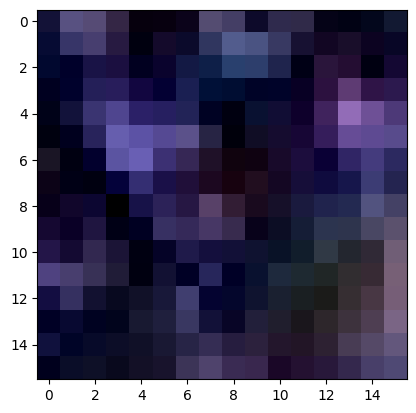

In [21]:
plt.imshow(optical_images1[7994])

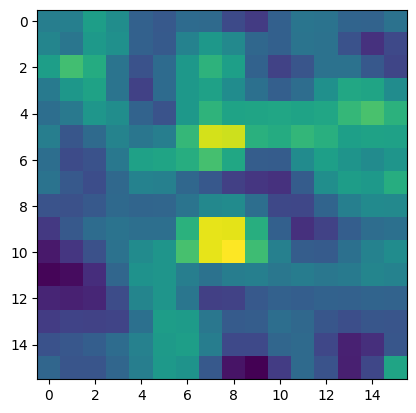

In [22]:
plt.imshow(sar_images1[7994])

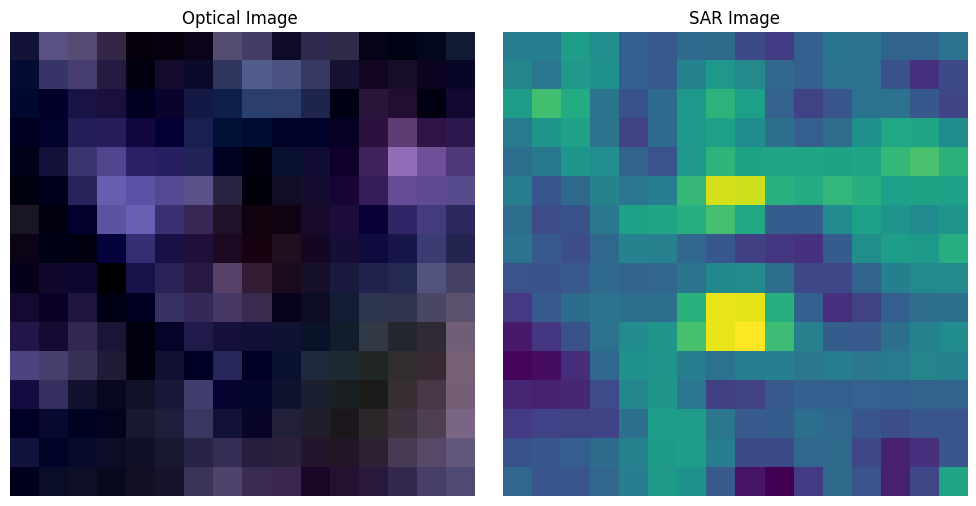

In [23]:
import matplotlib.pyplot as plt

# Assuming optical_images1 and sar_images1 are your image arrays
image_id = 7994

# Create a figure for displaying the images
plt.figure(figsize=(10, 5))

# Display optical image
plt.subplot(1, 2, 1)
plt.imshow(optical_images1[image_id])
plt.title(f'Optical Image ')
plt.axis('off')
plt.xlabel("Optical Image")

# Display corresponding SAR image
plt.subplot(1, 2, 2)
plt.imshow(sar_images1[image_id].squeeze())  # Use squeeze for SAR images if they have a singleton dimension
plt.title(f'SAR Image')
plt.axis('off')
plt.xlabel("SAR Image")

plt.tight_layout()
plt.show()


In [24]:
# Split the data into training and testing sets
train_optical, test_optical, train_sar, test_sar, train_labels, test_labels, train_species, test_species = train_test_split(
    optical_images1, sar_images1, labels, species_labels, test_size=0.35, random_state=42
)

# MultiDense Model for Multimodal Neural Network

## Model Description

The **MultiDense Model** belongs to the multimodal neural network class, specifically designed for tasks that involve processing information from multiple modalities. This model utilizes a series of dense layers to capture and integrate features from diverse input sources.

### Layers

1. **SAR Dense (`dense_sar`):**
   - Type: Dense
   - Output Shape: (None, sar_features)
   - Description: Processes SAR data through a dense layer.

2. **Optical Dense (`dense_optical`):**
   - Type: Dense
   - Output Shape: (None, optical_features)
   - Description: Processes Optical data through a dense layer.

3. **Additional Input Dense (`dense_additional`):**
   - Type: Dense
   - Output Shape: (None, additional_features)
   - Description: Processes any supplementary input through a dense layer.

4. **Concatenation (`concatenate`):**
   - Output Shape: (None, total_features)
   - Description: Concatenates the outputs from the dense layers.

5. **Output Dense (`dense_output`):**
   - Type: Dense
   - Output Shape: (None, 1)
   - Description: Produces the final output.

### Model Parameters

- **Total Parameters:** 453825

### Purpose

The **MultiDense Model** is tailored to handle multimodal tasks by effectively learning and combining information from SAR, Optical, and additional inputs. The architecture leverages dense layers to facilitate feature extraction and integration, making it suitable for various applications, such as height estimation.


## Mean Square Error 

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

# Assuming train_labels and test_labels are the target variables
#scaler = StandardScaler()
#train_labels_scaled = scaler.fit_transform(train_labels.reshape(-1, 1)).flatten()
#test_labels_scaled = scaler.transform(test_labels.reshape(-1, 1)).flatten()

# Define the processing layers for each input
optical_input = layers.Input(shape=(16, 16, 3))
sar_input = layers.Input(shape=(16, 16, 1))
species_input = layers.Input(shape=(1,))

# Processing layers for optical input
optical_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(optical_input)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(optical_output)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Flatten()(optical_output)

# Processing layers for SAR input
sar_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(sar_input)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(sar_output)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Flatten()(sar_output)

# Processing layers for species input
species_output = layers.Dense(32, activation="relu")(species_input)

# Concatenate the flattened outputs
merged = layers.concatenate([optical_output, sar_output, species_output])

# Additional dense layers
dense_layer1 = layers.Dense(256, activation="relu")(merged)
dense_layer2 = layers.Dense(128, activation="relu")(dense_layer1)

# Define the output layer
output_layer = layers.Dense(1, activation="linear", name="biomass_output")(dense_layer2)

# Create the model
model = keras.Model(inputs=[optical_input, sar_input, species_input], outputs=output_layer, name="custom_model")

from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())



# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()
#early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss',  # you can use 'val_mae' if you prefer to monitor mean absolute error
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
# Train the model with early stopping and validation data

history=model.fit([train_optical, train_sar, train_species], train_labels, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping] )

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([test_optical, test_sar, test_species], test_labels)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Model: "custom_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 16, 16, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           640       ['input_2[0][0]']             
                                                                                       

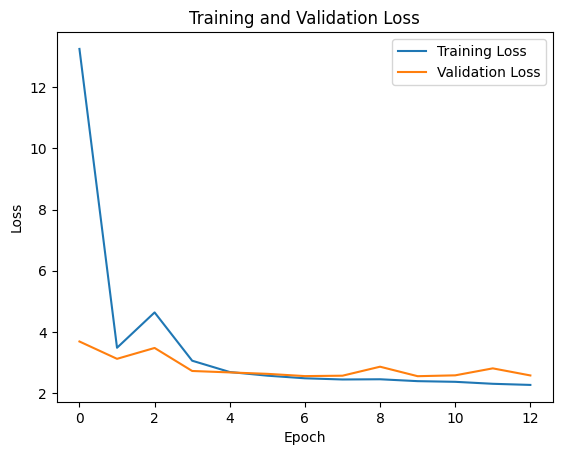

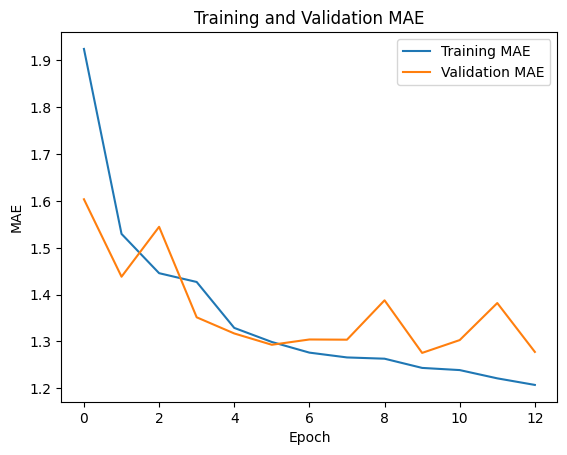

In [26]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

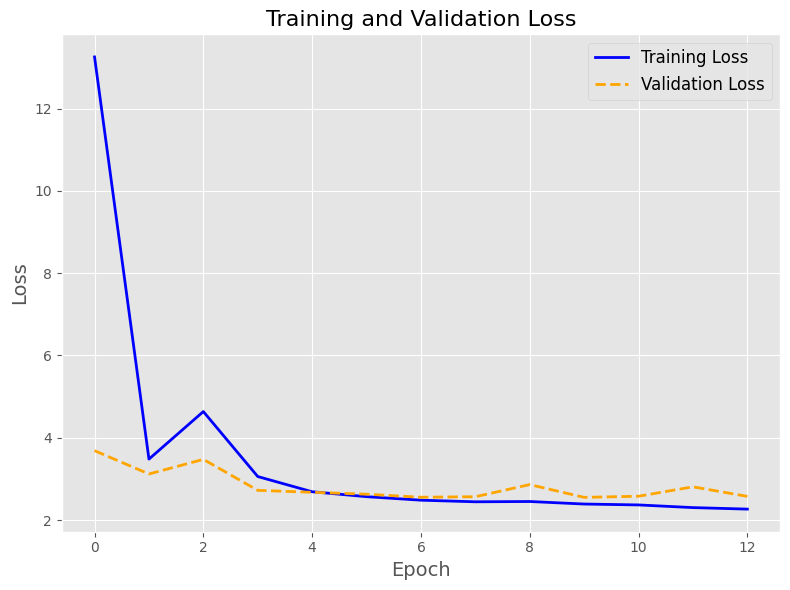

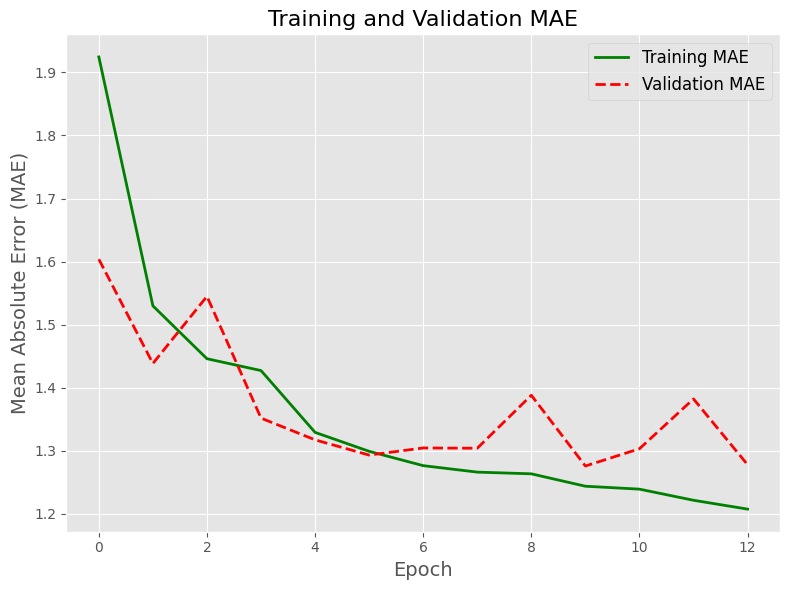

In [27]:
import matplotlib.pyplot as plt
import tikzplotlib

# Improved styling
plt.style.use('ggplot')  # You can choose other styles like 'seaborn', 'fivethirtyeight', etc.

# Plot Training and Validation Loss with better aesthetics
plt.figure(figsize=(8, 6))  # Set figure size for better visual clarity
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjusts the plot to ensure it fits into the figure area
tikzplotlib.save("training_validation_loss.tex")  # Export the figure to TikZ format for LaTeX
plt.show()

# Plot Training and Validation MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE', color='green', linestyle='-', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='red', linestyle='--', linewidth=2)
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
tikzplotlib.save("training_validation_mae.tex")  # Export the figure to TikZ format for LaTeX
plt.show()


318/318 [==============================] - 2s 5ms/step


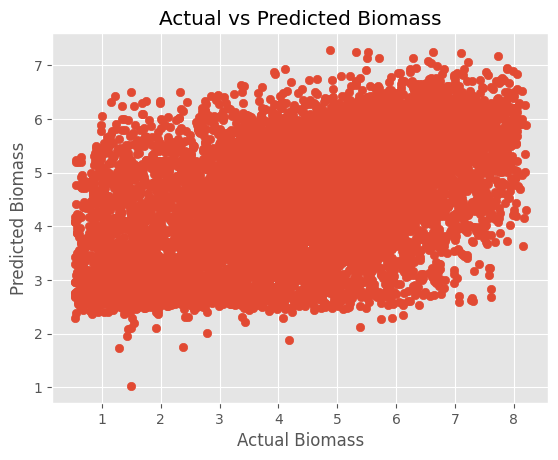

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])
#predictions_original = scaler.inverse_transform(predictions)
# Plot actual vs predicted values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')

# Print actual and predicted values
#for actual, predicted in zip(test_labels, predictions_original):
#    print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()

318/318 [==============================] - 2s 5ms/step


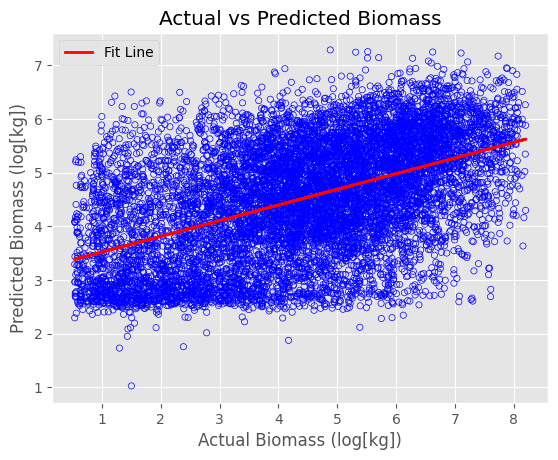

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming you have a test dataset and model.predict() is used to get predictions
predictions = model.predict([test_optical, test_sar, test_species])

# Fit line
lin_reg = LinearRegression()
lin_reg.fit(test_labels.reshape(-1, 1), predictions)
fit_line = lin_reg.predict(test_labels.reshape(-1, 1))

# Plot actual vs predicted values with smaller unfilled circles
plt.scatter(test_labels, predictions, facecolors='none', edgecolors='blue', s=20)  # s controls the size of the points
plt.plot(test_labels, fit_line, color='red', linewidth=2, label='Fit Line')  # Fit line in red

# Add labels and title
plt.xlabel('Actual Biomass (log[kg])')
plt.ylabel('Predicted Biomass (log[kg])')
plt.title('Actual vs Predicted Biomass')
plt.legend()
plt.savefig("actual_vs_predicted_biomass.pdf", format='pdf')
plt.show()


In [30]:
import numpy as np

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(test_labels.flatten(), predictions.flatten())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)


Correlation Coefficient: 0.4935571259848939


In [31]:
import numpy as np

# Assuming predictions is the array containing the estimated biomass values
predictions = model.predict([test_optical, test_sar, test_species])

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(test_labels.flatten(), predictions.flatten())[0, 1]

print("Correlation Coefficient:", correlation_coefficient)


318/318 [==============================] - 2s 6ms/step
Correlation Coefficient: 0.4935571259848939


318/318 [==============================] - 2s 5ms/step
Actual: 3.215637646021652, Predicted: [6.0585003]
Actual: 5.672623805423018, Predicted: [5.953465]
Actual: 2.8485288558530457, Predicted: [4.4836516]
Actual: 2.982755724653511, Predicted: [2.5244684]
Actual: 4.453552403316787, Predicted: [4.9555845]
Actual: 3.8033123099573674, Predicted: [5.2972383]
Actual: 4.303178580503014, Predicted: [3.046464]
Actual: 4.2126723123094525, Predicted: [4.1025724]
Actual: 6.117289225243448, Predicted: [4.869082]
Actual: 4.072034179193345, Predicted: [5.392817]
Actual: 5.879261615981892, Predicted: [6.682556]
Actual: 0.824791808675727, Predicted: [2.6144693]
Actual: 4.3150175563549364, Predicted: [4.2432613]
Actual: 2.0990654146425687, Predicted: [4.854382]
Actual: 5.40464846728574, Predicted: [3.1698153]
Actual: 5.534000080934279, Predicted: [4.6767025]
Actual: 6.125834387761698, Predicted: [5.614959]
Actual: 4.541990446142296, Predicted: [5.5478115]
Actual: 6.69173614301904, Predicted: [6.089102]


Actual: 5.381211011051805, Predicted: [5.2957835]
Actual: 5.879515917406026, Predicted: [4.543998]
Actual: 3.592339646376953, Predicted: [4.755769]
Actual: 4.023825852414276, Predicted: [4.9847717]
Actual: 3.111468901189514, Predicted: [5.735455]
Actual: 5.863891116810453, Predicted: [2.9654522]
Actual: 6.619657127581514, Predicted: [5.6495423]
Actual: 4.9843178885611, Predicted: [4.1988993]
Actual: 3.215312218759782, Predicted: [3.4131694]
Actual: 6.97100797661537, Predicted: [4.214437]
Actual: 3.064825596595516, Predicted: [4.721612]
Actual: 1.4040060153744325, Predicted: [4.9472766]
Actual: 1.2542739241410397, Predicted: [2.898316]
Actual: 3.511347074979108, Predicted: [5.8782682]
Actual: 6.547451498200704, Predicted: [5.2355003]
Actual: 6.715735946481079, Predicted: [3.1496706]
Actual: 4.279456575540559, Predicted: [5.0708995]
Actual: 2.0990654146425687, Predicted: [4.826053]
Actual: 4.666332157053614, Predicted: [4.92846]
Actual: 2.780926628215558, Predicted: [2.3996918]
Actual: 4

Actual: 4.980901991463737, Predicted: [4.528612]
Actual: 4.961206689567143, Predicted: [3.617279]
Actual: 6.770788551431535, Predicted: [4.3836384]
Actual: 4.5424780610780715, Predicted: [5.1421943]
Actual: 5.57297074268539, Predicted: [4.931473]
Actual: 6.004755173403086, Predicted: [4.840952]
Actual: 1.650560479185996, Predicted: [5.789379]
Actual: 6.137478696466176, Predicted: [3.7952418]
Actual: 6.121855537859582, Predicted: [5.935377]
Actual: 4.958505202674161, Predicted: [6.0985327]
Actual: 4.2103207975603665, Predicted: [3.577224]
Actual: 5.115060586569179, Predicted: [2.9806387]
Actual: 3.446485475975299, Predicted: [2.5315187]
Actual: 4.833363499365164, Predicted: [2.7725806]
Actual: 1.3480206274399773, Predicted: [2.8849454]
Actual: 3.56390831234319, Predicted: [4.8841686]
Actual: 3.707078381955597, Predicted: [4.3851585]
Actual: 6.176058007215738, Predicted: [6.0551434]
Actual: 5.77766506958105, Predicted: [4.414698]
Actual: 3.664629819787954, Predicted: [3.4678698]
Actual: 

Actual: 5.954635912252783, Predicted: [5.6017594]
Actual: 4.11205493233928, Predicted: [2.4651616]
Actual: 5.167837667053482, Predicted: [4.7174644]
Actual: 5.805925863305967, Predicted: [2.7518272]
Actual: 3.36041194029327, Predicted: [4.1213965]
Actual: 6.819236465107492, Predicted: [5.591259]
Actual: 4.409219356701589, Predicted: [5.327298]
Actual: 3.0792145518857086, Predicted: [4.7613125]
Actual: 3.8815700100890904, Predicted: [5.2657886]
Actual: 5.070638768059907, Predicted: [4.559106]
Actual: 2.754419216973576, Predicted: [2.560266]
Actual: 6.270903278327358, Predicted: [5.9468126]
Actual: 2.7955306801573703, Predicted: [3.7596962]
Actual: 6.0784152204426825, Predicted: [4.3673034]
Actual: 3.8679041720938594, Predicted: [5.1739182]
Actual: 3.4985390904527622, Predicted: [4.6761255]
Actual: 1.0058140136544065, Predicted: [5.015471]
Actual: 1.4097126105909858, Predicted: [5.5169373]
Actual: 3.9185424112446716, Predicted: [5.0722733]
Actual: 5.417055529036642, Predicted: [5.643477]

Actual: 5.508903713144109, Predicted: [3.8051953]
Actual: 4.621530931111447, Predicted: [4.177347]
Actual: 1.5205687852218914, Predicted: [3.8968315]
Actual: 1.5159813790652066, Predicted: [3.852924]
Actual: 4.195951435420503, Predicted: [4.362706]
Actual: 5.805170171610119, Predicted: [5.578532]
Actual: 4.64206376750824, Predicted: [4.878713]
Actual: 5.332213744977003, Predicted: [5.3095927]
Actual: 4.027965919944046, Predicted: [4.9179387]
Actual: 2.6354957583145535, Predicted: [2.6346874]
Actual: 2.511043340333927, Predicted: [3.5901291]
Actual: 3.4472520321678553, Predicted: [3.1532035]
Actual: 2.063019415049729, Predicted: [2.7847168]
Actual: 3.736760257082631, Predicted: [5.0718822]
Actual: 1.6297565910626874, Predicted: [4.630887]
Actual: 7.512983389268973, Predicted: [4.3929152]
Actual: 2.9814298944018915, Predicted: [3.56464]
Actual: 1.0342905138171428, Predicted: [2.5718155]
Actual: 3.1400012483304196, Predicted: [3.8977742]
Actual: 4.462992630447291, Predicted: [4.326954]
Ac

Actual: 4.667258898794177, Predicted: [4.367366]
Actual: 3.3915894075482305, Predicted: [2.8004146]
Actual: 3.4933452192562466, Predicted: [5.4397993]
Actual: 1.9089102500905302, Predicted: [3.8164608]
Actual: 7.968907564949519, Predicted: [5.721527]
Actual: 5.920318666971085, Predicted: [5.463773]
Actual: 0.7071574182328972, Predicted: [4.854867]
Actual: 2.976986760645459, Predicted: [3.1349356]
Actual: 1.929930001343689, Predicted: [5.459609]
Actual: 4.480683768537054, Predicted: [4.511631]
Actual: 4.162391290056275, Predicted: [4.4116836]
Actual: 0.7161881562902294, Predicted: [2.8389492]
Actual: 5.011550569104265, Predicted: [3.4504595]
Actual: 6.113715873069918, Predicted: [3.3141077]
Actual: 6.061709943091859, Predicted: [5.4575515]
Actual: 6.819592469821567, Predicted: [3.638958]
Actual: 4.746242898493834, Predicted: [6.0307126]
Actual: 4.188758131403348, Predicted: [5.186509]
Actual: 3.728282384318528, Predicted: [2.7060804]
Actual: 7.047785108081139, Predicted: [5.4253364]
Act

Actual: 4.682355474201187, Predicted: [5.096469]
Actual: 4.856702386443805, Predicted: [4.0614734]
Actual: 7.512568491041035, Predicted: [5.7401953]
Actual: 1.7859708093848994, Predicted: [3.2589154]
Actual: 6.6557729813975985, Predicted: [4.8355784]
Actual: 5.797646638877677, Predicted: [5.6562805]
Actual: 4.604895594691351, Predicted: [2.4366333]
Actual: 3.1764633908526205, Predicted: [5.1032147]
Actual: 3.6006000976689285, Predicted: [2.6820655]
Actual: 5.991314990925013, Predicted: [5.2516966]
Actual: 5.453308148818968, Predicted: [5.818459]
Actual: 3.5806089724979584, Predicted: [5.0078354]
Actual: 0.9945589405166824, Predicted: [5.8891344]
Actual: 3.161316638823917, Predicted: [3.9357839]
Actual: 5.304476057816292, Predicted: [5.866377]
Actual: 7.617247332848032, Predicted: [5.640894]
Actual: 1.3018482703318834, Predicted: [2.5648303]
Actual: 2.9227305959230656, Predicted: [2.8263347]
Actual: 5.280298958136263, Predicted: [5.3705764]
Actual: 6.819236465107492, Predicted: [6.23637

Actual: 5.860076380418801, Predicted: [3.8831048]
Actual: 5.28421305523719, Predicted: [6.0916276]
Actual: 5.506113078415938, Predicted: [4.954343]
Actual: 5.466998348096497, Predicted: [5.097371]
Actual: 4.774824641907275, Predicted: [4.5077553]
Actual: 4.169547563695651, Predicted: [5.8270416]
Actual: 6.493878620114717, Predicted: [5.3292303]
Actual: 0.7749571314312291, Predicted: [2.784935]
Actual: 4.474660579964209, Predicted: [4.103544]
Actual: 5.440217018046201, Predicted: [5.3908396]
Actual: 1.4609132079870437, Predicted: [3.1732311]
Actual: 5.916021286969313, Predicted: [6.3662987]
Actual: 4.371557756824706, Predicted: [5.7564964]
Actual: 1.0226228848595125, Predicted: [5.3503294]
Actual: 7.572601101091619, Predicted: [4.4191246]
Actual: 2.348694592055812, Predicted: [2.558752]
Actual: 5.842973763514972, Predicted: [3.3170784]
Actual: 0.8293274245655233, Predicted: [2.6587415]
Actual: 4.716003582077384, Predicted: [6.0763407]
Actual: 3.9231994041548055, Predicted: [4.4434996]
A

Actual: 6.3837519115579795, Predicted: [5.86526]
Actual: 1.605611397655608, Predicted: [3.351783]
Actual: 1.707616433520682, Predicted: [3.1388602]
Actual: 5.3378515204774715, Predicted: [4.900777]
Actual: 6.195003975386737, Predicted: [2.6156588]
Actual: 4.9090593051117715, Predicted: [4.136771]
Actual: 3.0985925197414868, Predicted: [4.047051]
Actual: 6.434857430481506, Predicted: [2.9963872]
Actual: 5.551258638356669, Predicted: [5.7570677]
Actual: 6.4603185298258206, Predicted: [5.930743]
Actual: 4.325991289779383, Predicted: [5.1489964]
Actual: 5.156436021324501, Predicted: [4.5027065]
Actual: 4.777758198495639, Predicted: [4.0694137]
Actual: 5.052962455444375, Predicted: [5.241516]
Actual: 1.6989346655162452, Predicted: [2.5326085]
Actual: 5.194332829907849, Predicted: [5.1321883]
Actual: 4.87417841650572, Predicted: [4.309879]
Actual: 6.97100797661537, Predicted: [4.6698284]
Actual: 7.752848865885447, Predicted: [4.152921]
Actual: 3.3016548575106155, Predicted: [5.8221664]
Actua

Actual: 5.444581571149038, Predicted: [4.7755356]
Actual: 4.140849576949026, Predicted: [4.141631]
Actual: 3.973324774869547, Predicted: [3.7544794]
Actual: 6.307118400770714, Predicted: [4.9715223]
Actual: 4.181271418139925, Predicted: [4.4364185]
Actual: 7.3520244224197935, Predicted: [4.499264]
Actual: 7.636493759239127, Predicted: [5.806969]
Actual: 4.009011802111958, Predicted: [3.599576]
Actual: 5.210239999228913, Predicted: [3.4556735]
Actual: 5.092406329504435, Predicted: [5.349669]
Actual: 0.8111902001953429, Predicted: [3.1076515]
Actual: 4.88290748519626, Predicted: [6.0866637]
Actual: 5.681111874253977, Predicted: [4.755618]
Actual: 6.543205212217238, Predicted: [5.5932703]
Actual: 2.9159611465824105, Predicted: [4.7259665]
Actual: 3.5326816538229955, Predicted: [4.0207386]
Actual: 3.719445751574309, Predicted: [2.518718]
Actual: 1.8463313560279946, Predicted: [2.8796709]
Actual: 4.400774237980862, Predicted: [3.0291533]
Actual: 1.4545367910293183, Predicted: [5.5229836]
Ac

Actual: 5.272294738954701, Predicted: [3.4231644]
Actual: 6.829426713735005, Predicted: [4.8848047]
Actual: 0.6981290971795429, Predicted: [3.4866147]
Actual: 4.390449792566081, Predicted: [3.7865143]
Actual: 4.418591242249763, Predicted: [5.742009]
Actual: 4.987204005685321, Predicted: [4.424848]
Actual: 4.55569036300368, Predicted: [5.104454]
Actual: 1.0251488418914807, Predicted: [4.149282]
Actual: 1.5233031101950871, Predicted: [4.5833864]
Actual: 4.122133397701722, Predicted: [4.421618]
Actual: 5.162137938971623, Predicted: [4.979327]
Actual: 4.409219356701589, Predicted: [5.4791093]
Actual: 4.733680171423139, Predicted: [4.0939236]
Actual: 5.687756662227311, Predicted: [5.610591]
Actual: 4.734858117218511, Predicted: [5.981947]
Actual: 4.352805585354897, Predicted: [5.7584887]
Actual: 3.3309113780115136, Predicted: [4.6567764]
Actual: 5.379022511991986, Predicted: [5.306715]
Actual: 6.751309060604493, Predicted: [6.1593785]
Actual: 5.385694827645701, Predicted: [5.0633497]
Actual

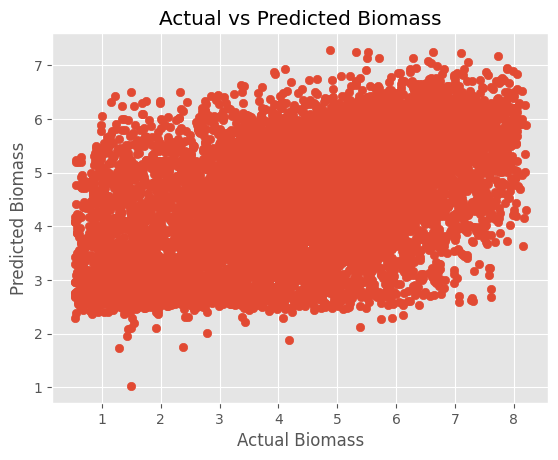

In [32]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])


# Plot actual vs predicted values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')


# Print actual and predicted values
for actual, predicted in zip(test_labels, predictions):
    print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()

In [33]:
log_predictions = model.predict([test_optical, test_sar, test_species])
predictions = np.expm1(log_predictions)  # Inverse of log1p is expm1


# Assuming that the test set index corresponds to the Tree ID
results = pd.DataFrame({
    'ActualBiomass': np.expm1(test_labels),  # Need to inverse the log transformation of y_test
    'PredictedBiomass': predictions.flatten()
})
print(results)


318/318 [==============================] - 2s 5ms/step
       ActualBiomass  PredictedBiomass
0          23.919176        426.733490
1         289.796528        384.085358
2          16.262368         87.557465
3          18.742146         11.484257
4          84.931666        140.965561
...              ...               ...
10169      47.500301        476.123840
10170      13.005169         49.107597
10171      69.705286         93.734642
10172     392.890238         47.199219
10173     184.281715        110.202446

[10174 rows x 2 columns]


In [34]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions using the model
predictions = model.predict([test_optical, test_sar, test_species])

# The number of epochs the model actually trained
epochs_trained = len(history.history['loss'])
# Evaluate regression metrics
mae = mean_absolute_error(test_labels, predictions)
rmse = mean_squared_error(test_labels, predictions, squared=False)


# Print the results
#print(f"Computational Time: {computational_time} seconds")
print(f"Number of Epochs Trained: {epochs_trained}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

318/318 [==============================] - 2s 6ms/step
Number of Epochs Trained: 13
Mean Absolute Error (MAE): 1.2715902903615377
Root Mean Squared Error (RMSE): 1.5857592826419988
